In [3]:
# Import Dependencies
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import seaborn as sns
import math
import itertools

In [4]:
# Defining file paths/reading data with pandas library

hourly_file_path = Path("Resources/saleshourly.csv")
hourly_df = pd.read_csv(hourly_file_path, encoding="ISO-8859-1")

daily_file_path = Path("Resources/salesdaily.csv")
daily_df = pd.read_csv(daily_file_path, encoding="ISO-8859-1")

weekly_file_path = Path("Resources/salesweekly.csv")
weekly_df = pd.read_csv(weekly_file_path, encoding="ISO-8859-1")

monthly_file_path = Path("Resources/salesmonthly.csv")
monthly_df = pd.read_csv(monthly_file_path, encoding="ISO-8859-1")

In [5]:
weekly_df

datum  M01AB   M01AE  N02BA    N02BE  N05B  N05C        R03    R06
0      1/5/2014  14.00  11.670  21.30  185.950  41.0   0.0  32.000000   7.00
1     1/12/2014  29.33  12.680  37.90  190.700  88.0   5.0  21.000000   7.20
2     1/19/2014  30.67  26.340  45.90  218.400  80.0   8.0  29.000000  12.00
3     1/26/2014  34.00  32.370  31.50  179.600  80.0   8.0  23.000000  10.00
4      2/2/2014  31.02  23.350  20.70  159.880  84.0  12.0  29.000000  12.00
..          ...    ...     ...    ...      ...   ...   ...        ...    ...
297   9/15/2019  35.51  30.977  19.65  178.375  67.2   5.0  30.000000  30.50
298   9/22/2019  46.84  25.396  24.40  248.250  31.2   3.0  26.000000  21.00
299   9/29/2019  34.01  22.498  26.60  336.700  61.2   1.0  40.416667  23.10
300   10/6/2019  38.70  32.502  19.25  249.450  69.0   5.0  30.000000  12.13
301  10/13/2019   7.67   6.237   3.50   95.100  26.0   2.0  12.000000   1.00

[302 rows x 9 columns]

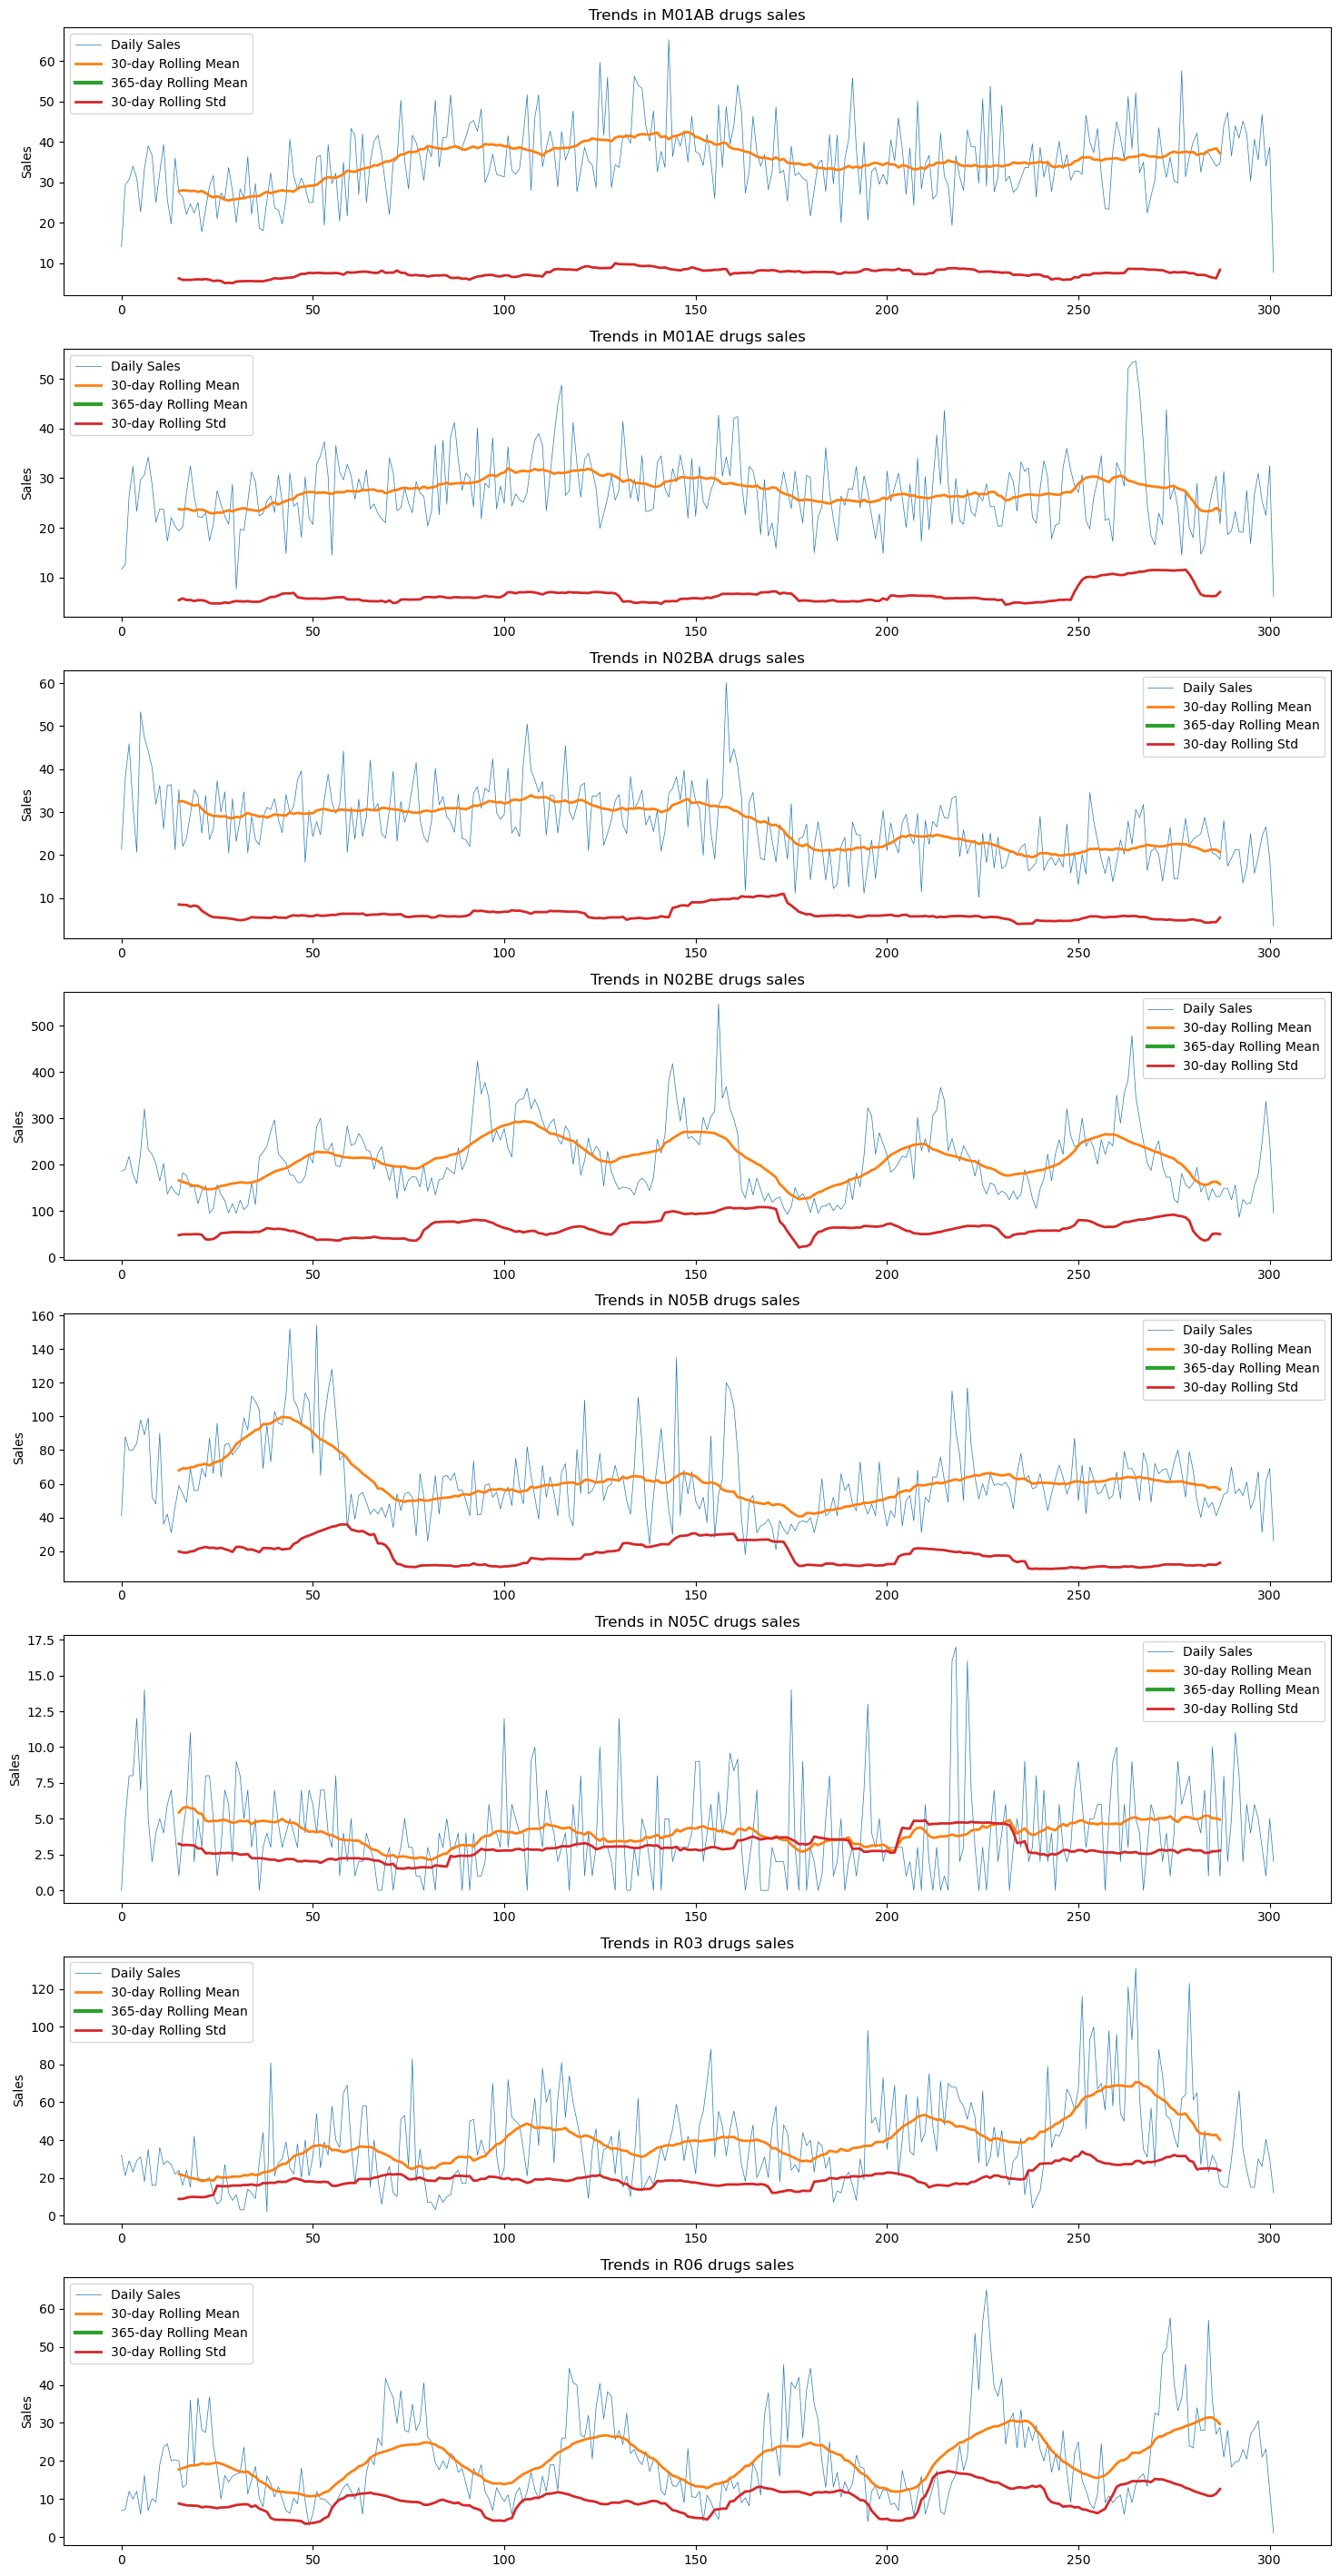

In [22]:
# Rolling Window Means

drugs = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
weekly_30 = weekly_df[drugs].rolling(window=30, center=True).mean()
weekly_365 = weekly_df[drugs].rolling(window=365, center=True).mean()
weekly_std = weekly_df[drugs].rolling(window=30, center=True).std()

subplotindex=0
fig, ax = plt.subplots(8, 1, figsize=(18, 36))

for drug in drugs:
    ax[subplotindex].plot(weekly_df.loc[:,drug], linewidth=0.5, label='Daily Sales')
    ax[subplotindex].plot(weekly_30.loc[:,drug], linewidth=2, label='30-day Rolling Mean')
    ax[subplotindex].plot(weekly_365.loc[:,drug], linewidth=3, label='365-day Rolling Mean')
    ax[subplotindex].plot(weekly_std.loc[:,drug], linewidth=2, label='30-day Rolling Std')
    ax[subplotindex].set_ylabel('Sales')
    ax[subplotindex].legend()
    ax[subplotindex].set_title(f'Trends in {drug} drugs sales');   
    subplotindex+=1
plt.show()

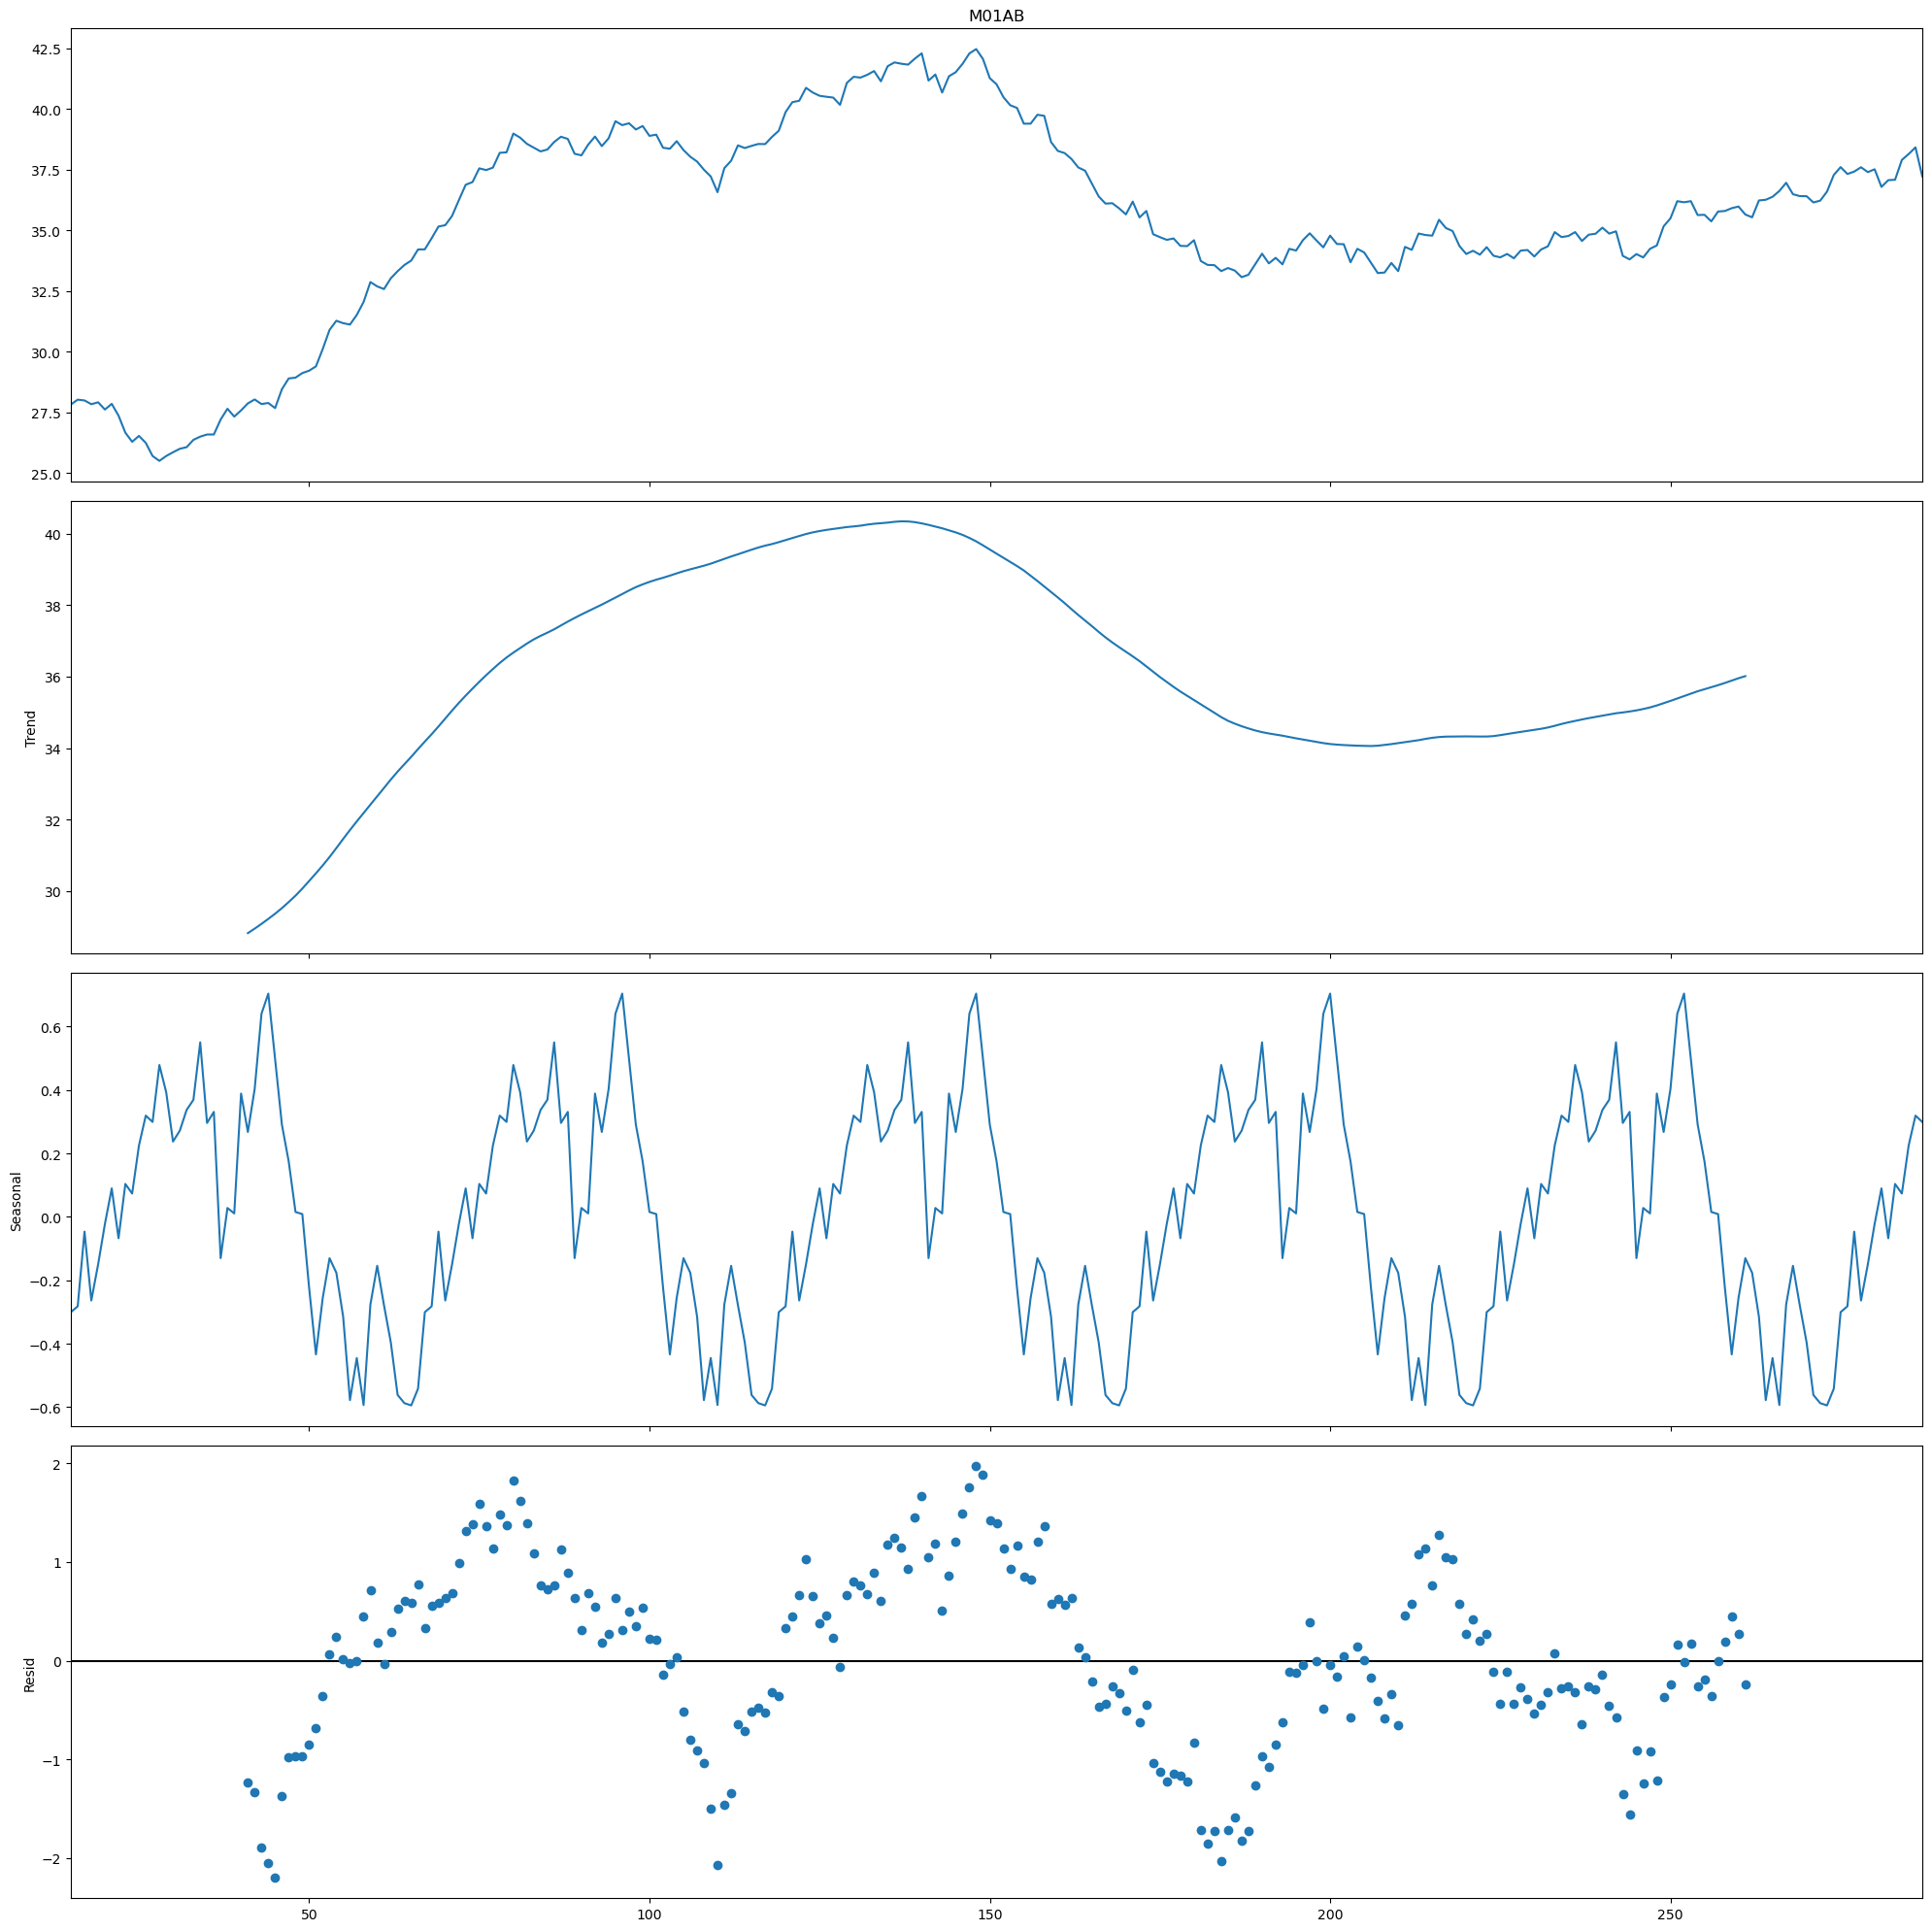

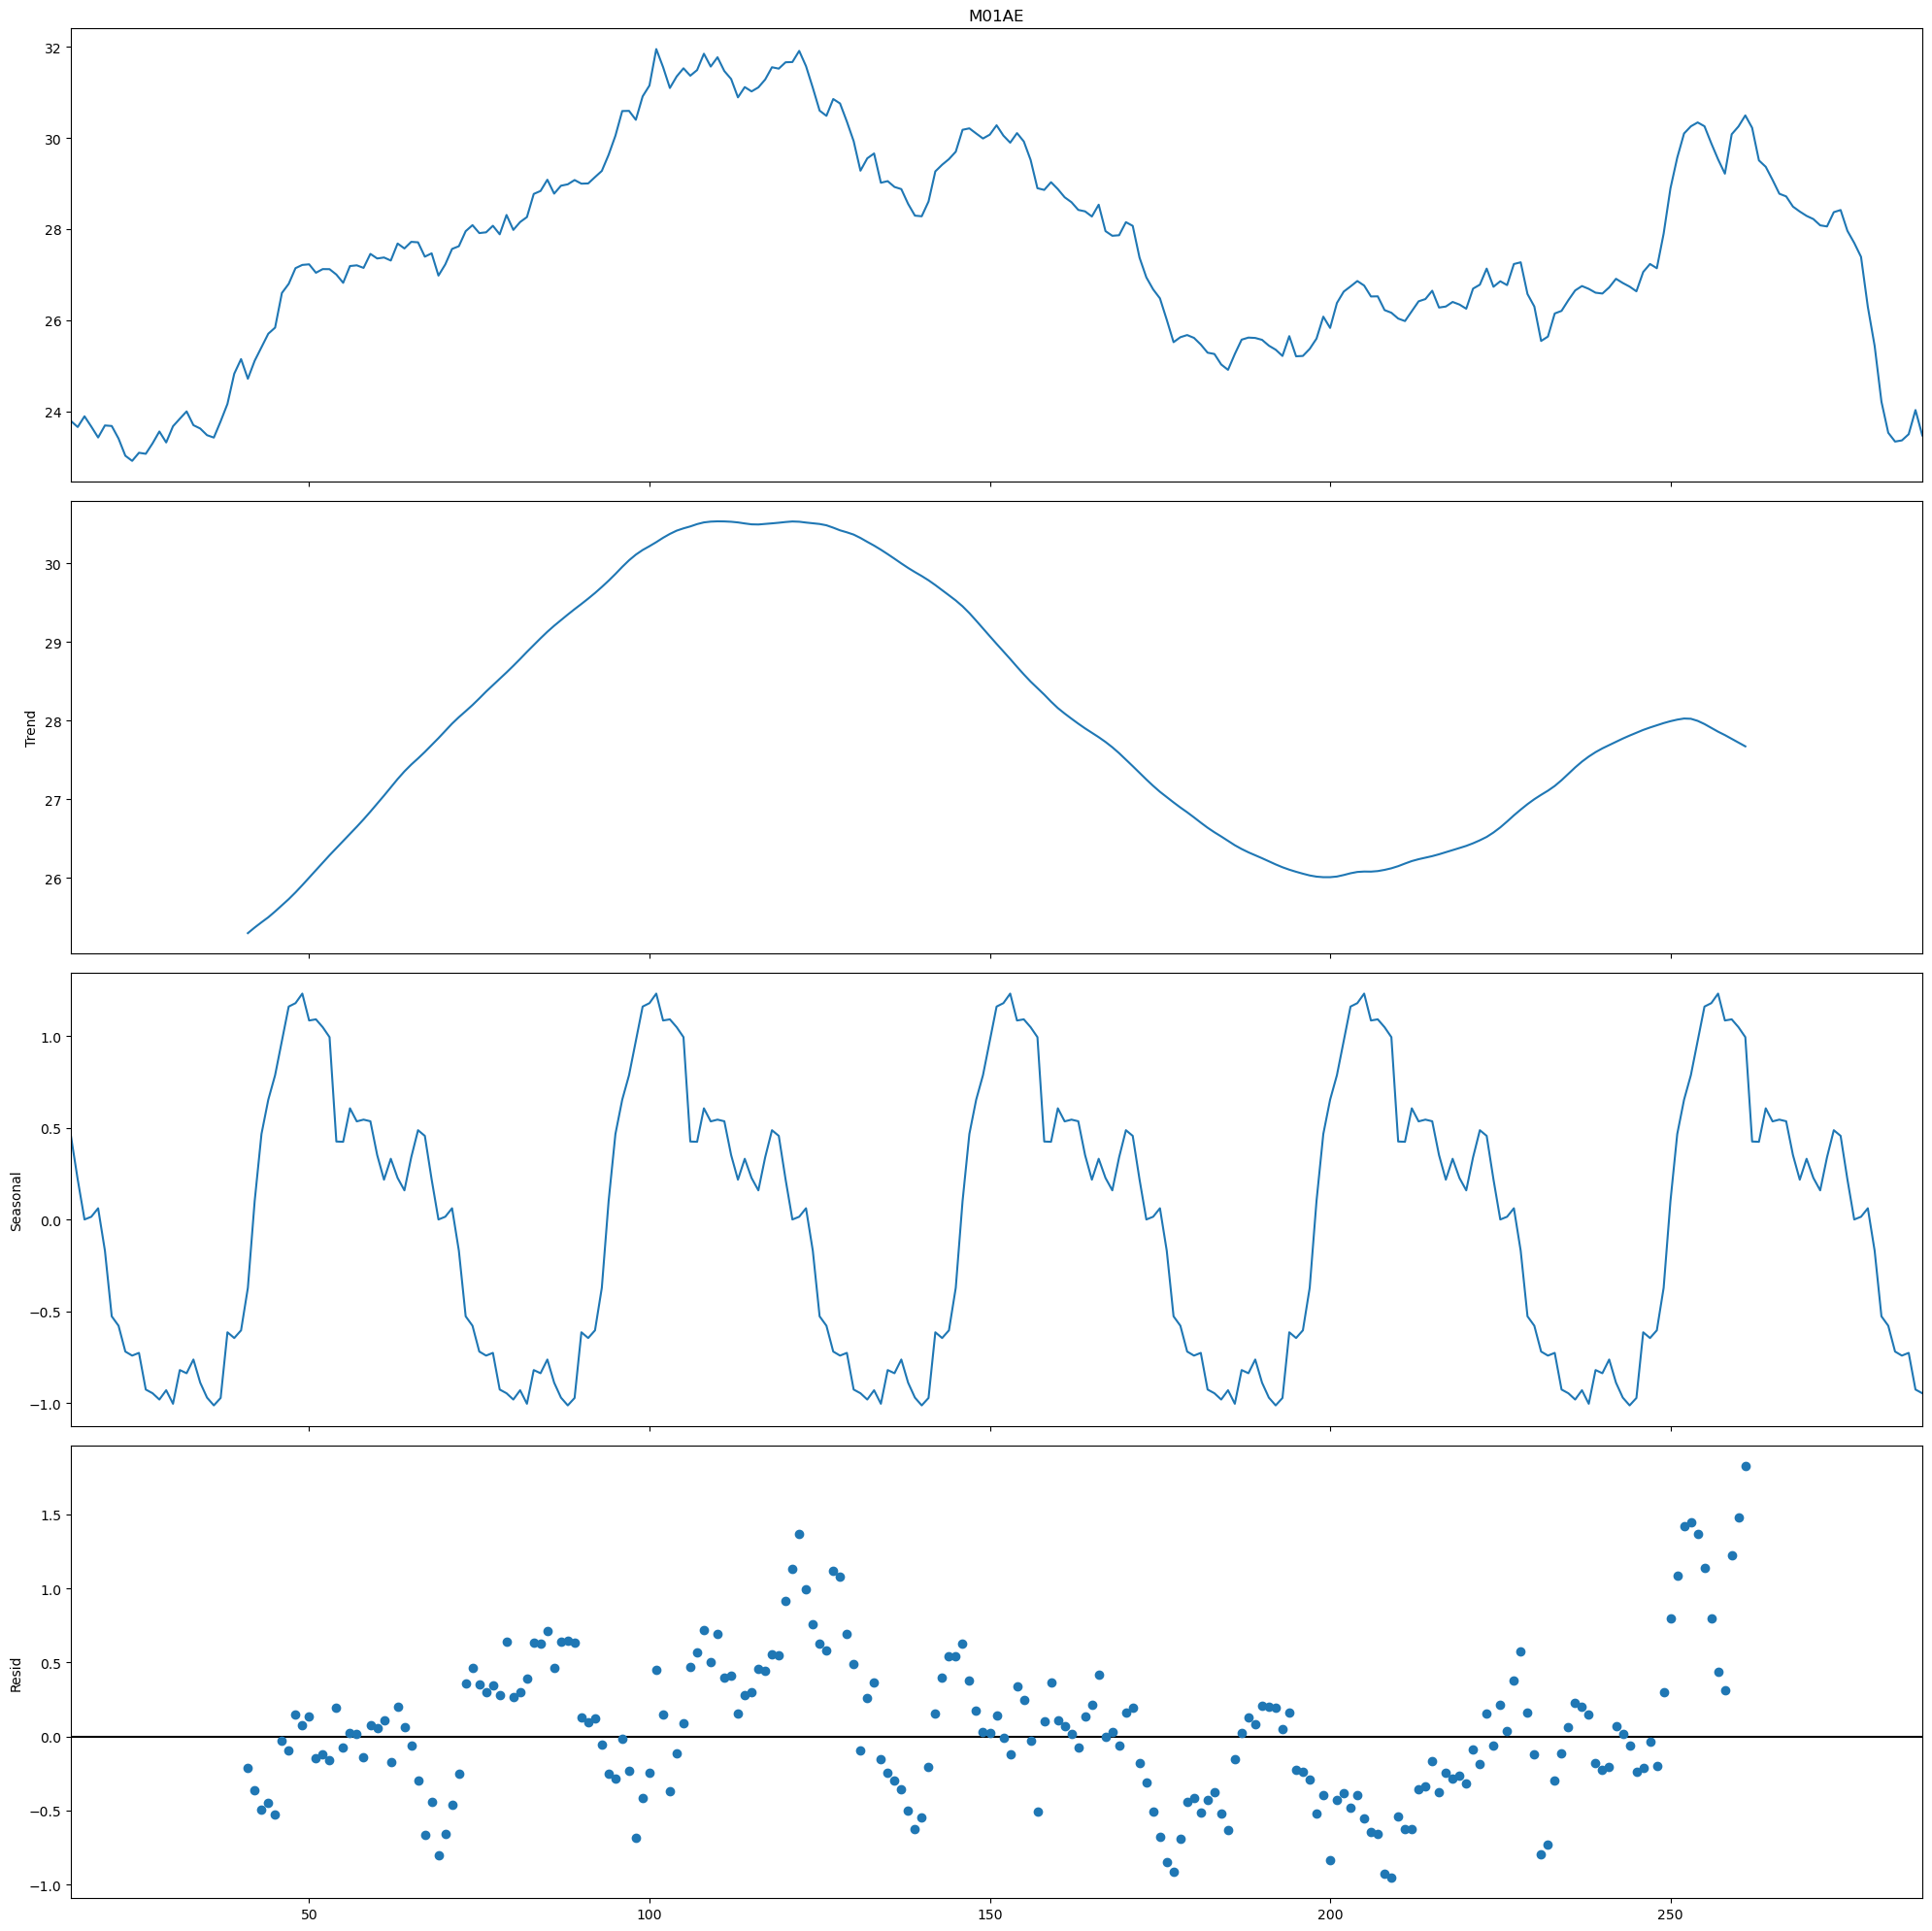

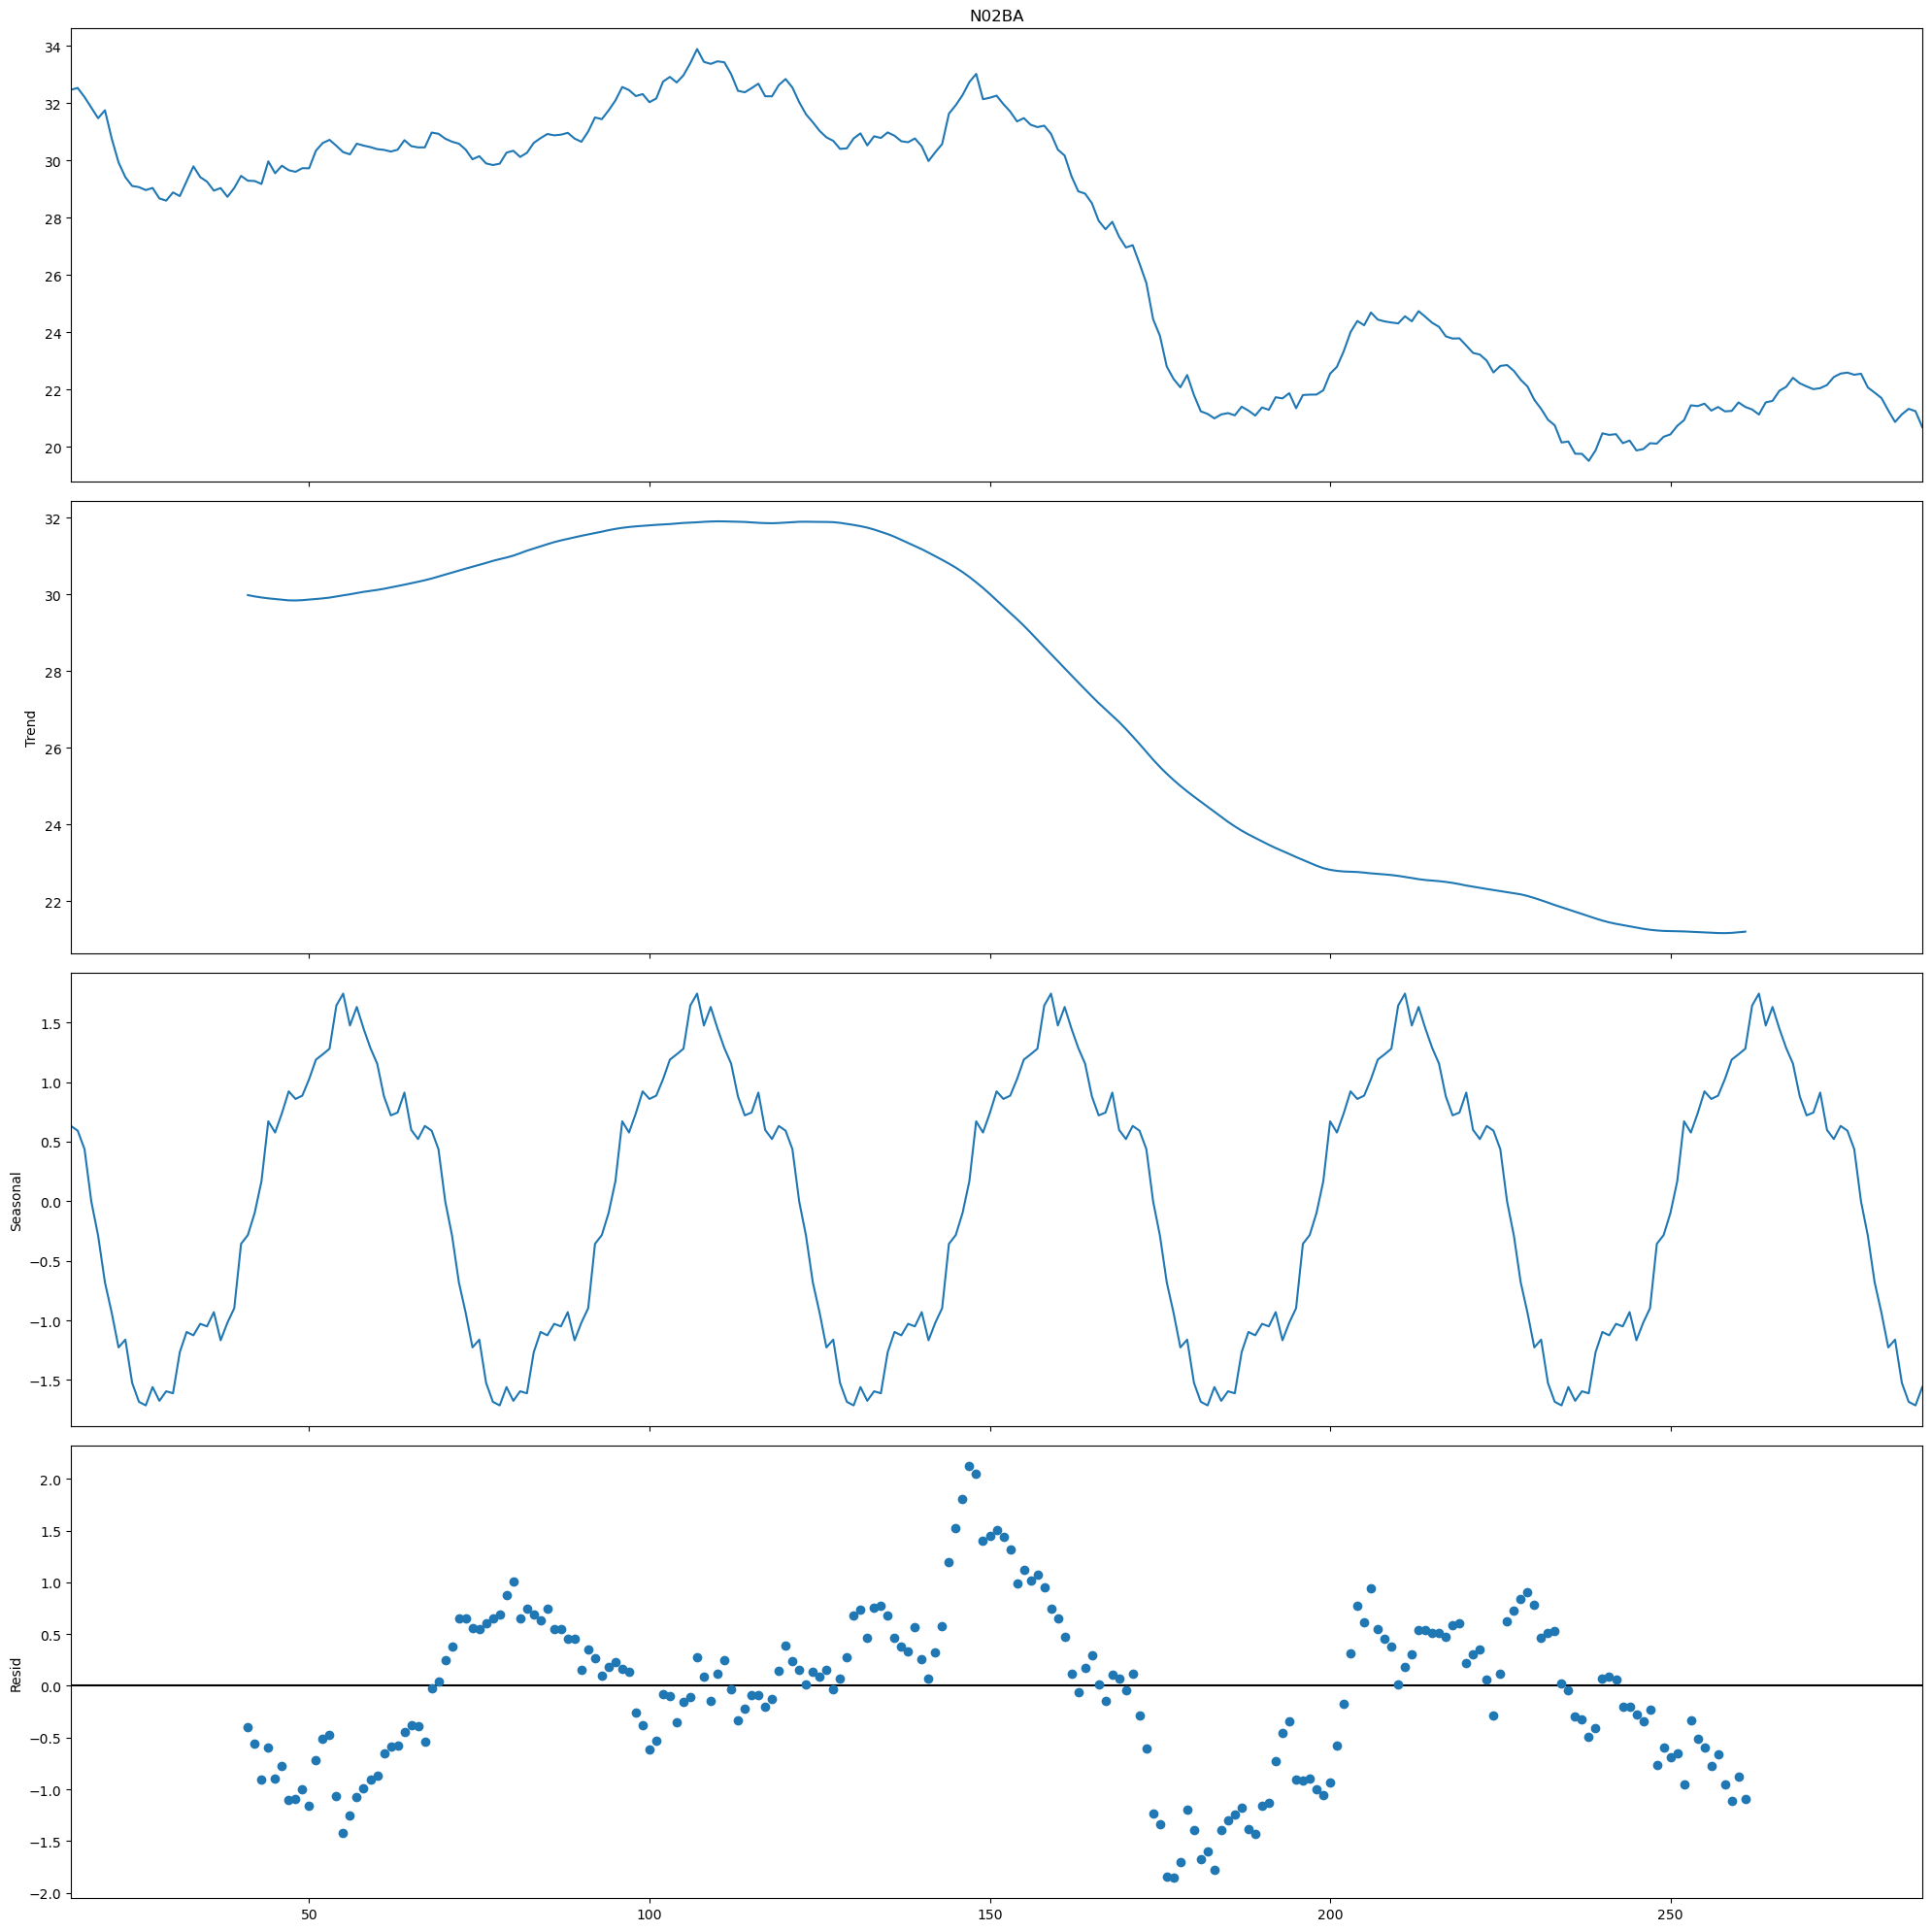

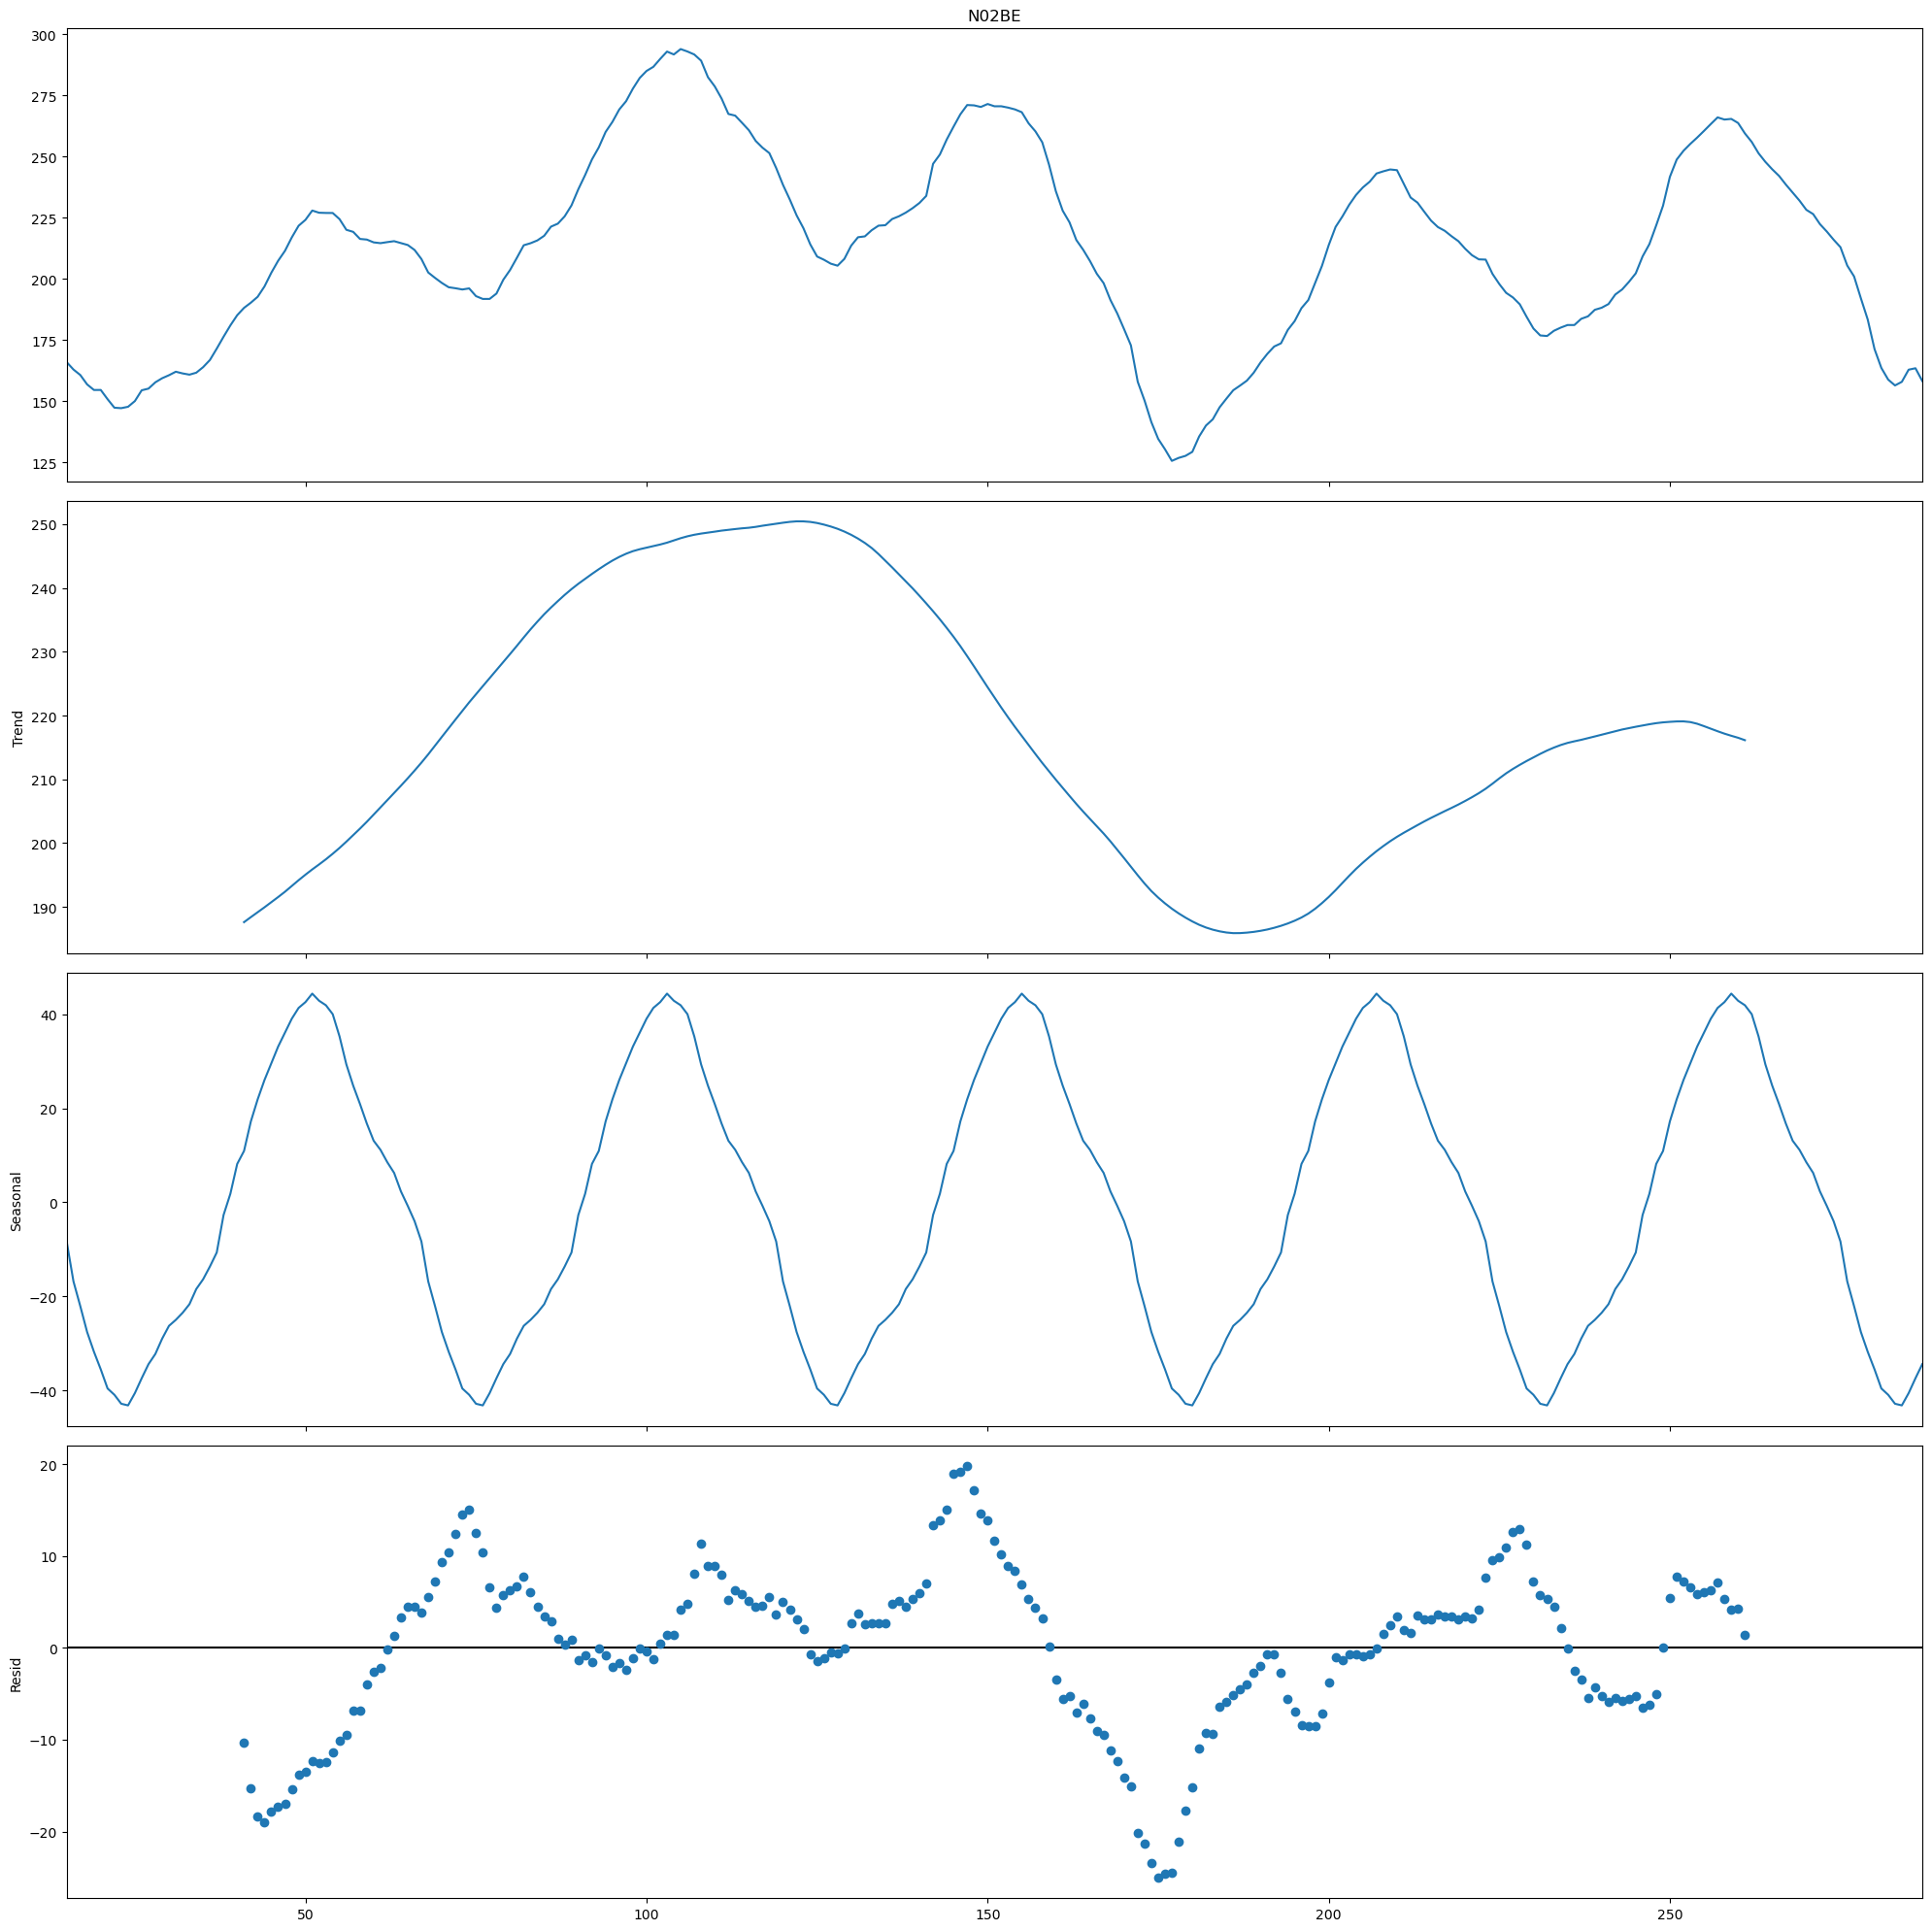

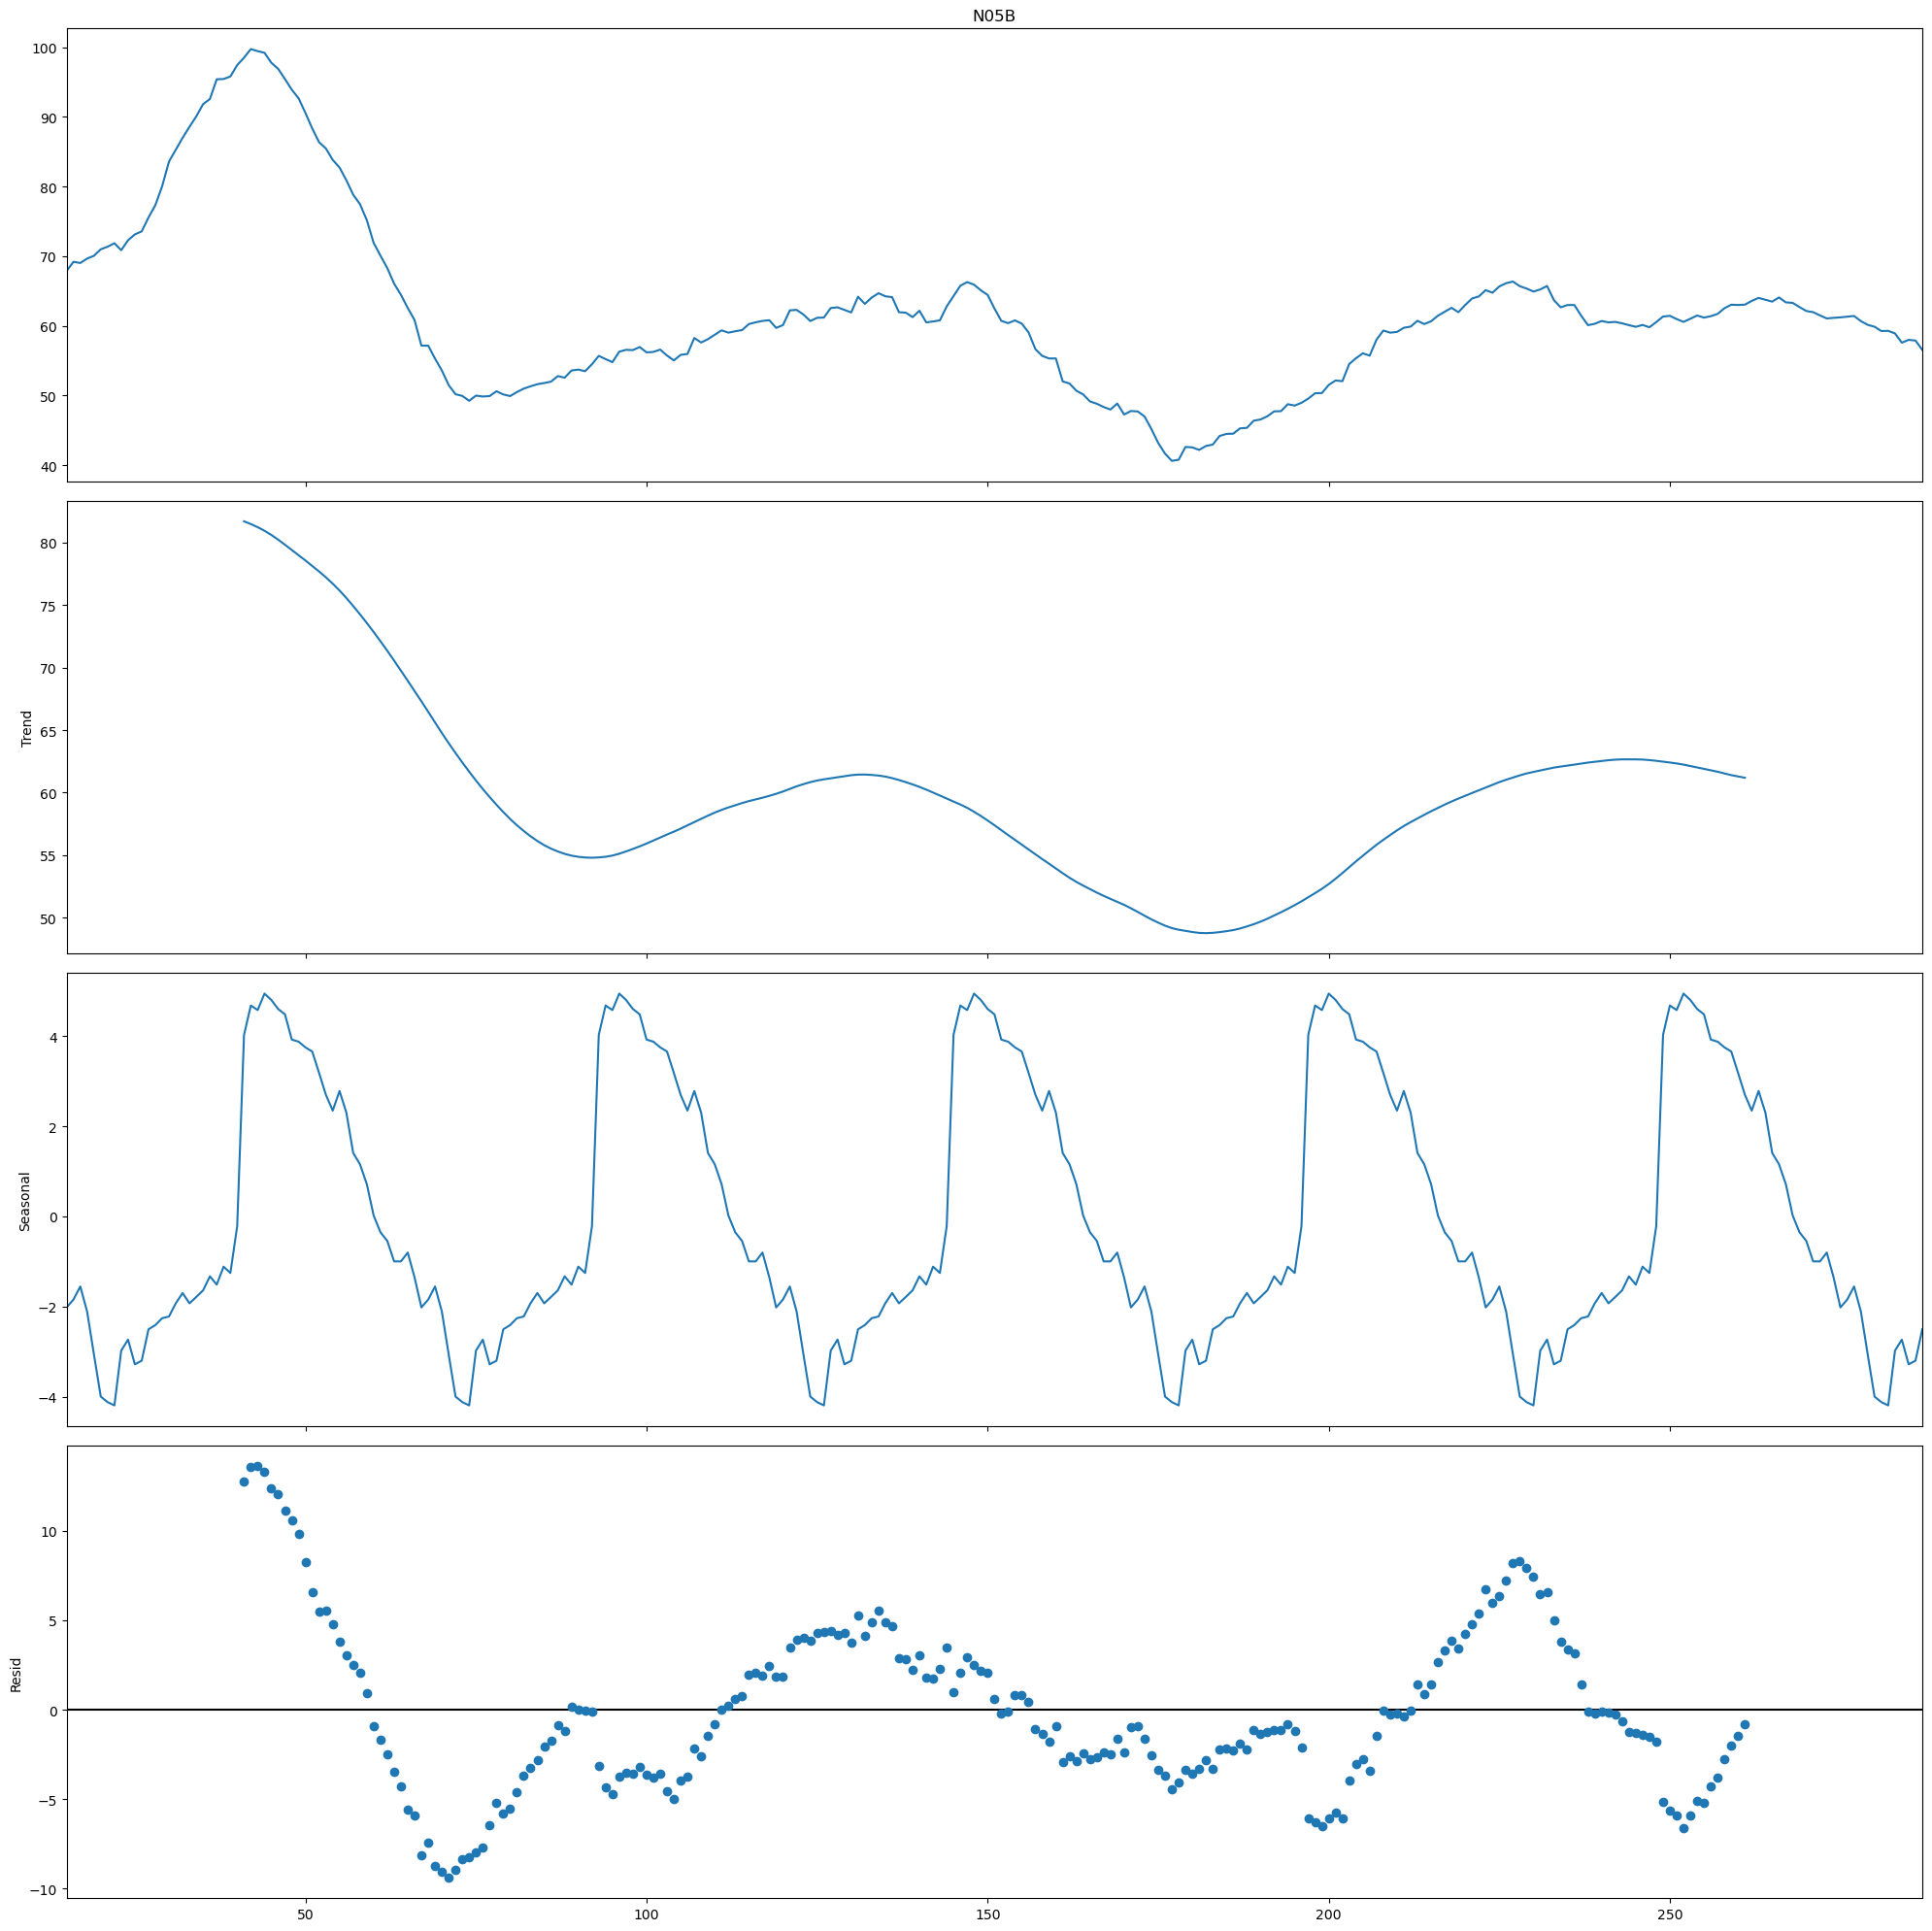

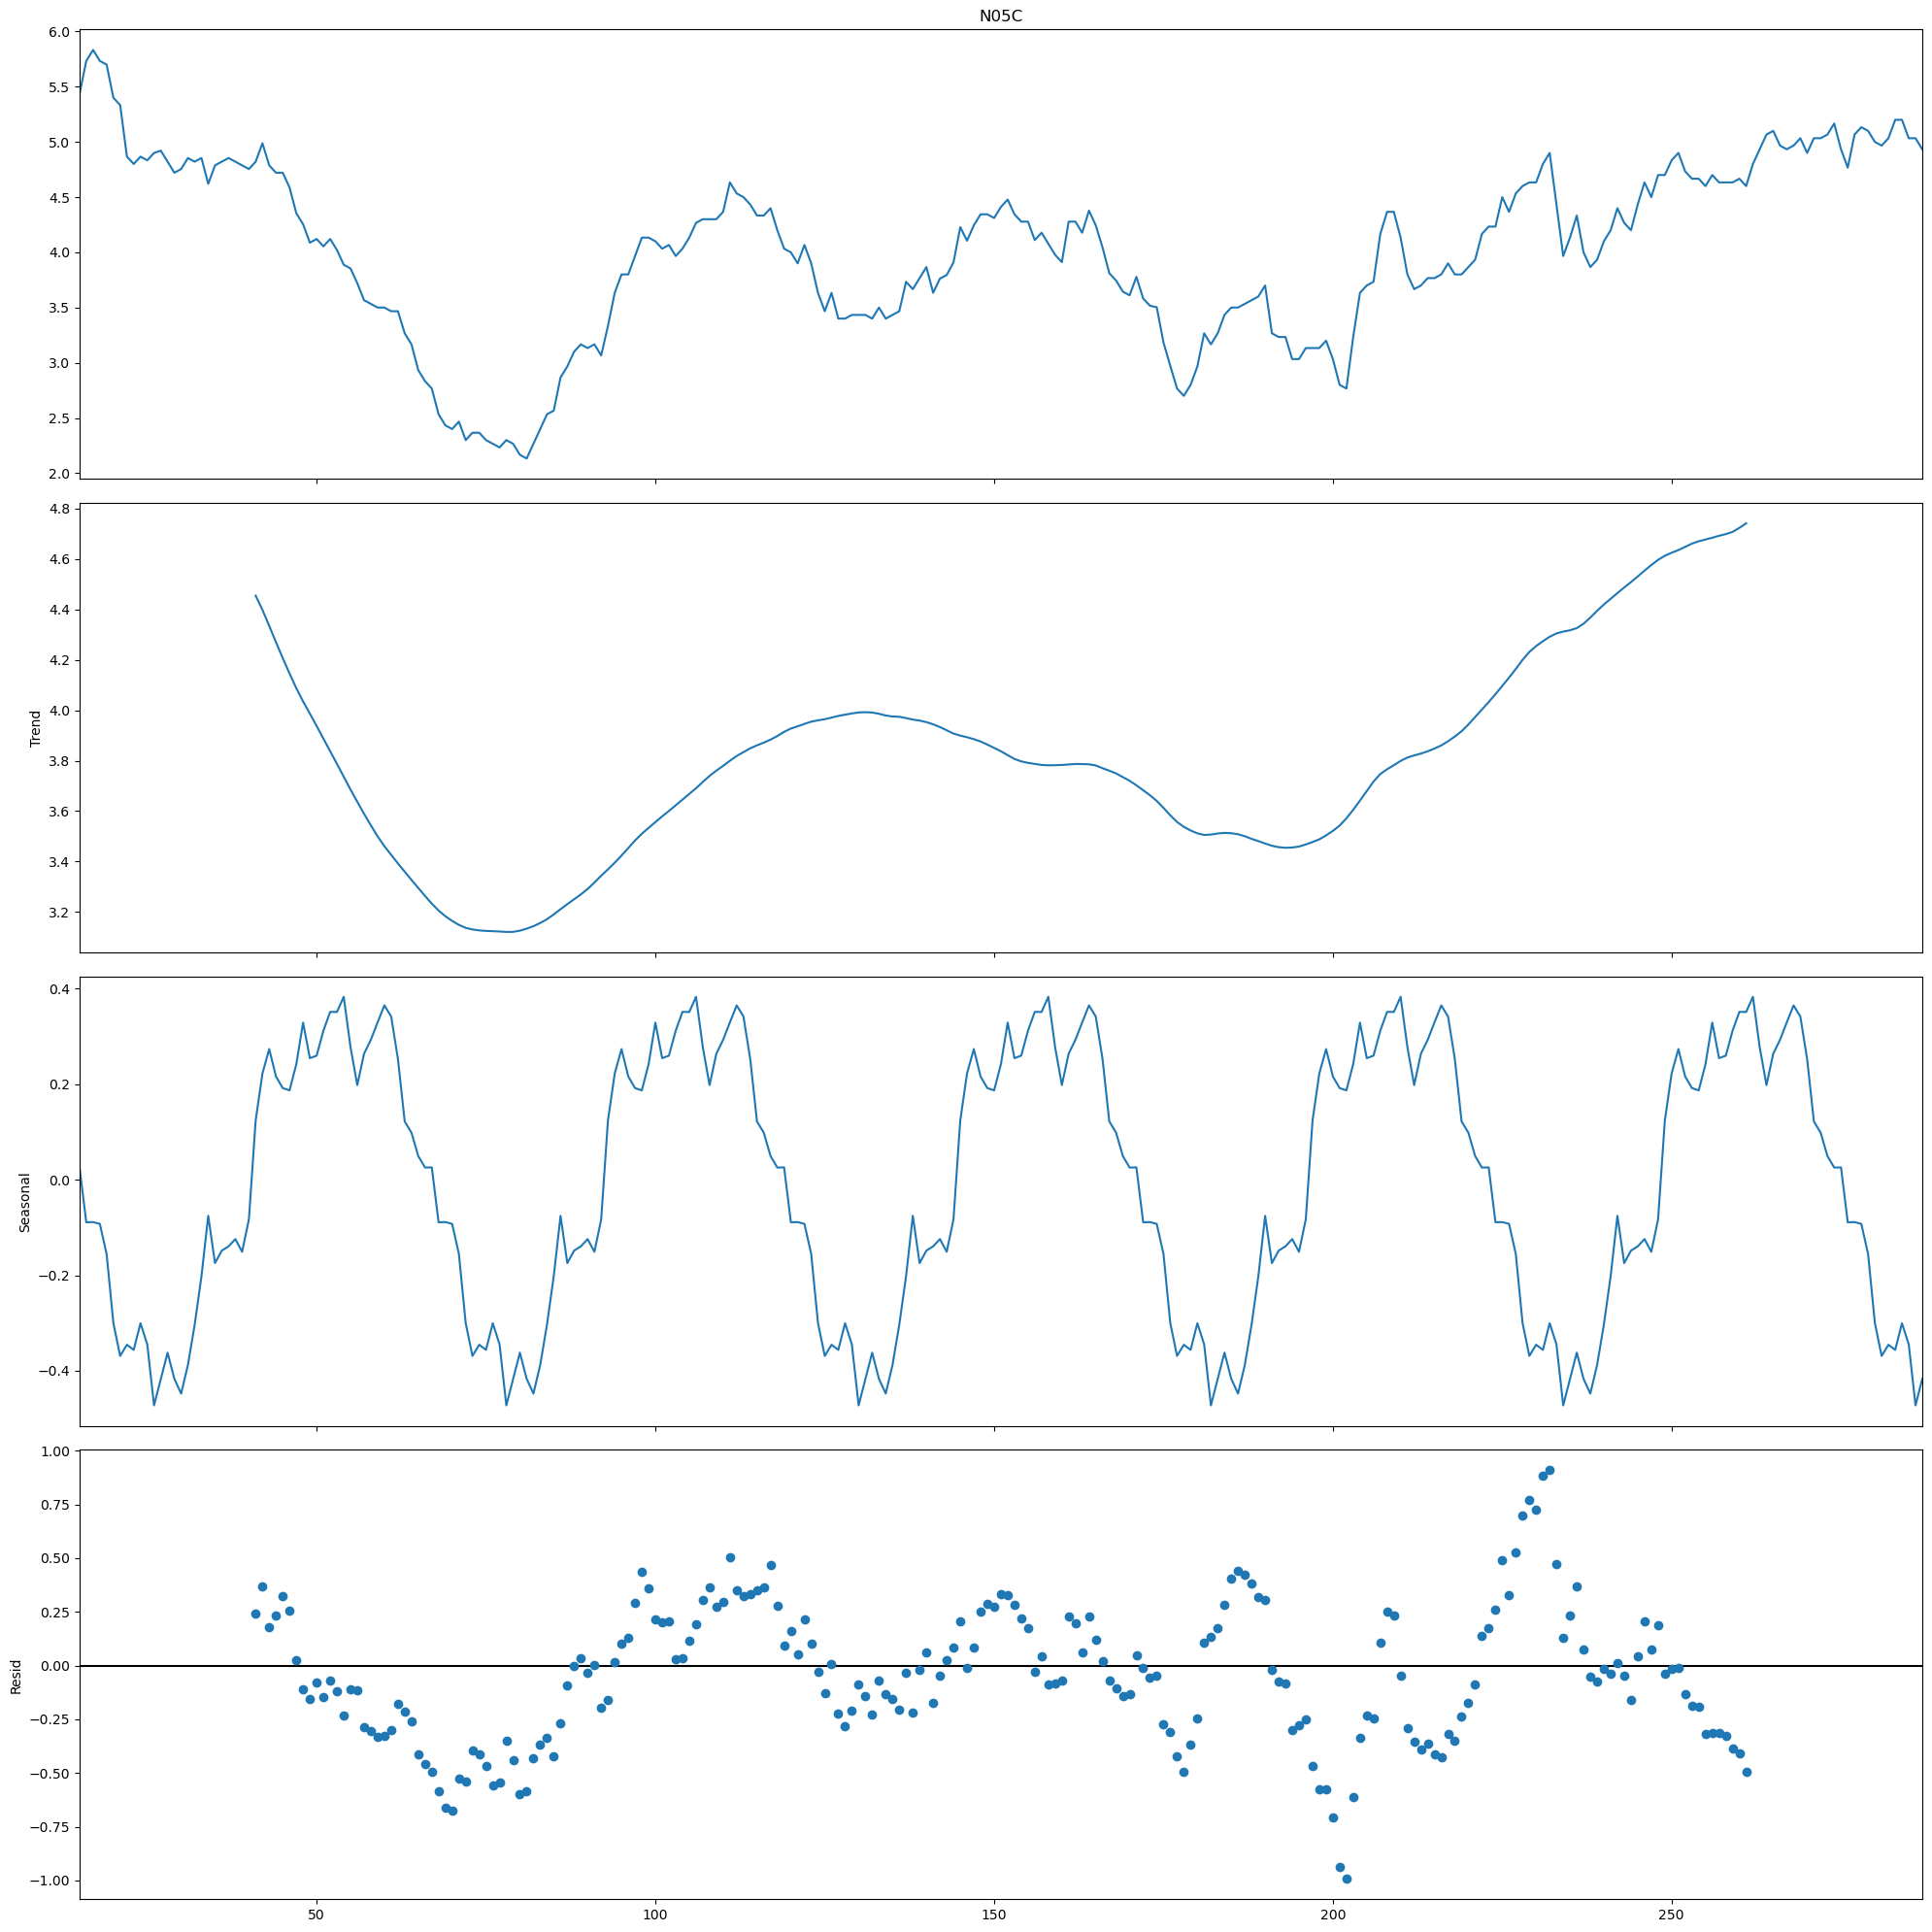

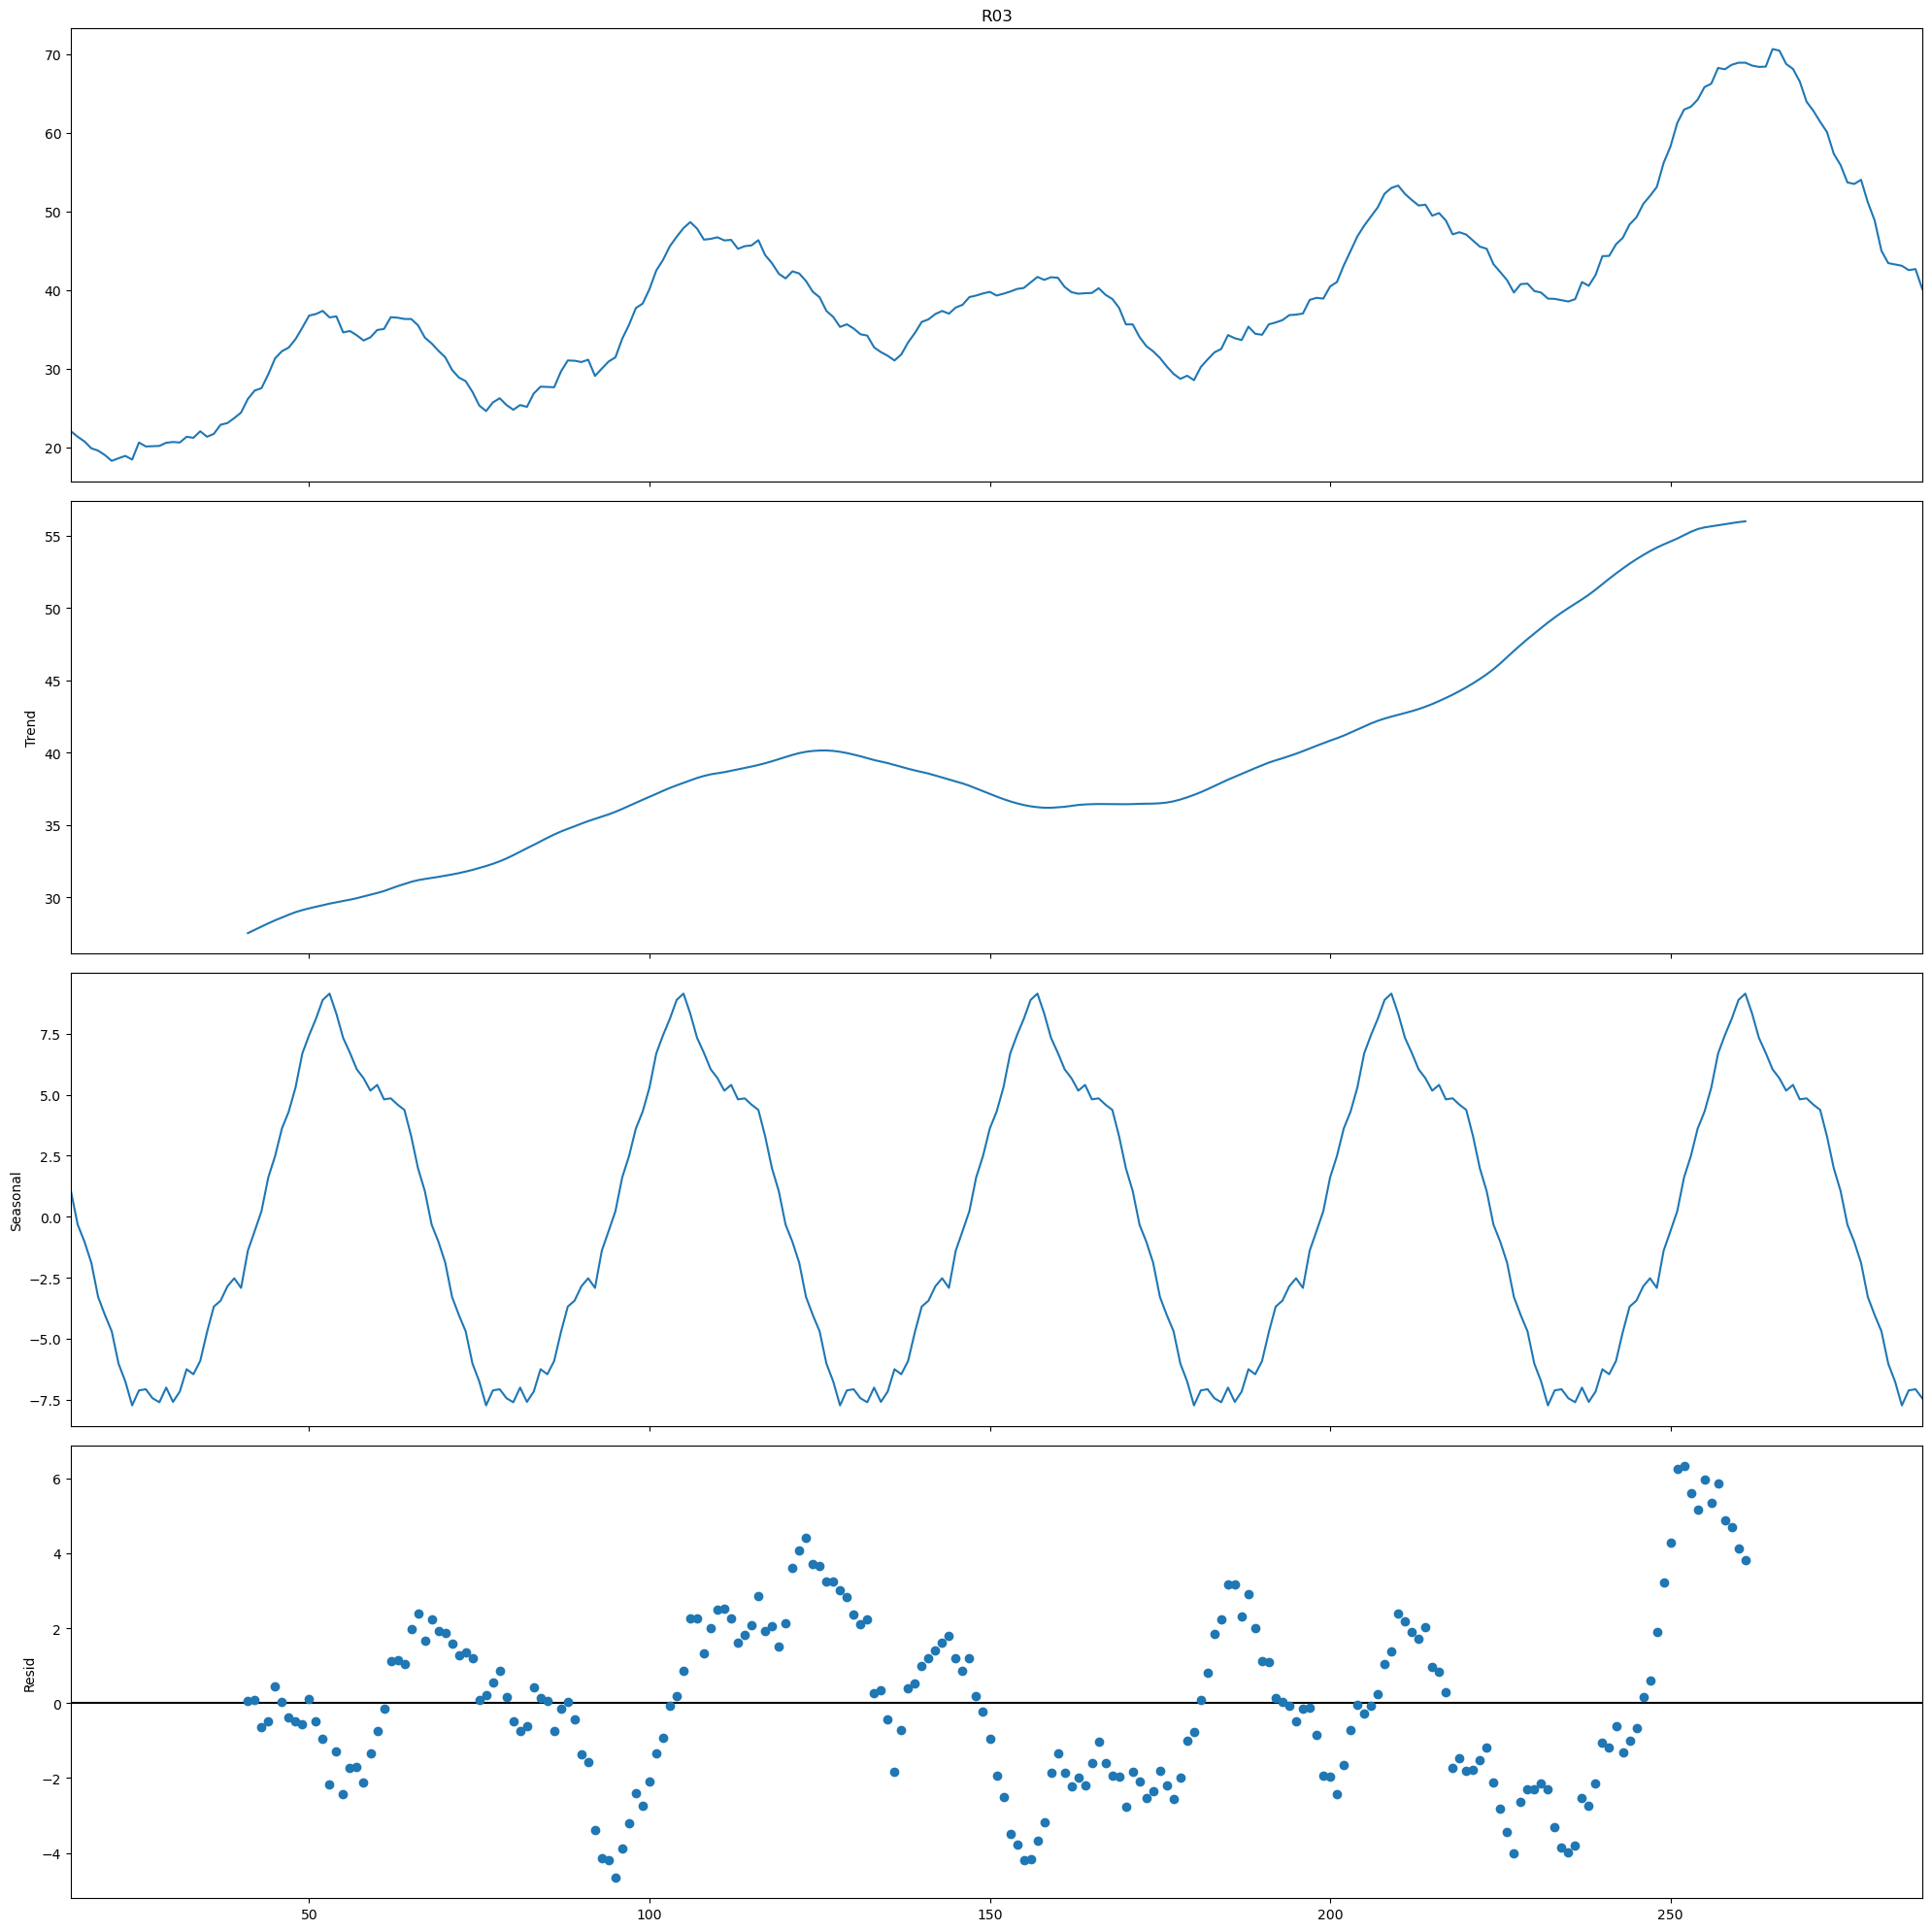

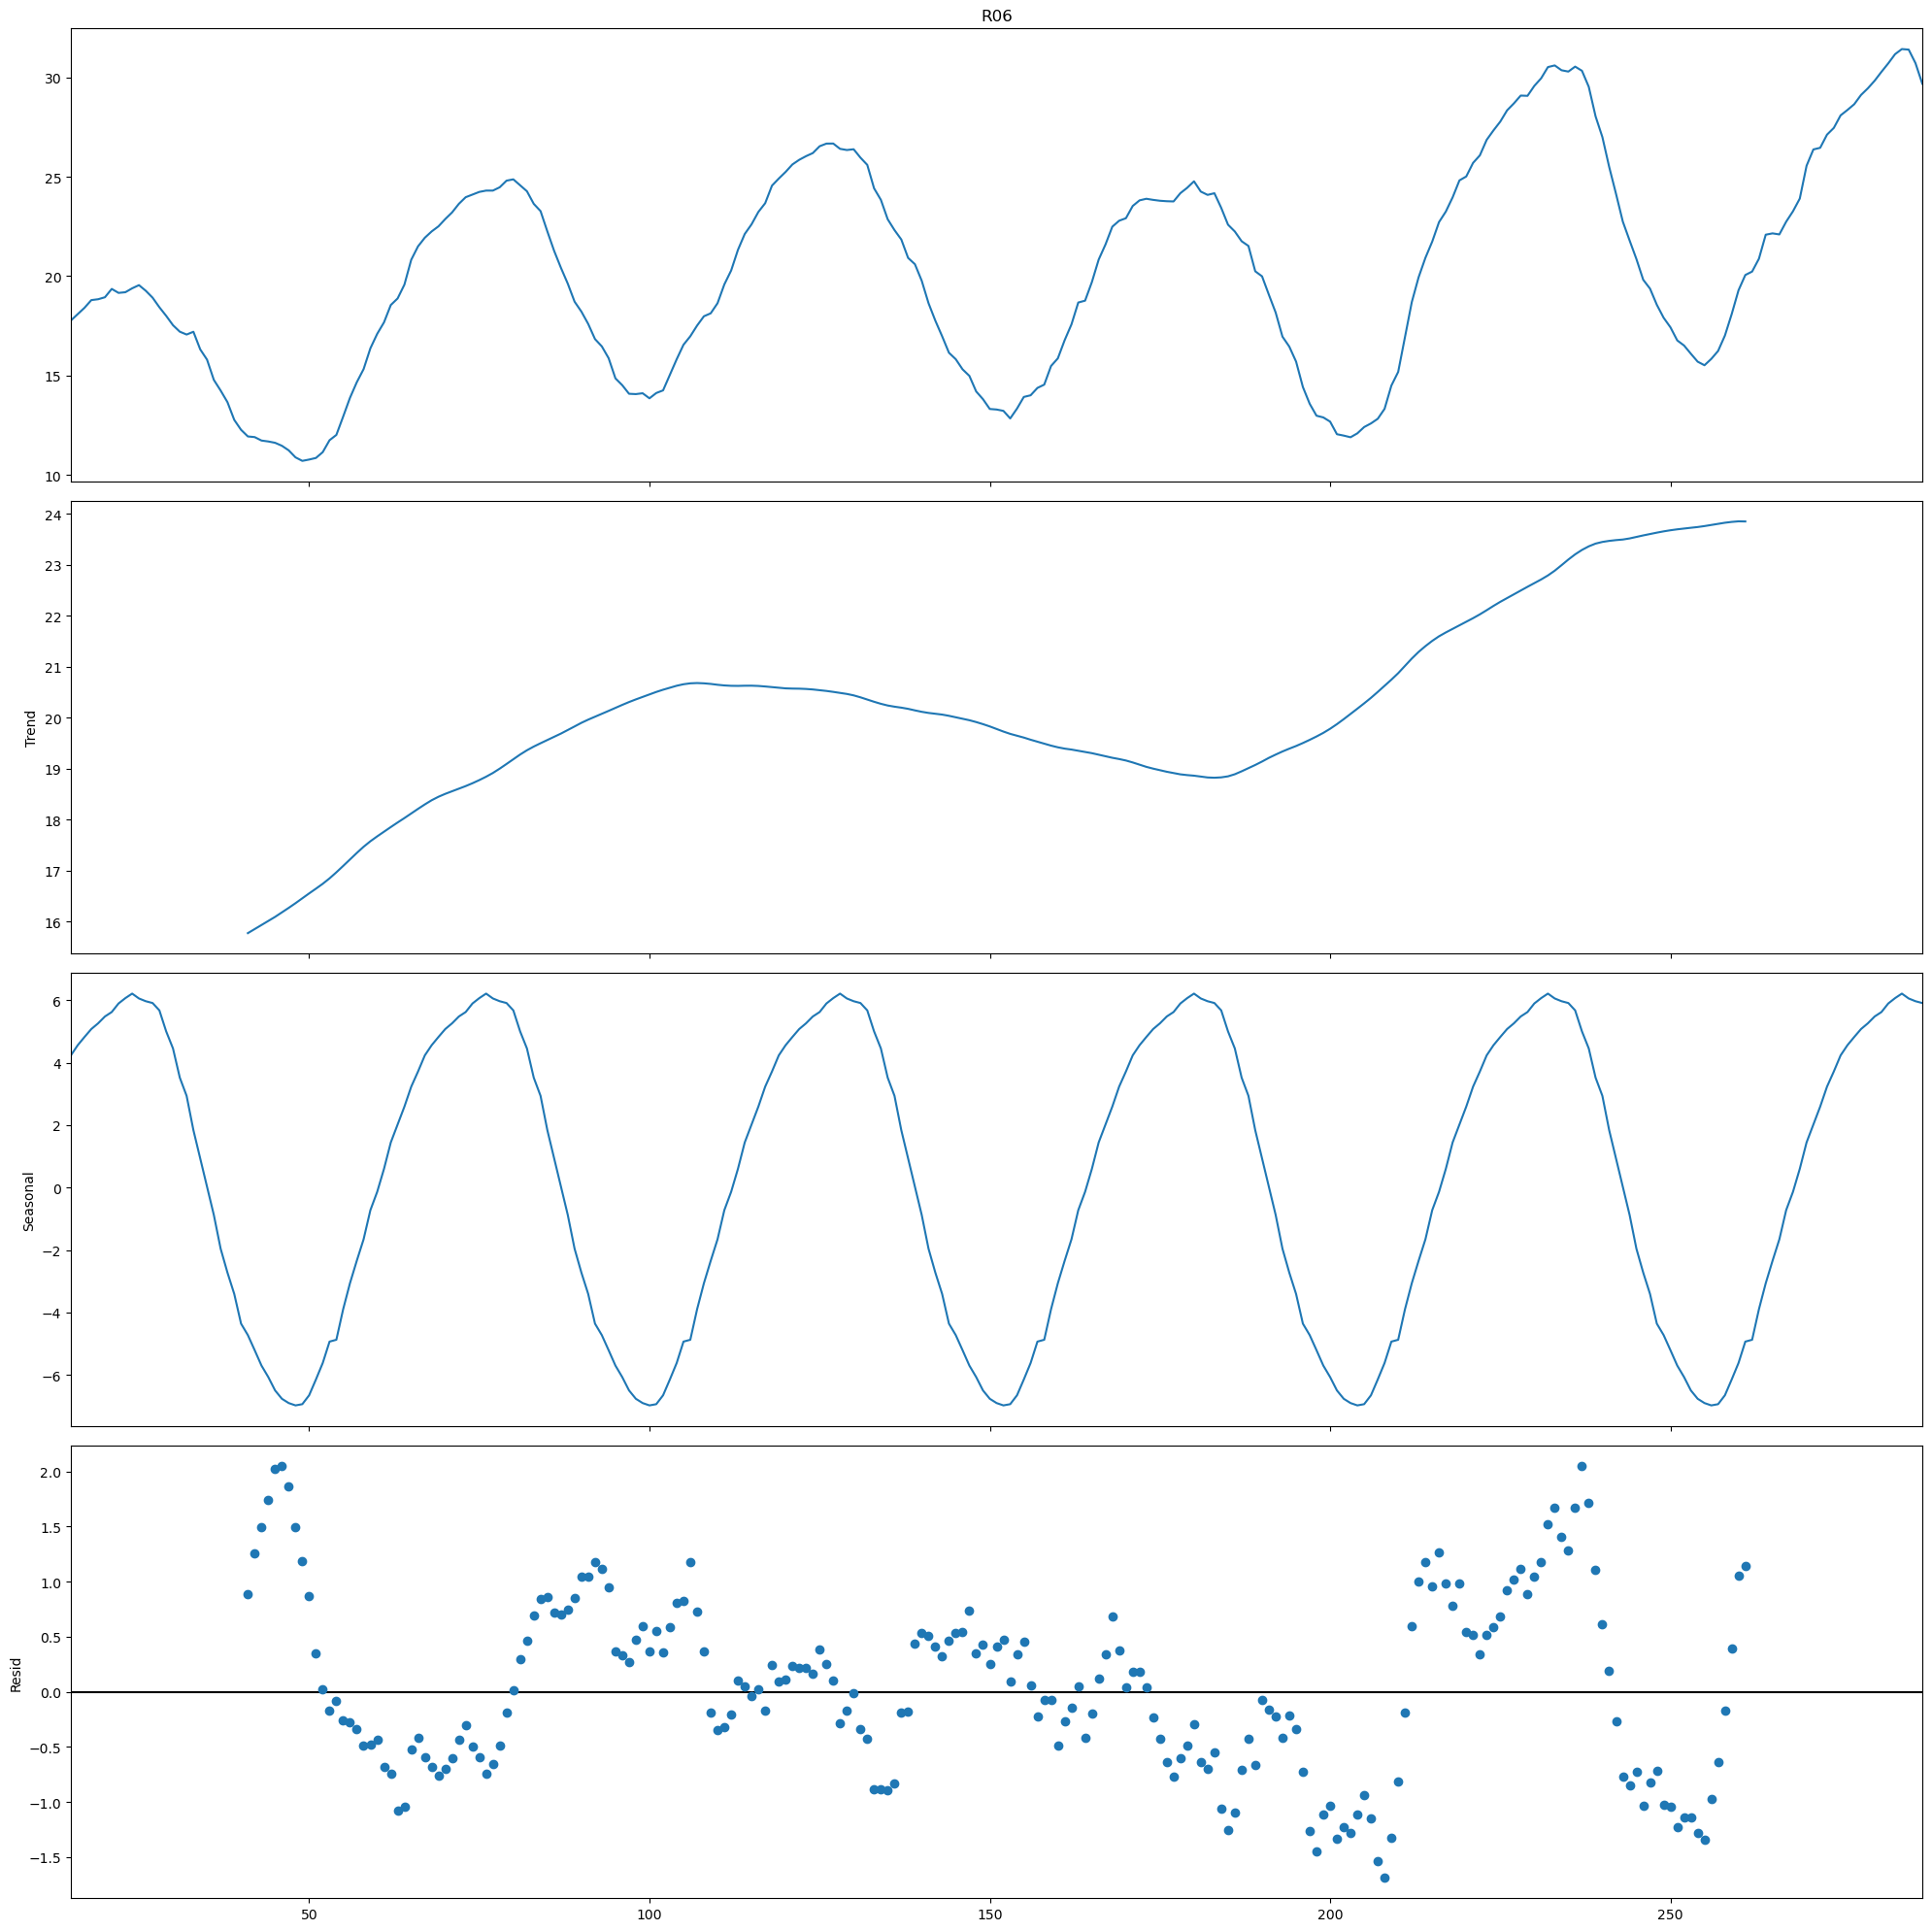

In [23]:
# Decomposition based on 30 day rolling means

for drug in drugs:
    result = seasonal_decompose(weekly_df[drug].rolling(window=30, center=True).mean().dropna(), period=52, model='additive')
    plt.rcParams["figure.figsize"] = (20,20)
    result.plot()
    plt.show()

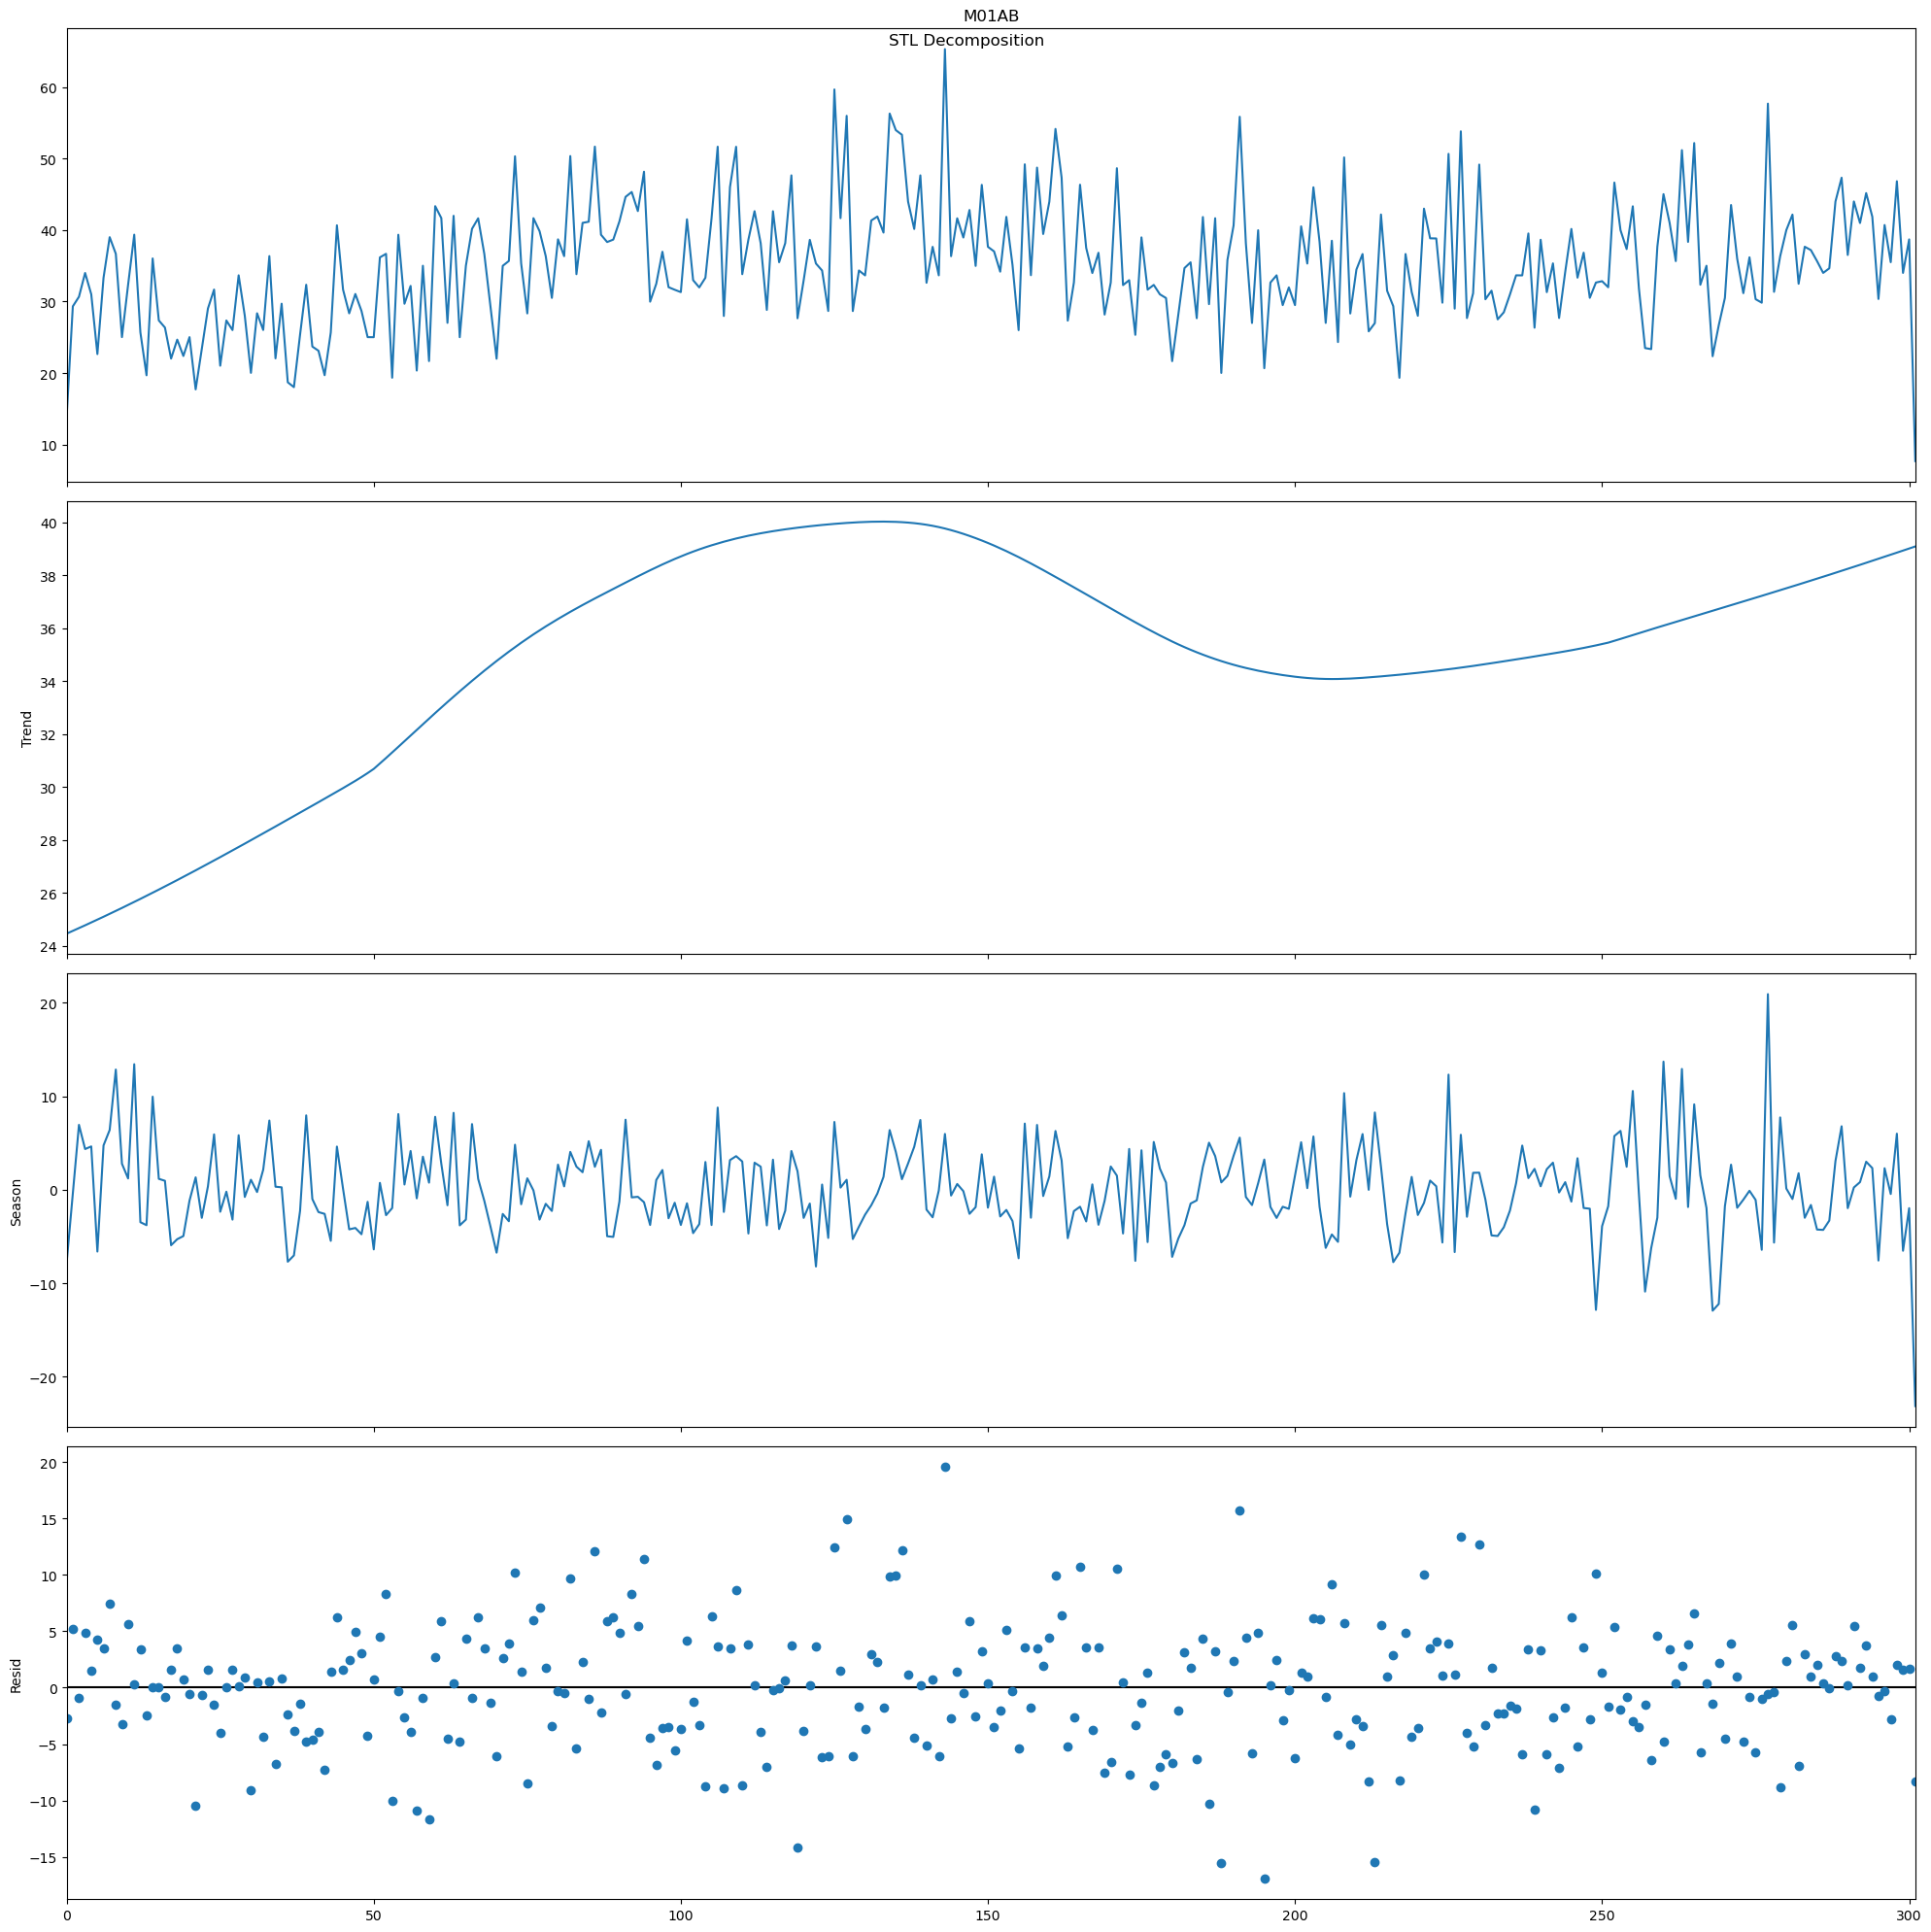

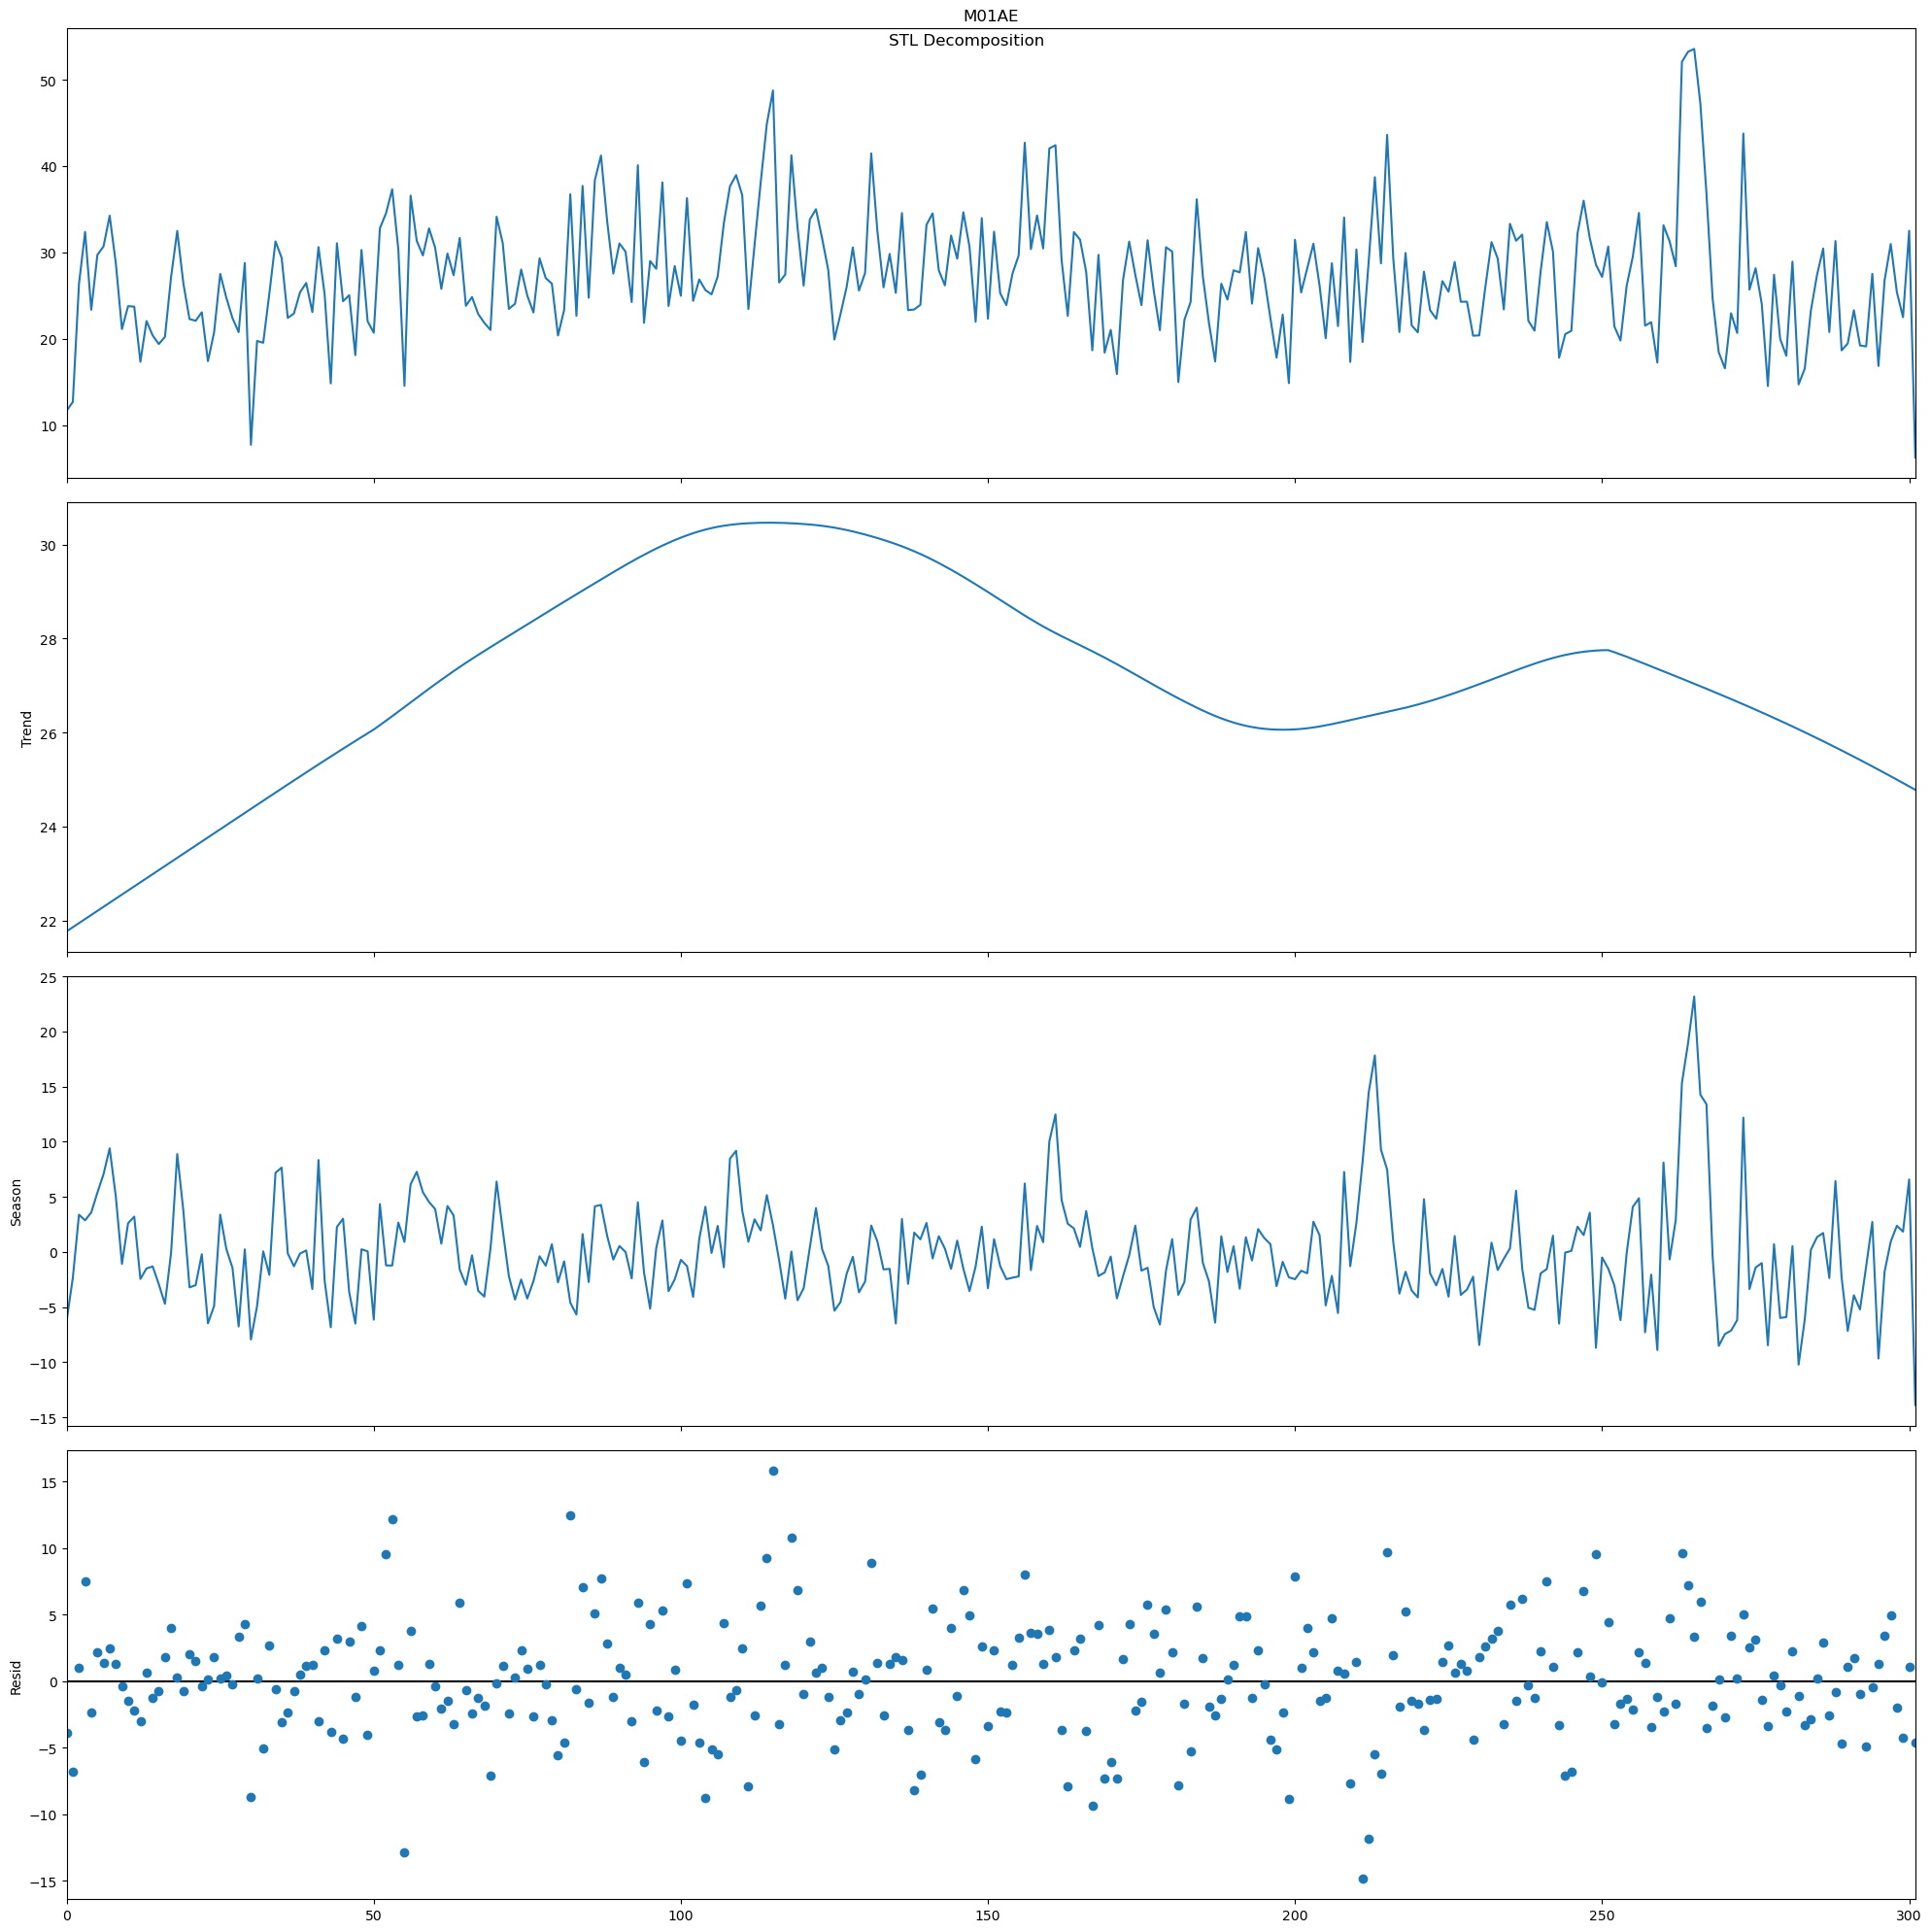

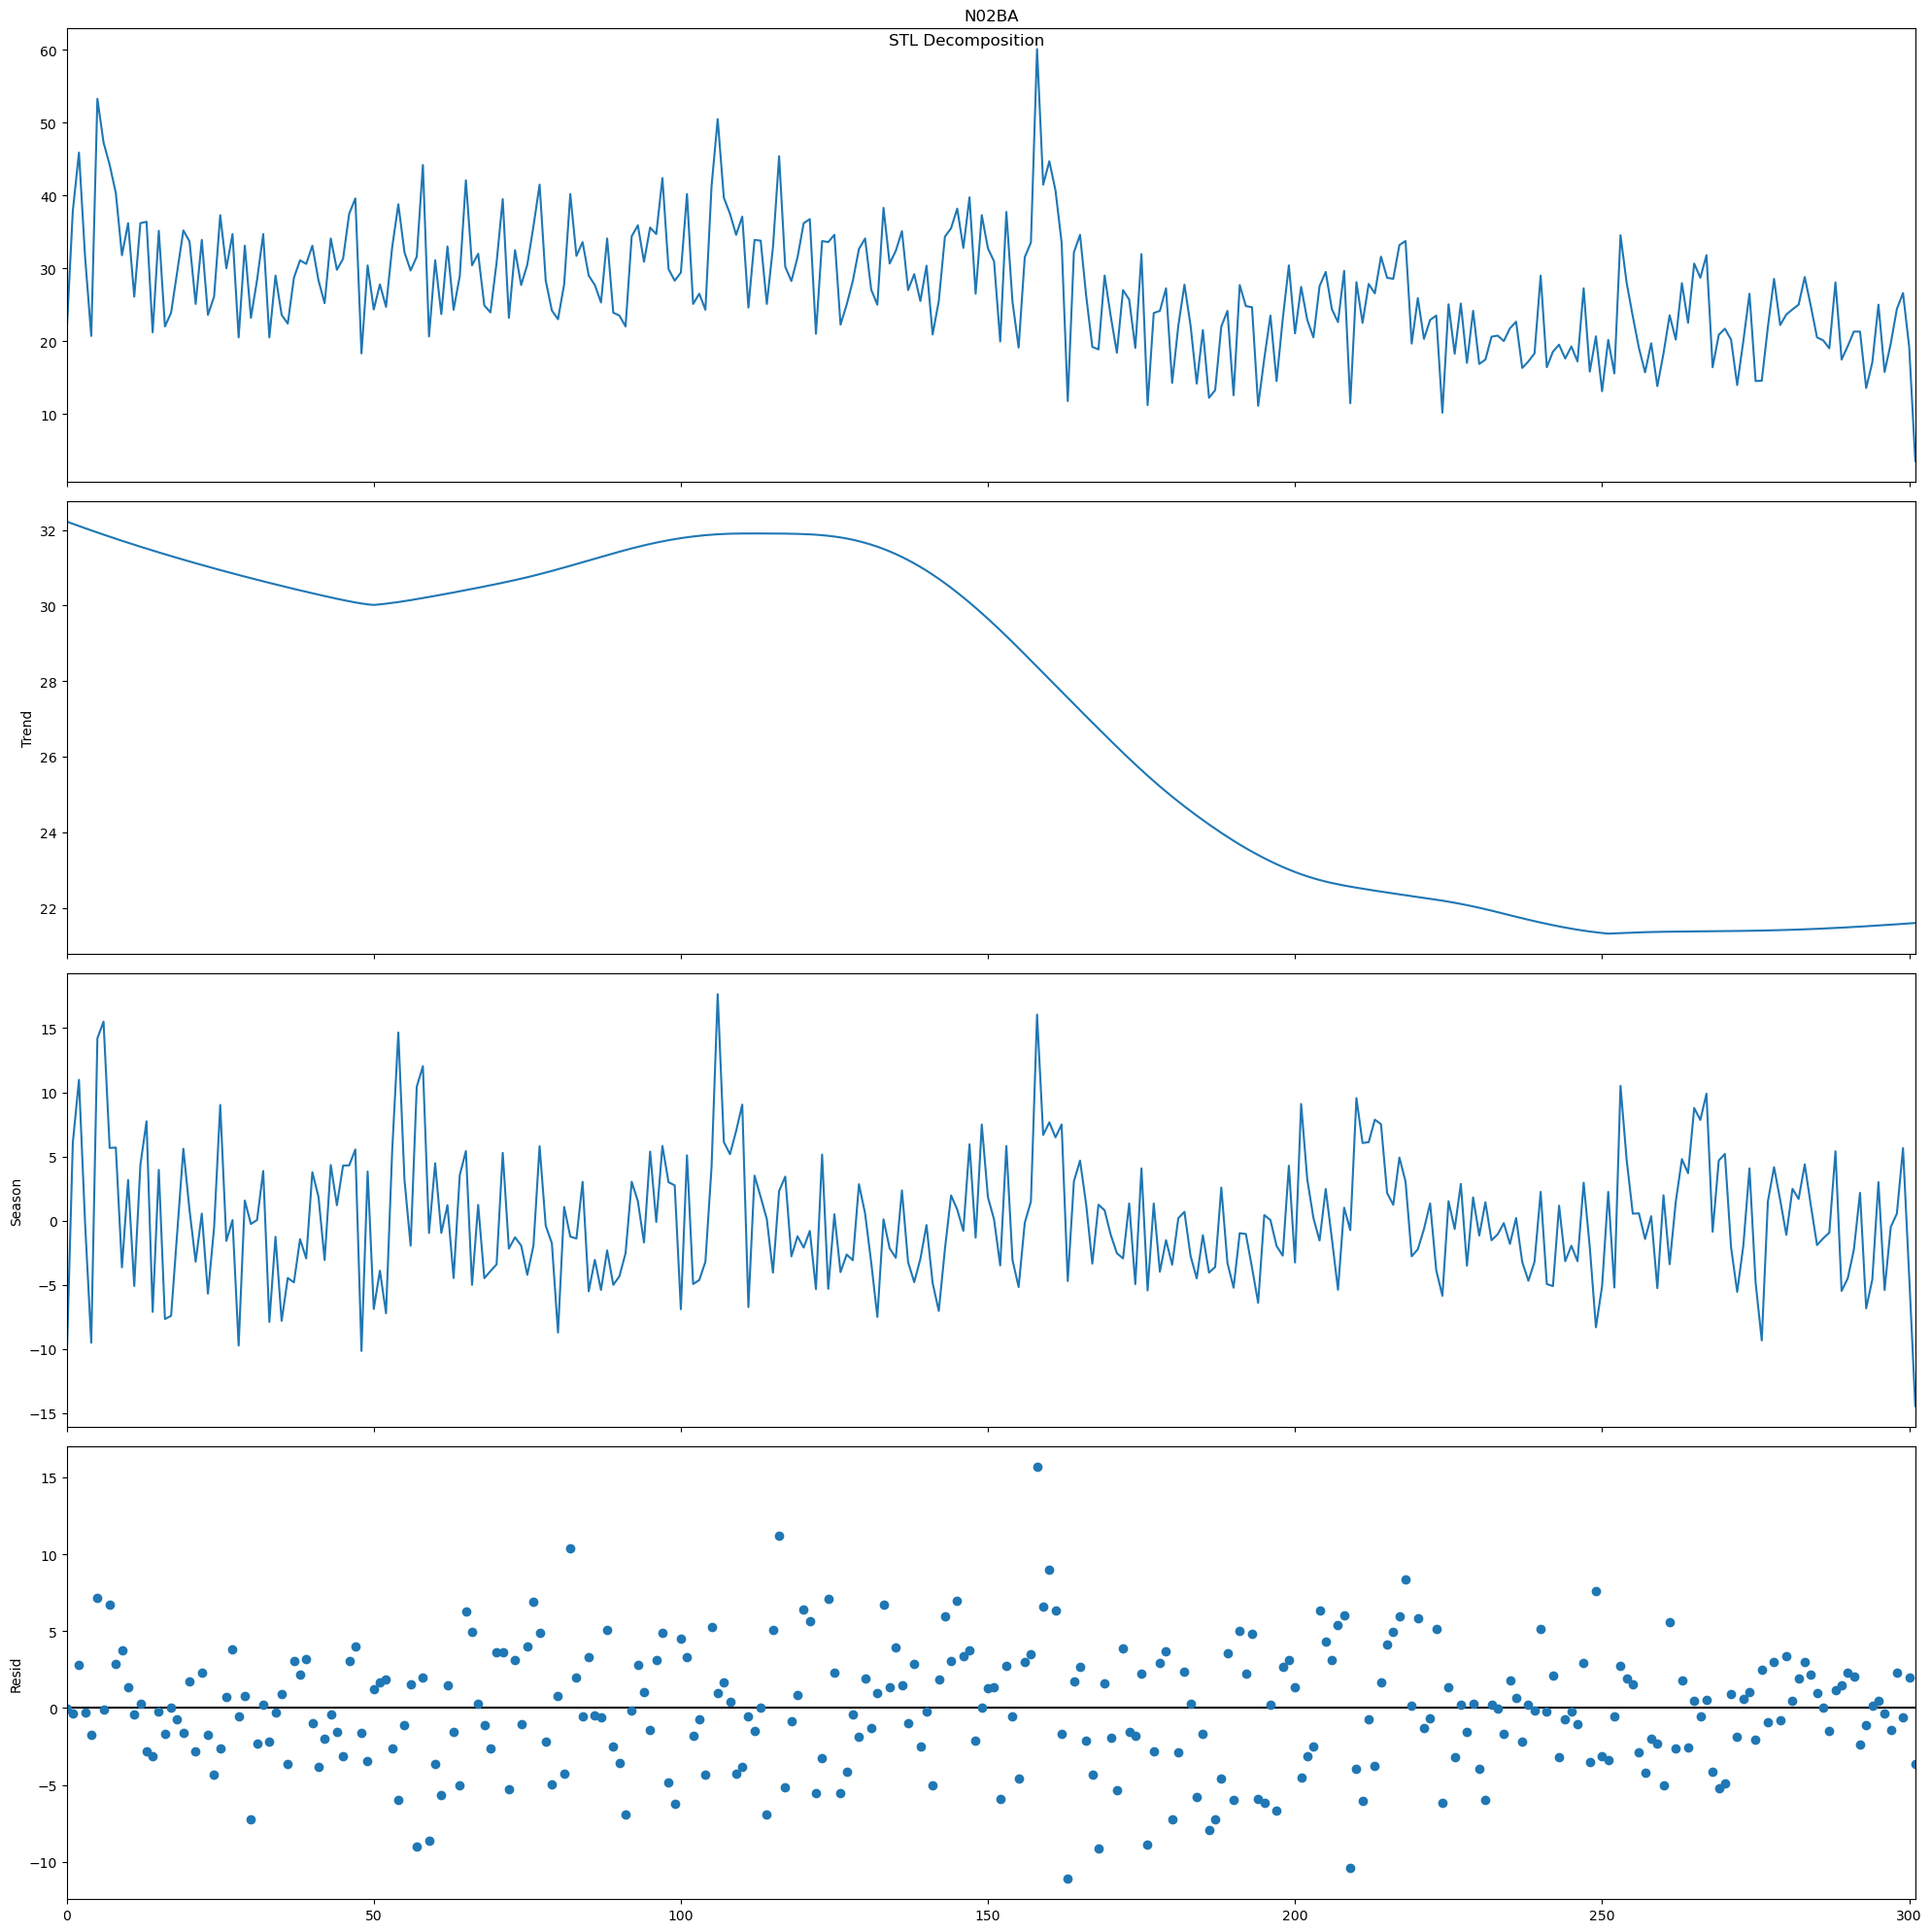

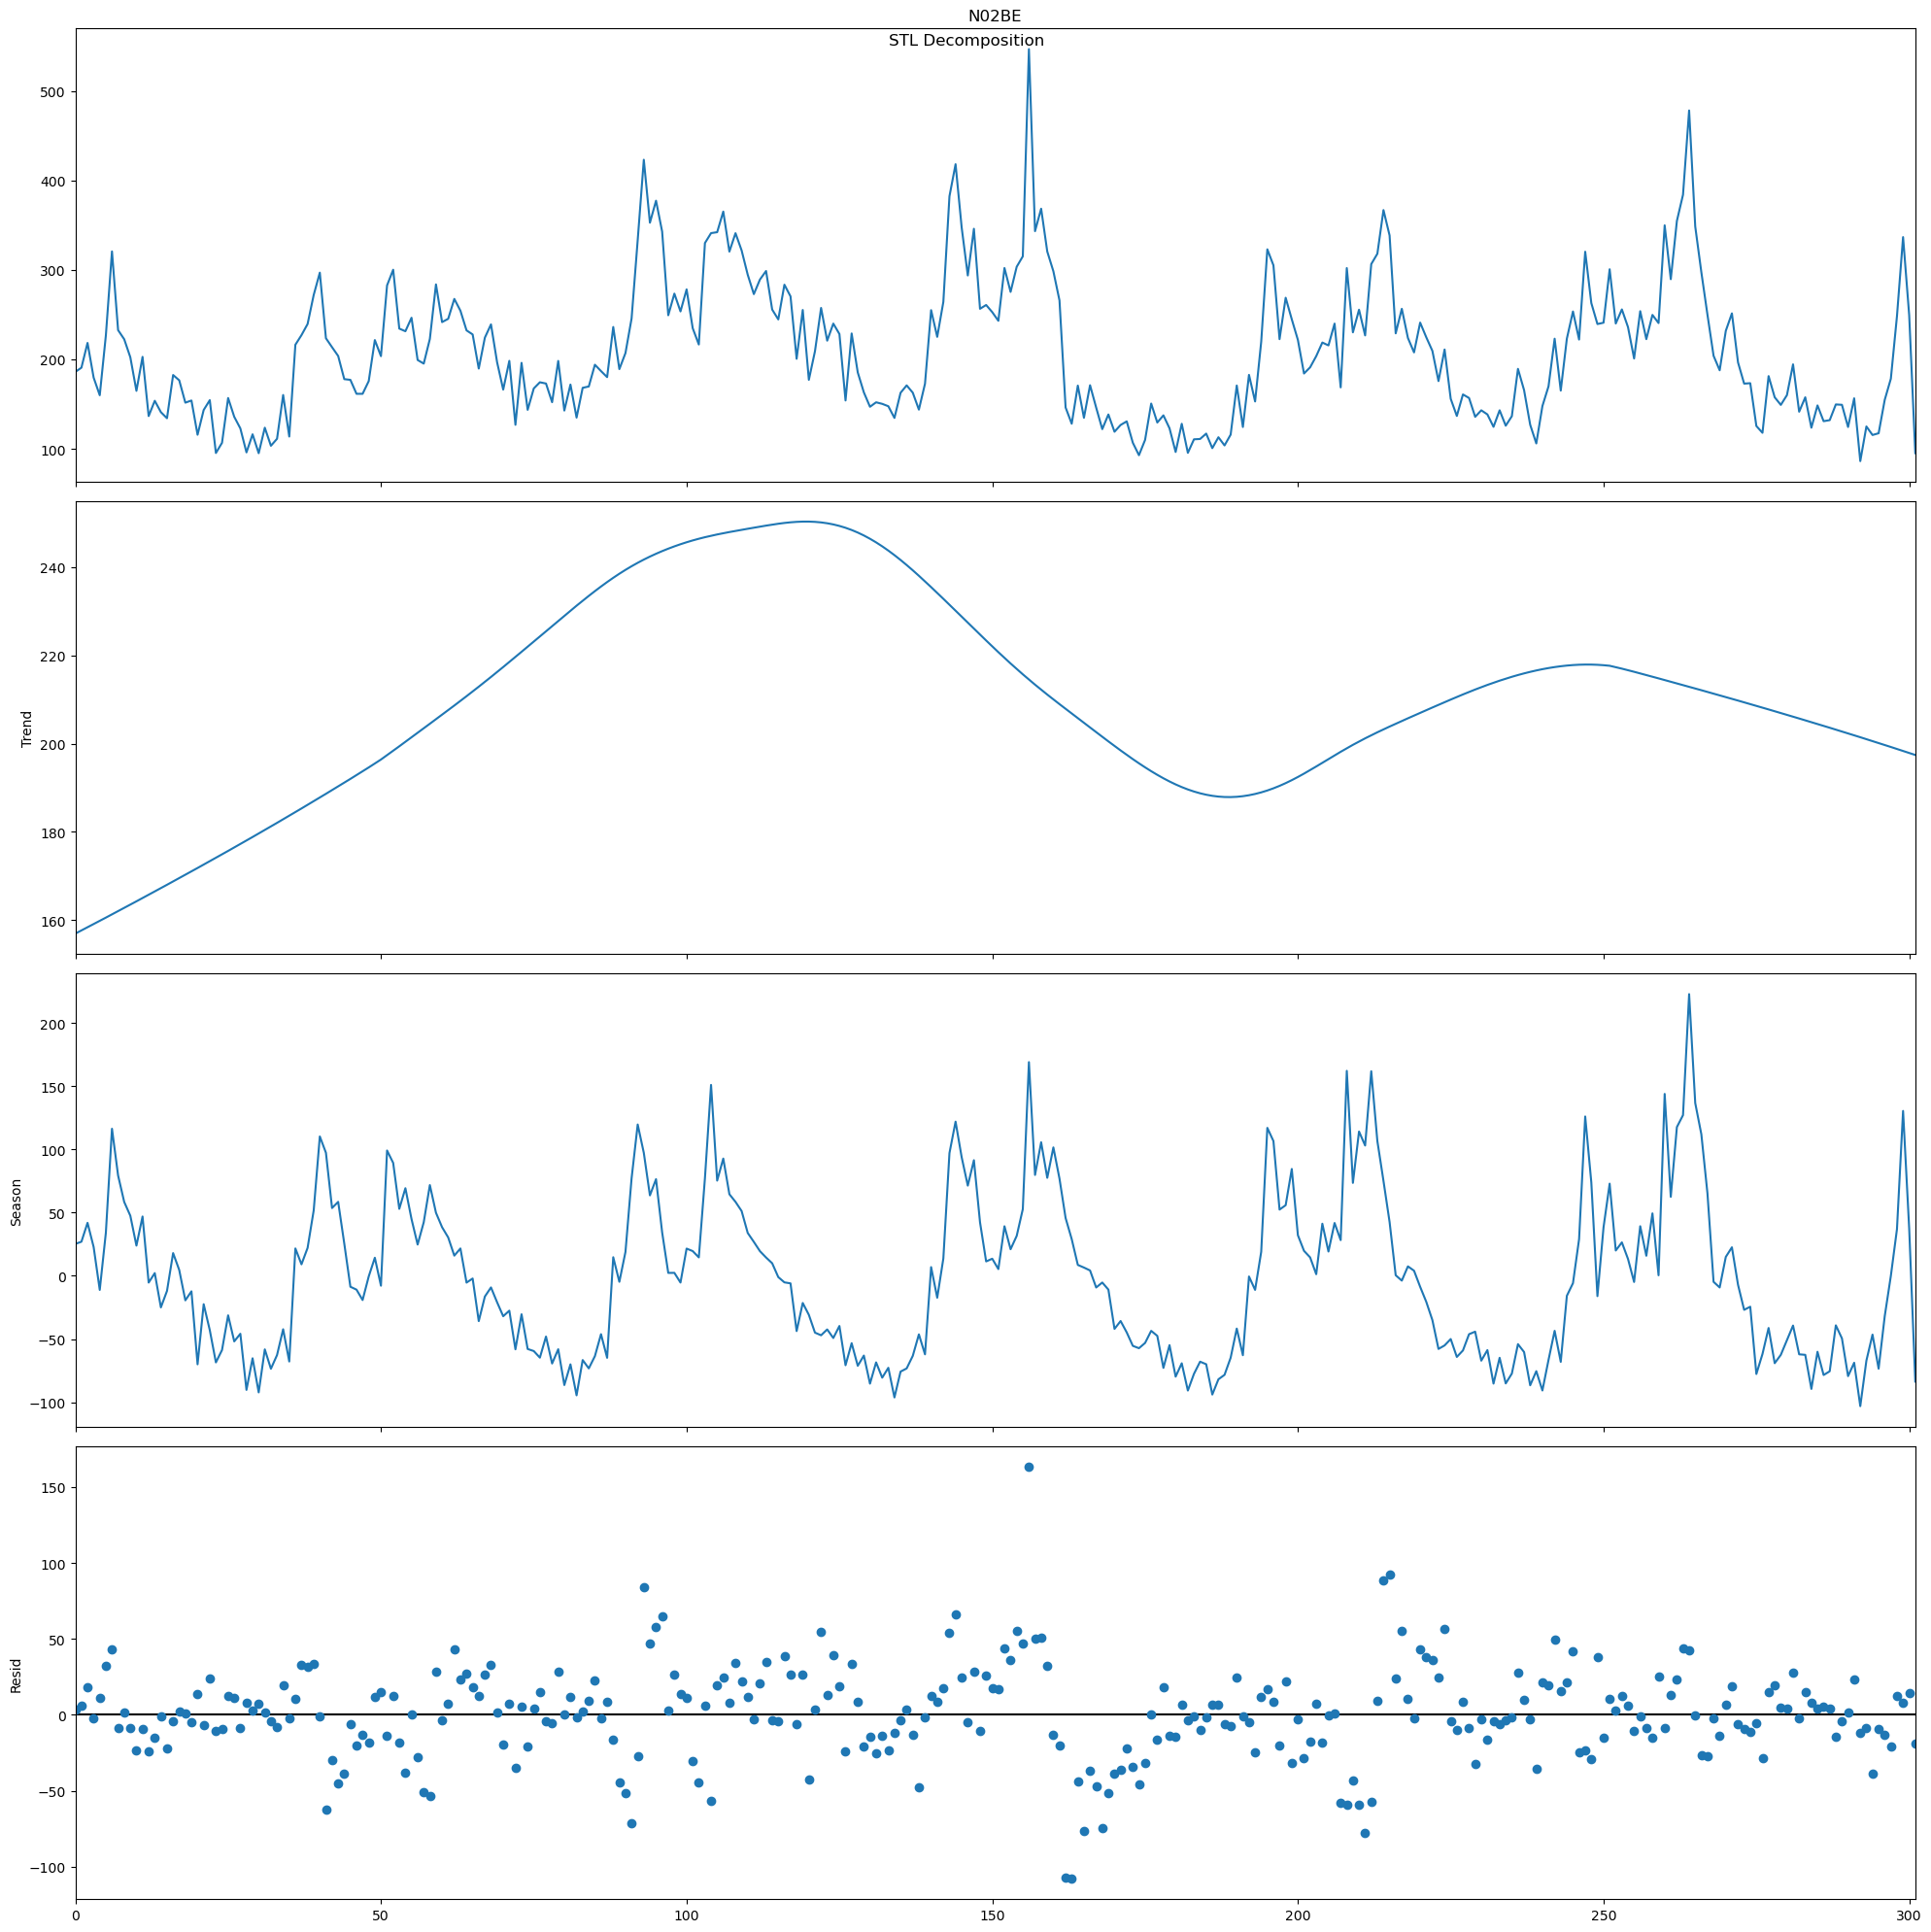

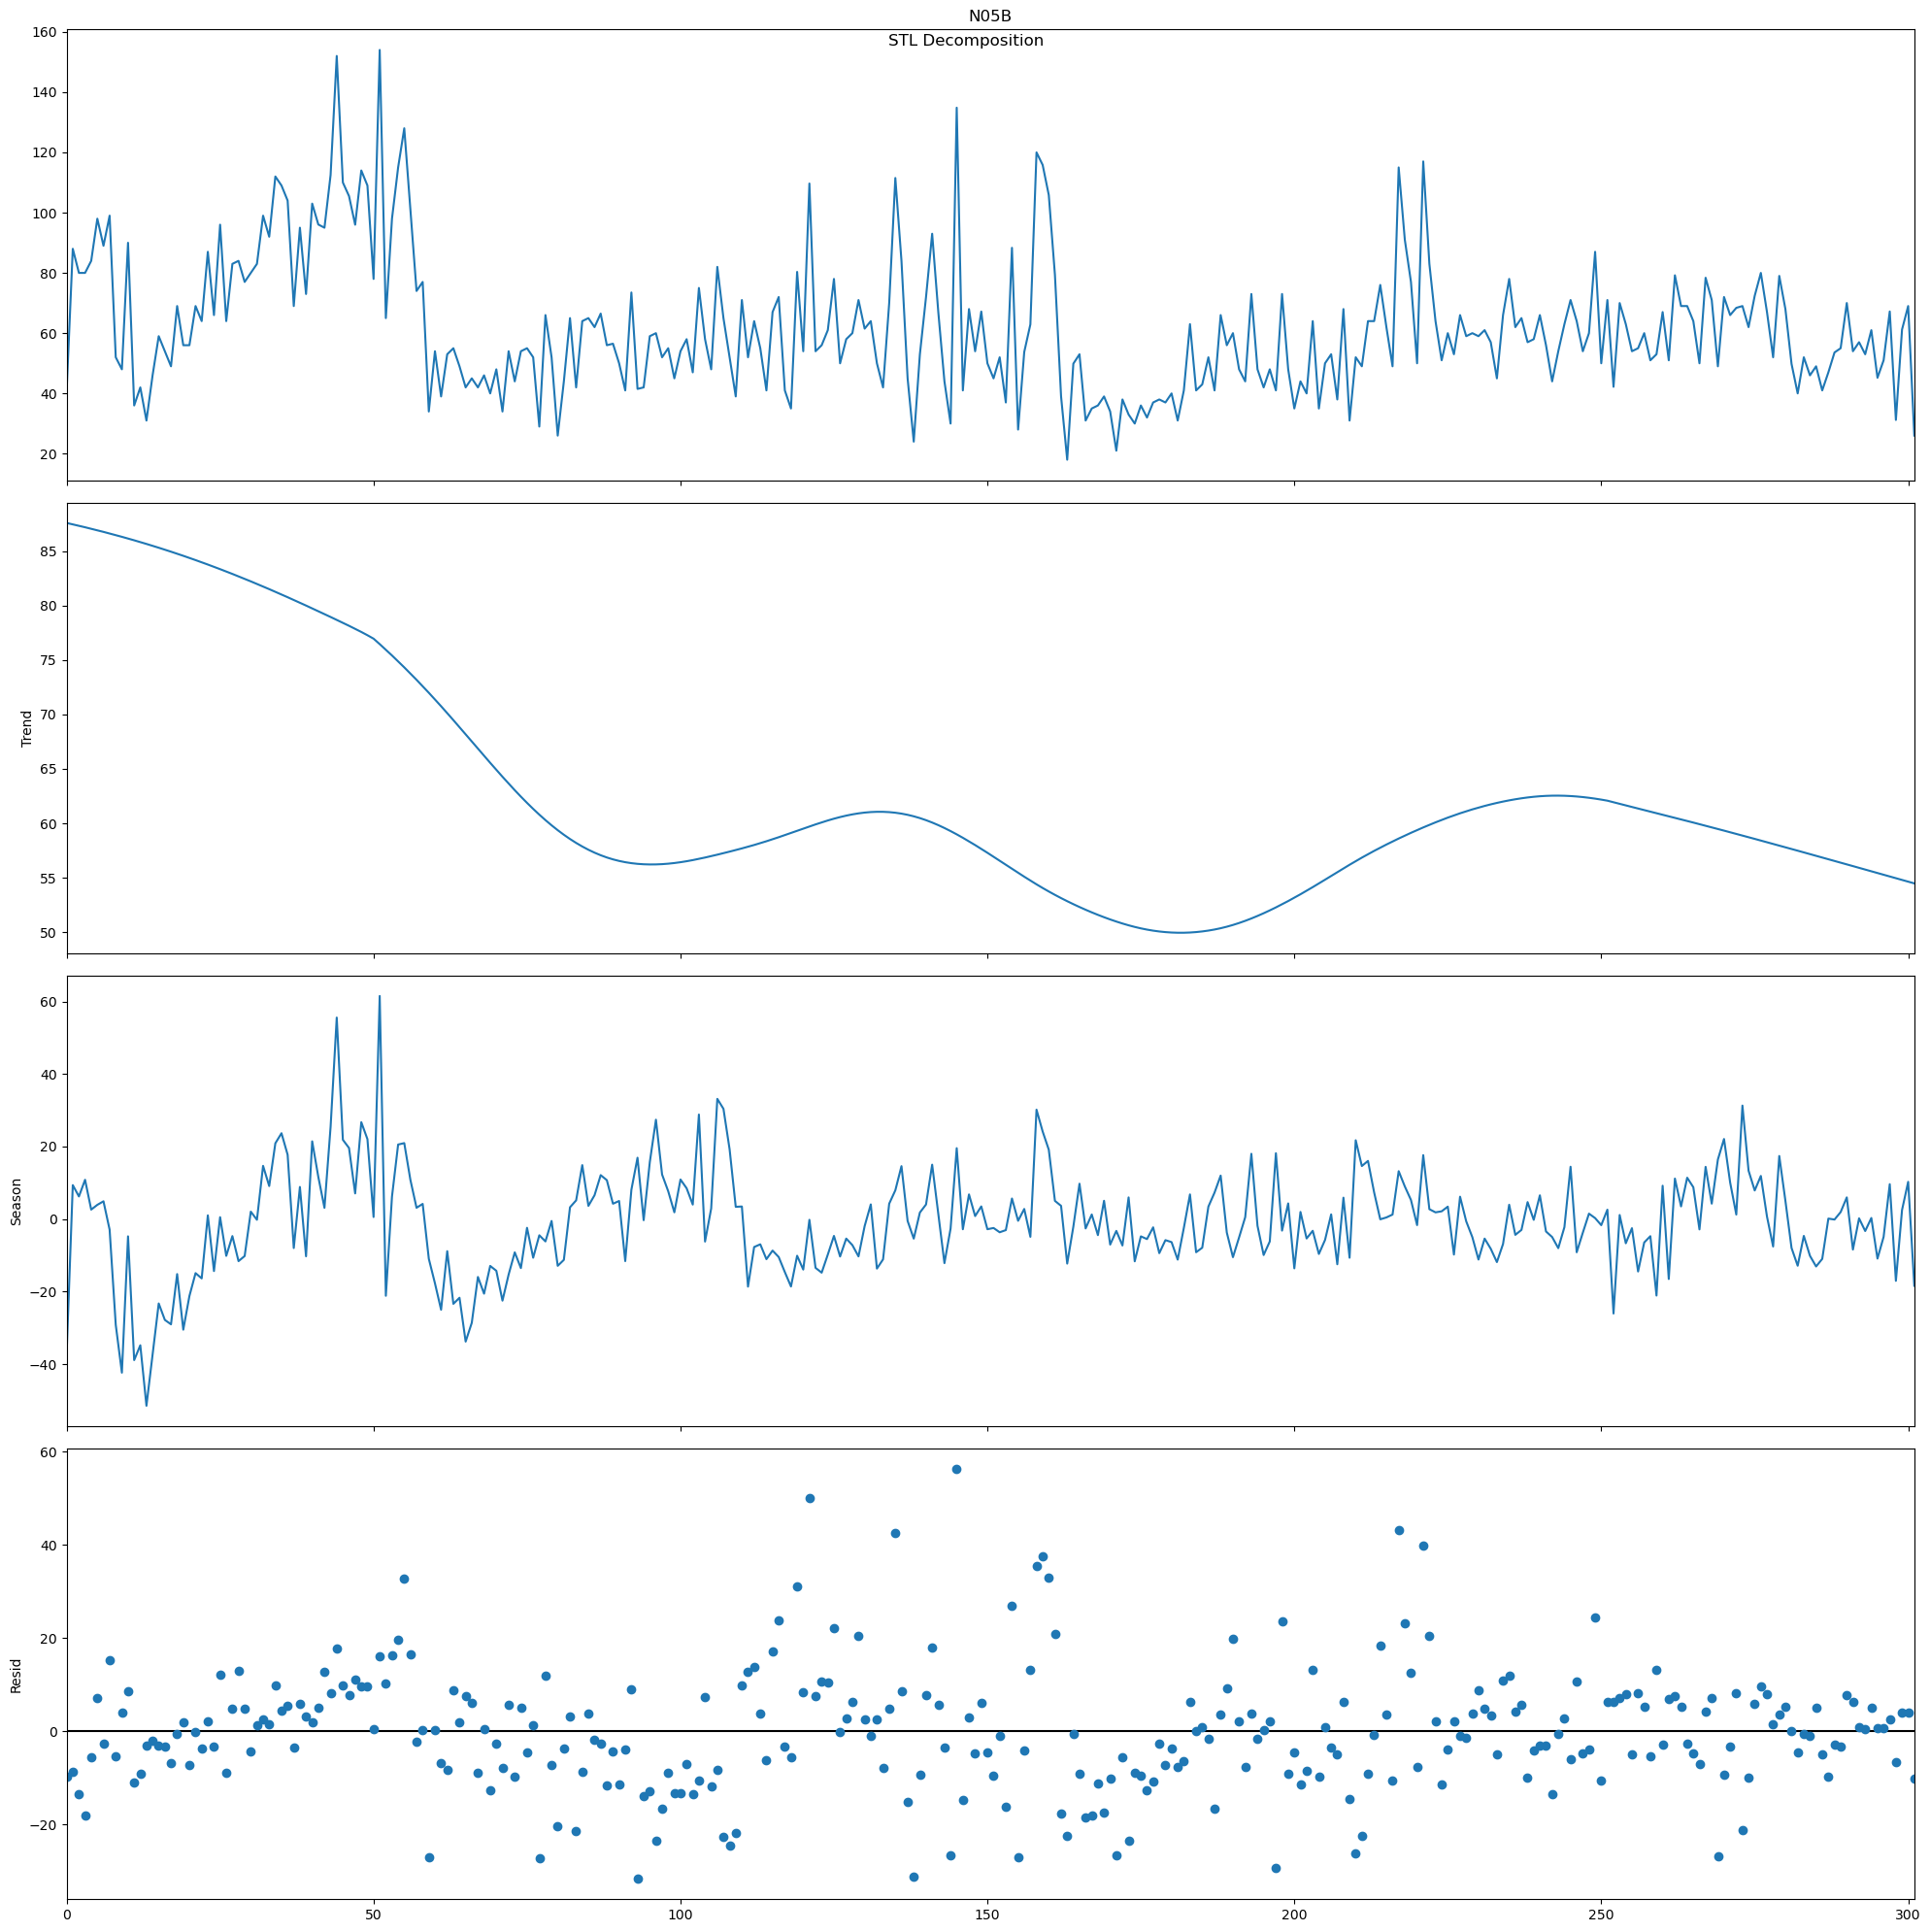

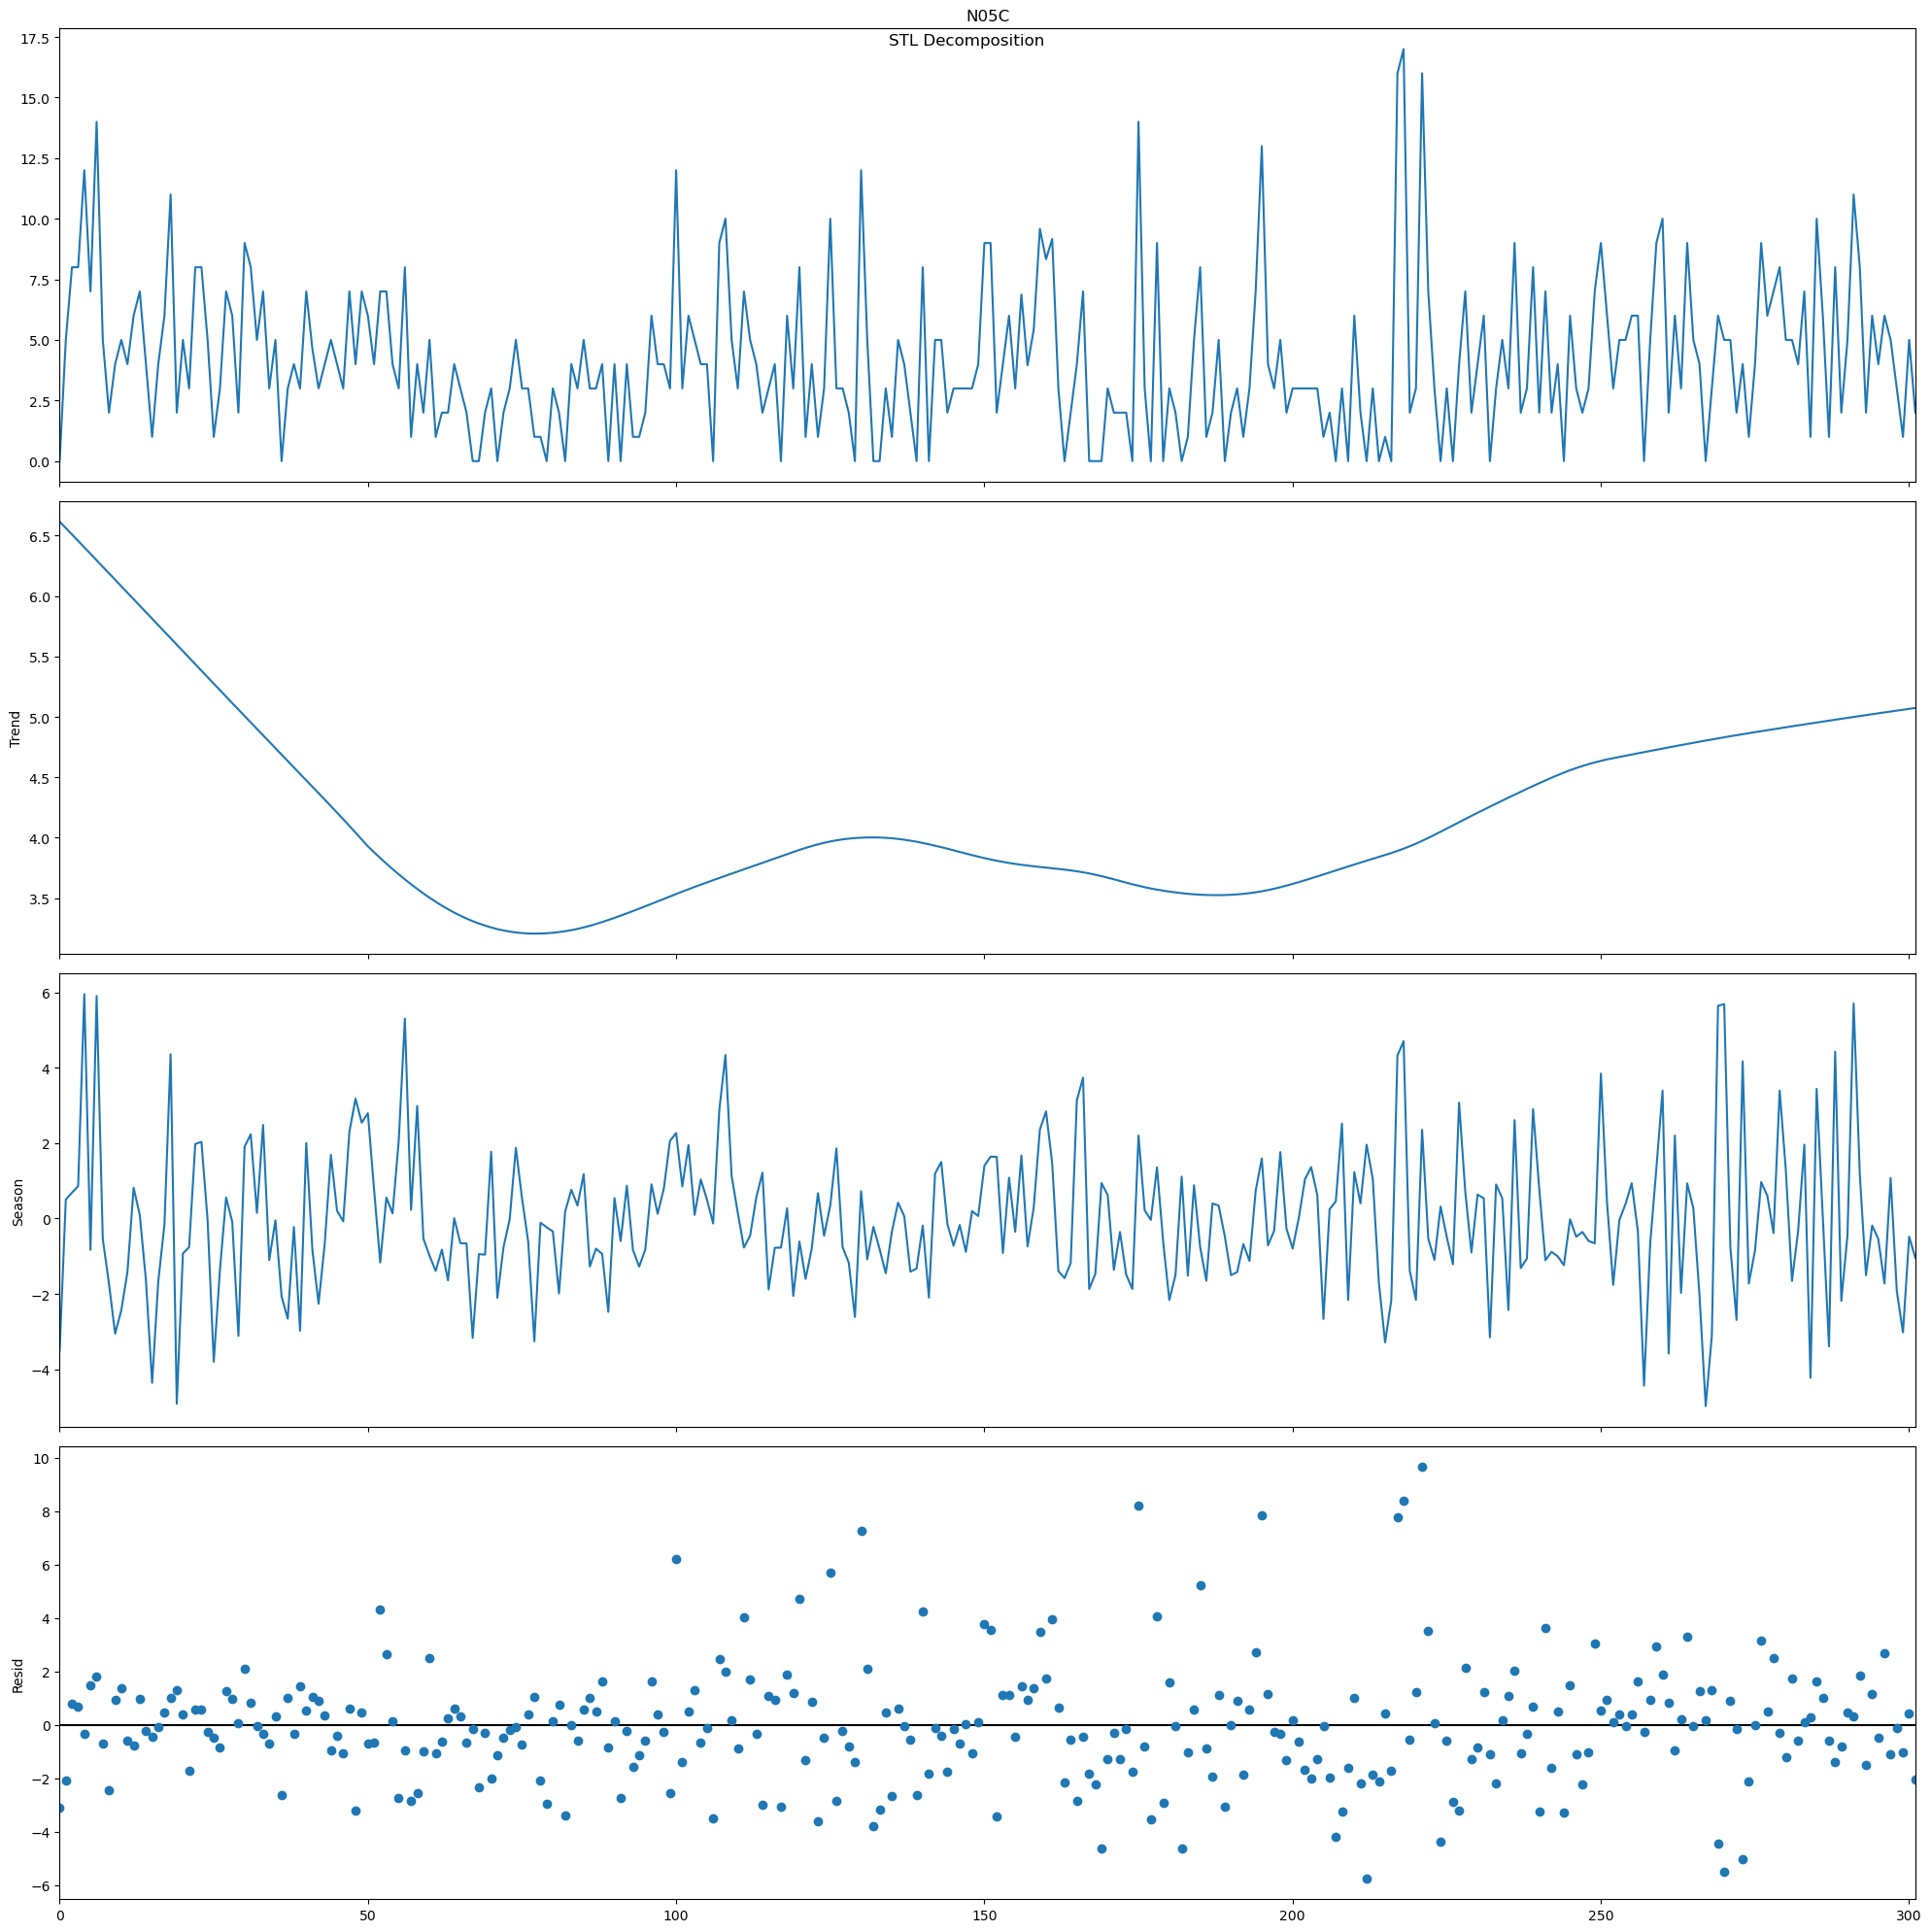

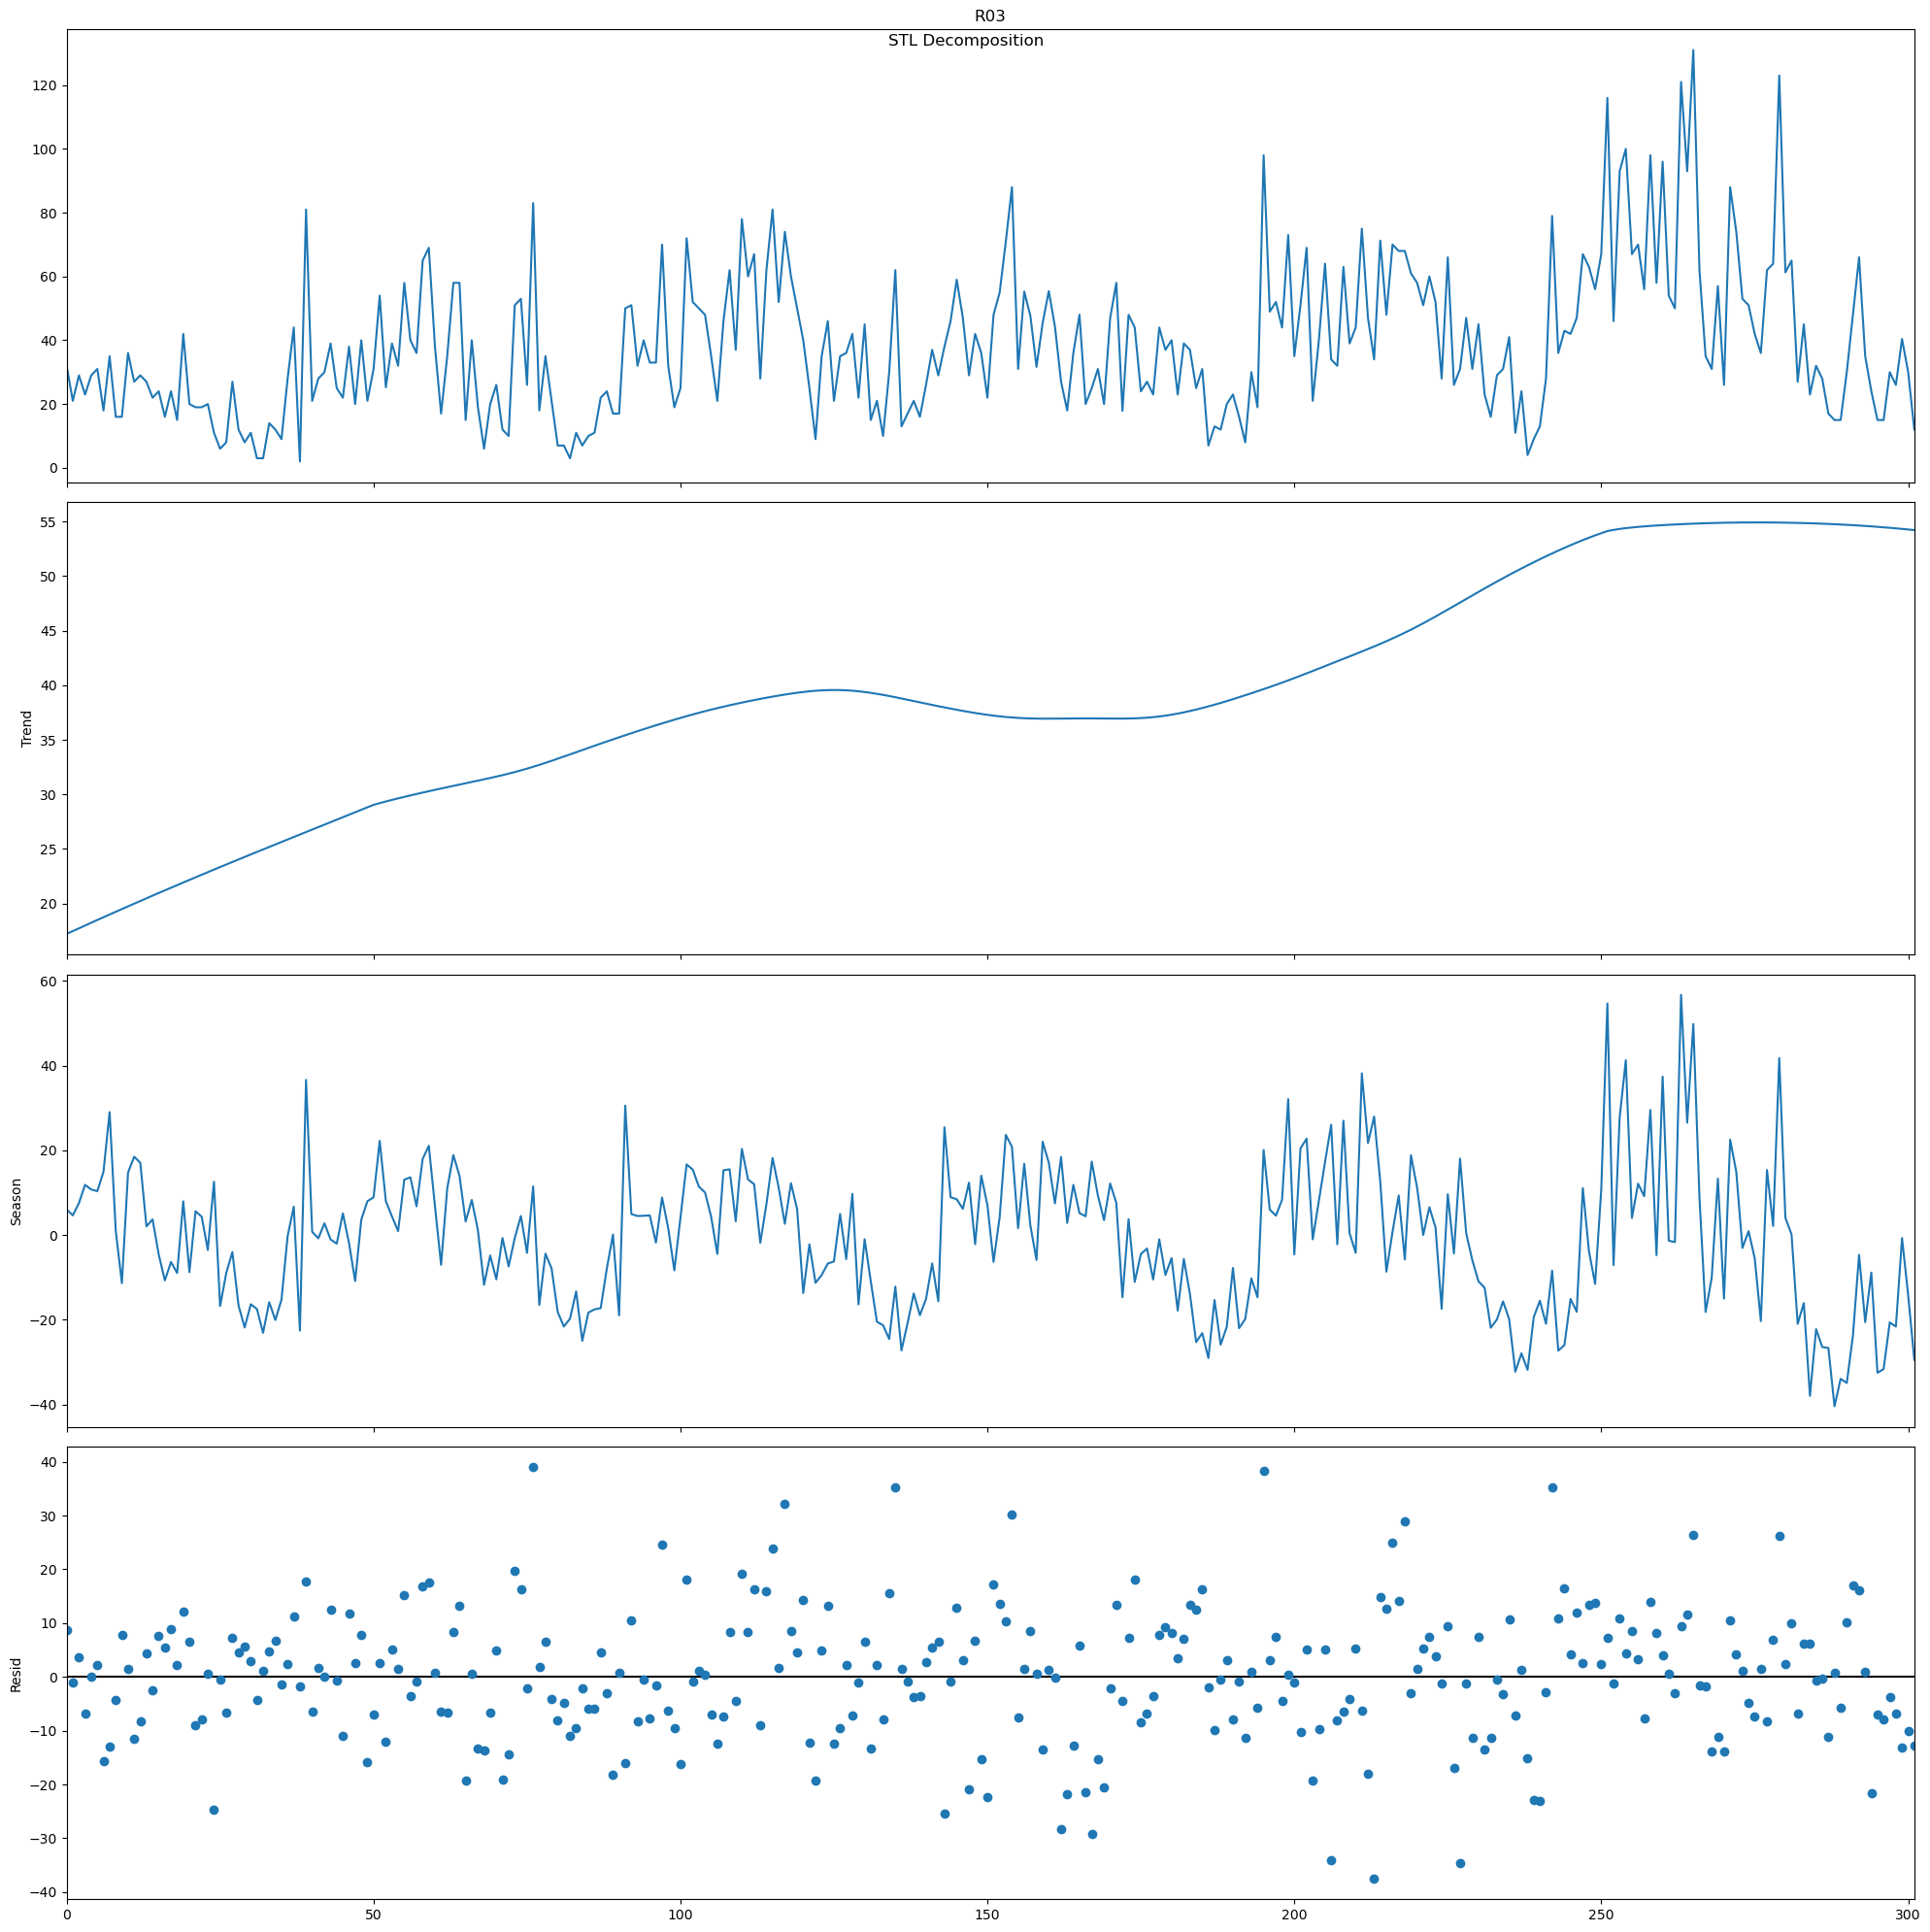

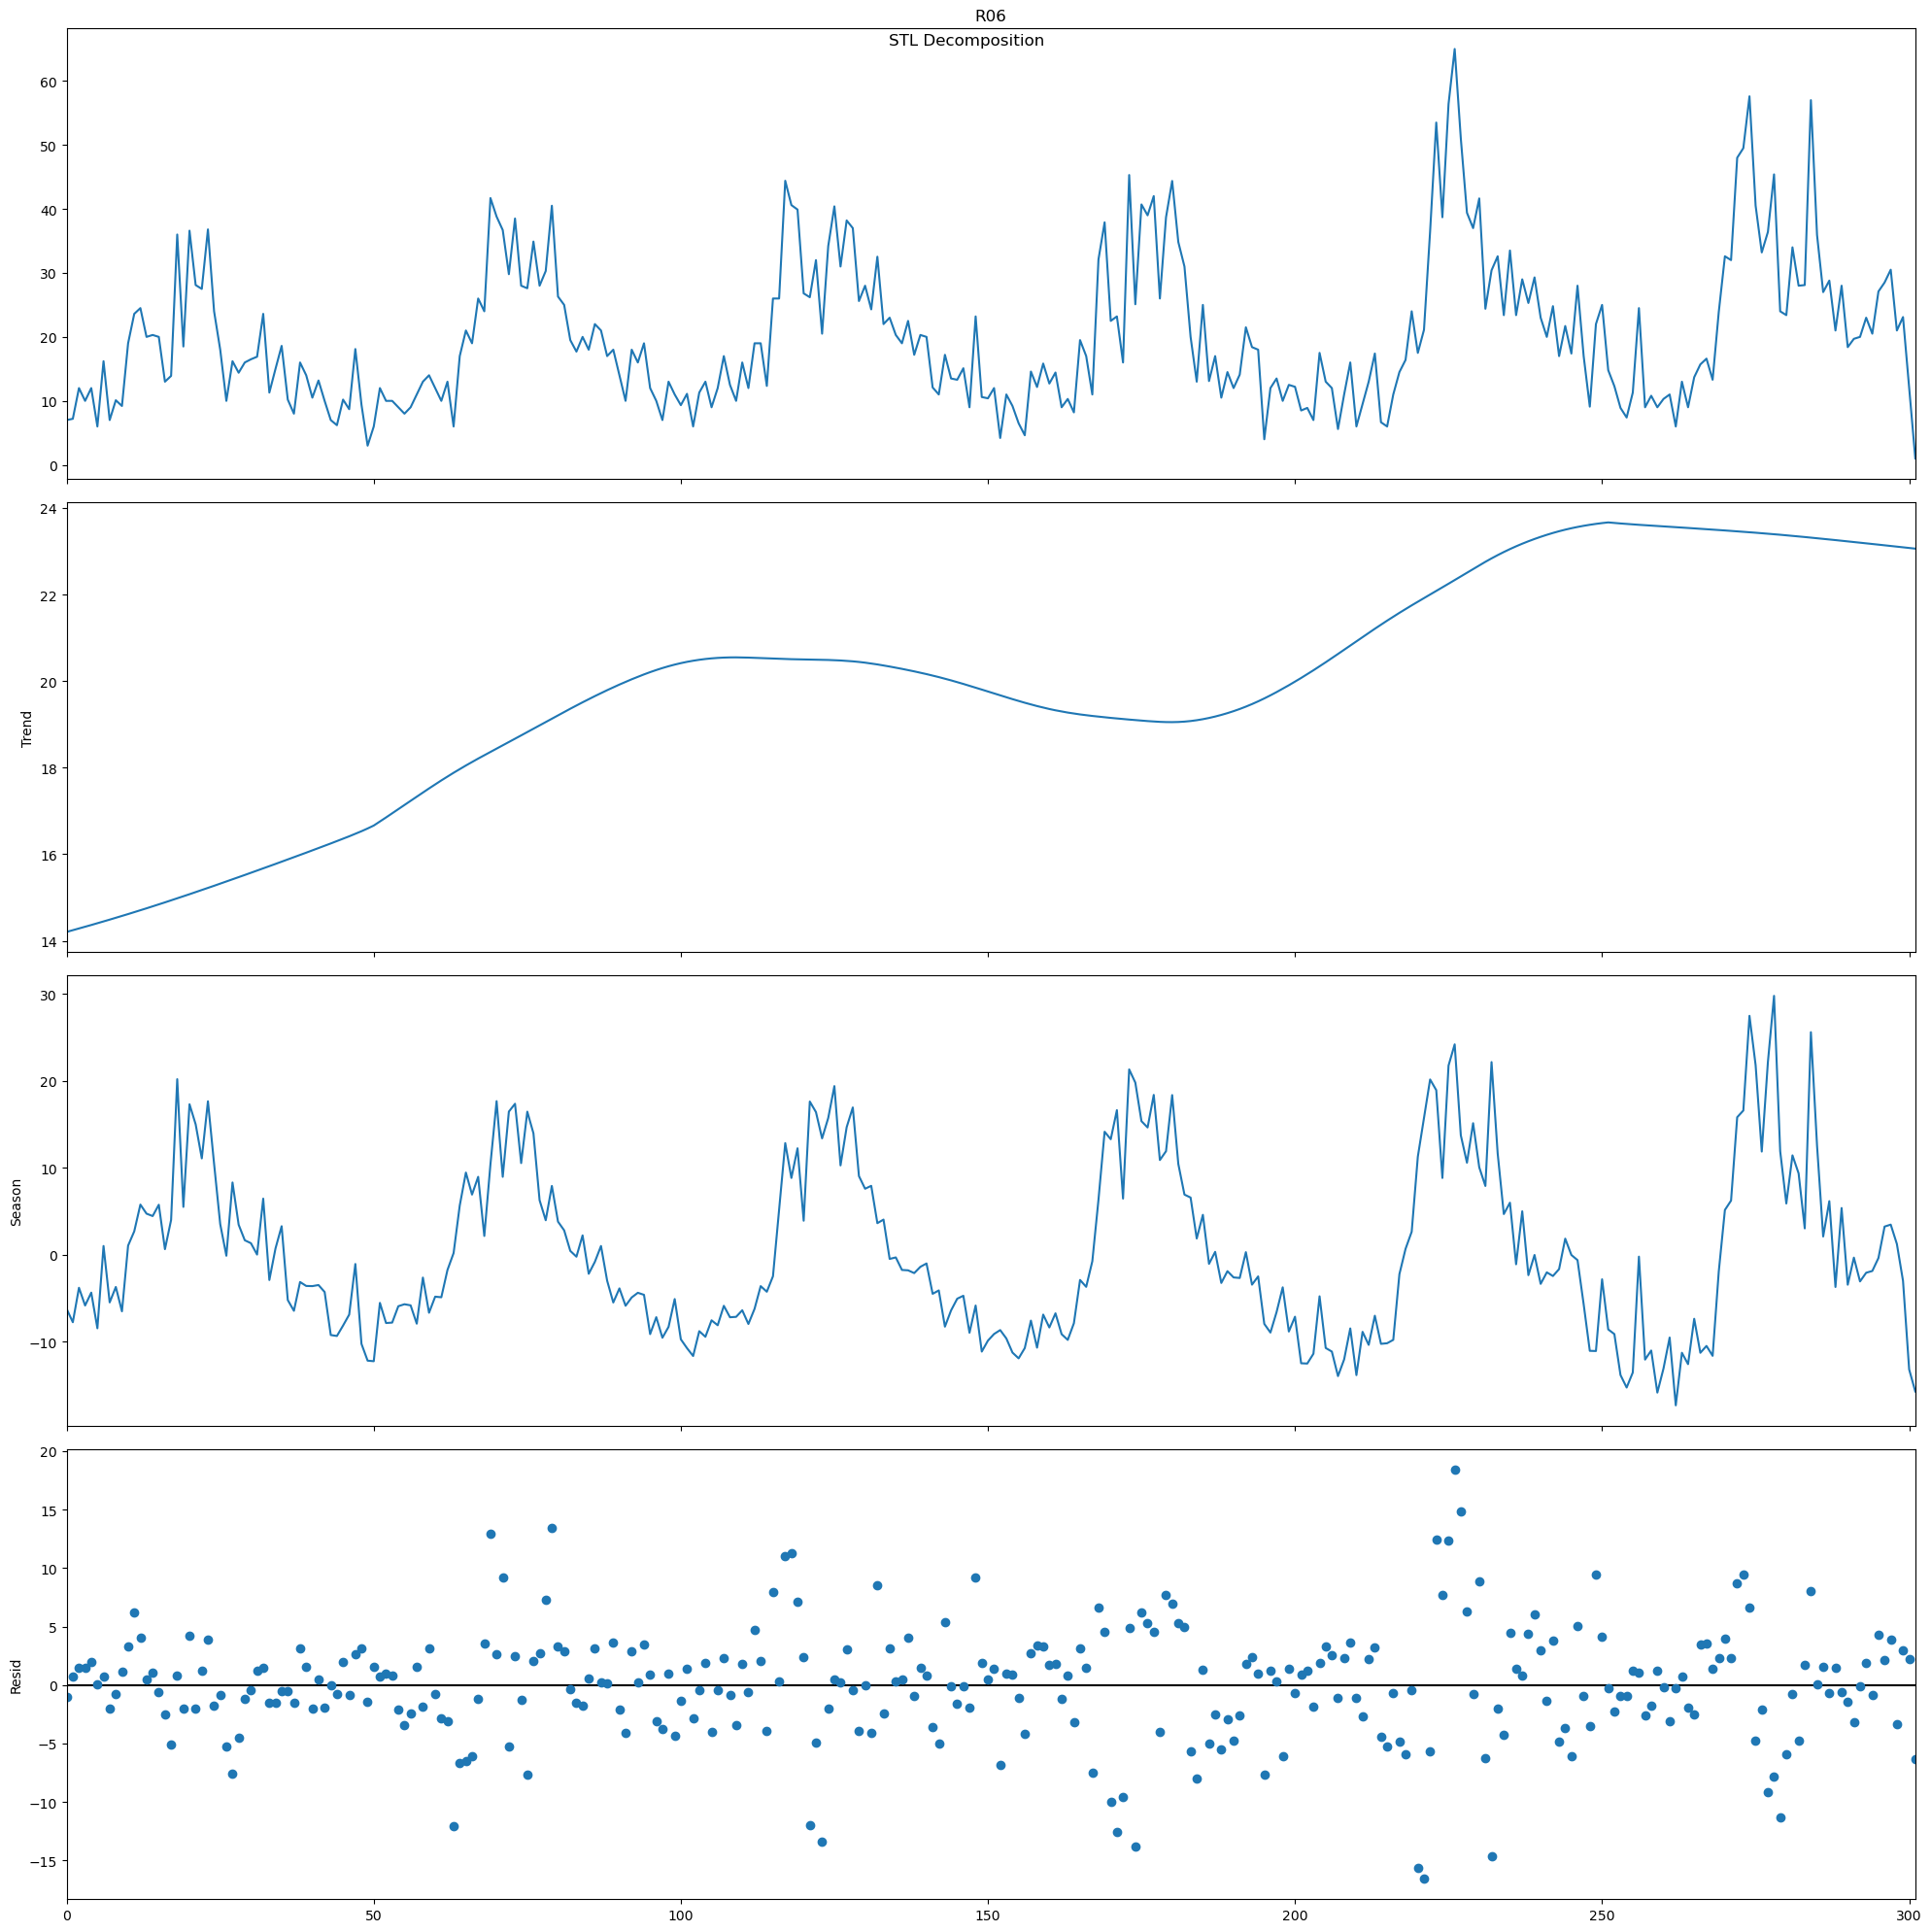

In [24]:
for drug in drugs:
    result = STL(weekly_df[drug], period=52).fit()
    plt.rcParams["figure.figsize"] = (20,20)
    result.plot().suptitle("STL Decomposition")

In [25]:
for drug in drugs:
    result = seasonal_decompose(weekly_df[drug], model='additive', period=52)
    print(result.trend)
    print(result.seasonal)
    print(result.resid)
    print(result.observed)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
297   NaN
298   NaN
299   NaN
300   NaN
301   NaN
Name: trend, Length: 302, dtype: float64
0      7.308269
1     -2.802405
2      6.340781
3      1.295429
4      1.503878
         ...   
297   -2.628116
298   -0.243905
299    4.968192
300   -1.310212
301   -0.277231
Name: seasonal, Length: 302, dtype: float64
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
297   NaN
298   NaN
299   NaN
300   NaN
301   NaN
Name: resid, Length: 302, dtype: float64
0      14.00
1      29.33
2      30.67
3      34.00
4      31.02
       ...  
297    35.51
298    46.84
299    34.01
300    38.70
301     7.67
Name: M01AB, Length: 302, dtype: float64
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
297   NaN
298   NaN
299   NaN
300   NaN
301   NaN
Name: trend, Length: 302, dtype: float64
0       6.097632
1       0.357398
2       2.176558
3       2.071916
4      11.754707
         ...    
297    -1.855995
298     1.548875
299    

In [26]:

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(weekly_df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:5.26715996284115, OBSMEAN:35.59490833332001, PERC:14.797509558159527%
M01AE RESMEAN:4.319542609675869, OBSMEAN:28.00801458336, PERC:15.422523423856601%
N02BA RESMEAN:3.9228389592521657, OBSMEAN:27.083016, PERC:14.484498178682042%
N02BE RESMEAN:29.534357236963668, OBSMEAN:217.6597028336, PERC:13.569051529737028%
N05B RESMEAN:12.94840305932125, OBSMEAN:61.96614999972, PERC:20.895929566997072%
N05C RESMEAN:2.0384606385595405, OBSMEAN:3.871833333332, PERC:52.648460382081936%
R03 RESMEAN:11.722244335544508, OBSMEAN:40.06845833336, PERC:29.25554119906046%
R06 RESMEAN:4.278758416393868, OBSMEAN:19.744589999960002, PERC:21.67053565762842%


In [27]:
# Stationary Analysis
# Augmented Dickey Fuller Test

for drug in drugs:
    test = adfuller(weekly_df[drug], regression='ct', autolag='AIC')
    print(f"{drug}: {test}")
    print(f"p-value: {test[1]}")
    if test[1]<0.5:
        print("Stationary\n")
    else:
        print("Non-Stationary\n")

M01AB: (-3.6995553522381677, 0.022386551571704164, 6, 295, {'1%': -3.9897903649837616, '5%': -3.425478311521626, '10%': -3.1358607194990724}, 2000.7374492936378)
p-value: 0.022386551571704164
Stationary

M01AE: (-8.71727144826582, 1.5940514680332016e-12, 1, 300, {'1%': -3.98926783537037, '5%': -3.425226747185185, '10%': -3.1357131066666666}, 1888.643041736867)
p-value: 1.5940514680332016e-12
Stationary

N02BA: (-2.670227413414101, 0.2486511495539186, 12, 289, {'1%': -3.990441532957606, '5%': -3.425791763669738, '10%': -3.1360446341572343}, 1872.272497392884)
p-value: 0.2486511495539186
Stationary

N02BE: (-4.362038089062473, 0.002515571533894829, 1, 300, {'1%': -3.98926783537037, '5%': -3.425226747185185, '10%': -3.1357131066666666}, 2977.4174460026284)
p-value: 0.002515571533894829
Stationary

N05B: (-3.781694485425939, 0.017510453247195662, 4, 297, {'1%': -3.9895792190177497, '5%': -3.4253766620686186, '10%': -3.135801074760346}, 2463.1101940709295)
p-value: 0.017510453247195662
Stat

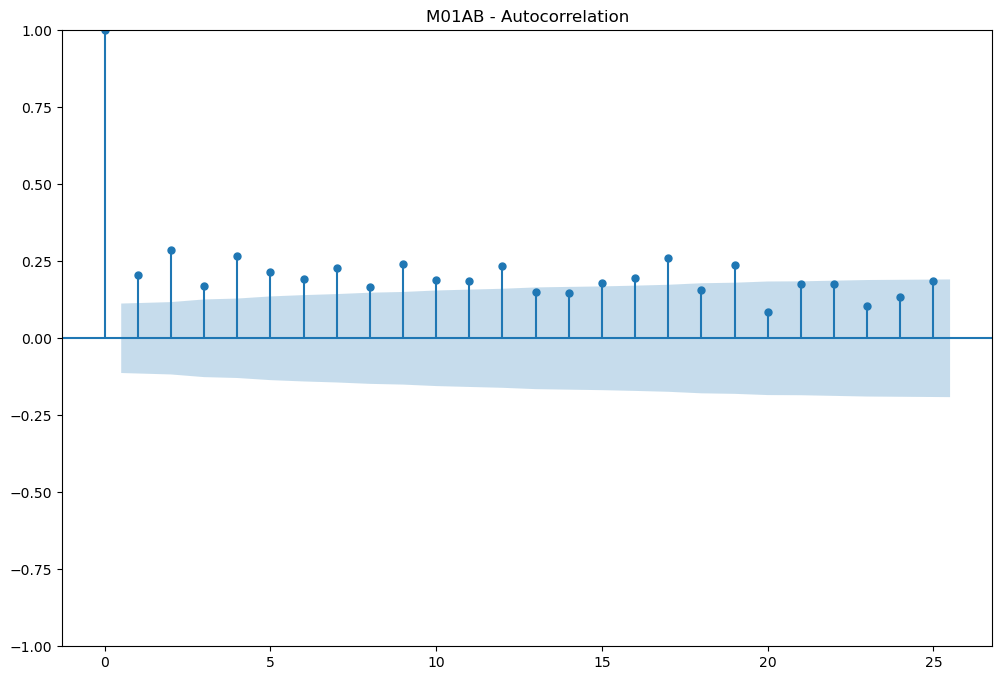

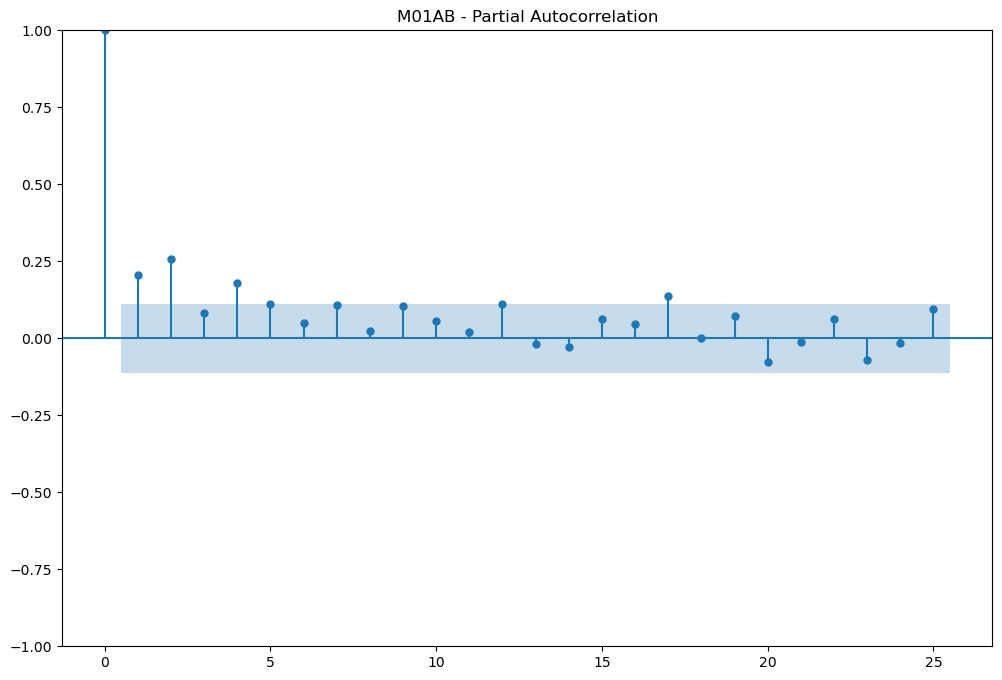

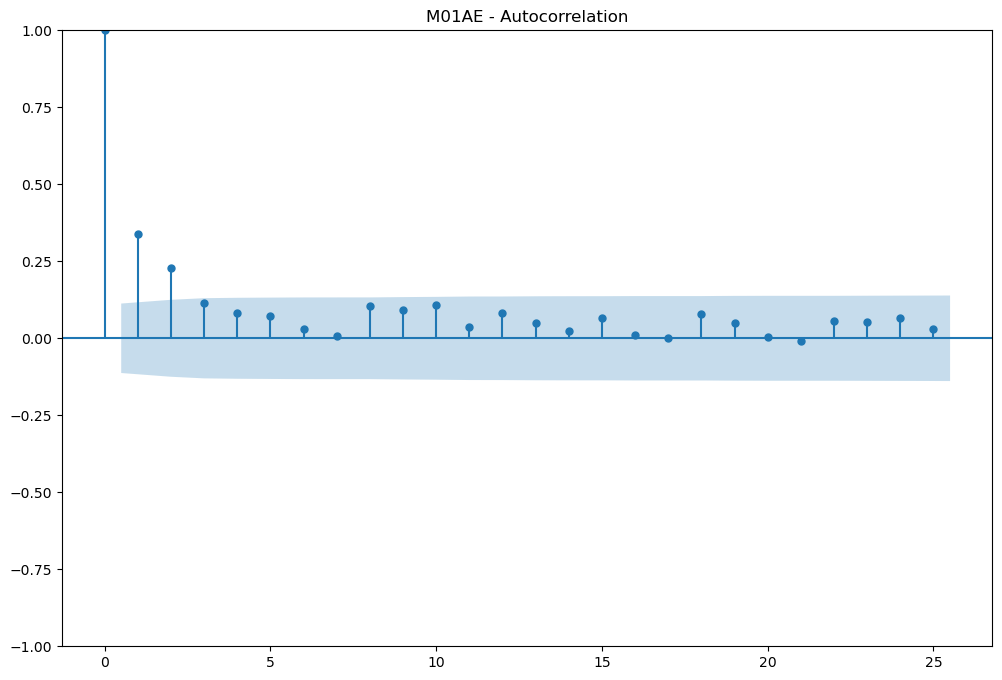

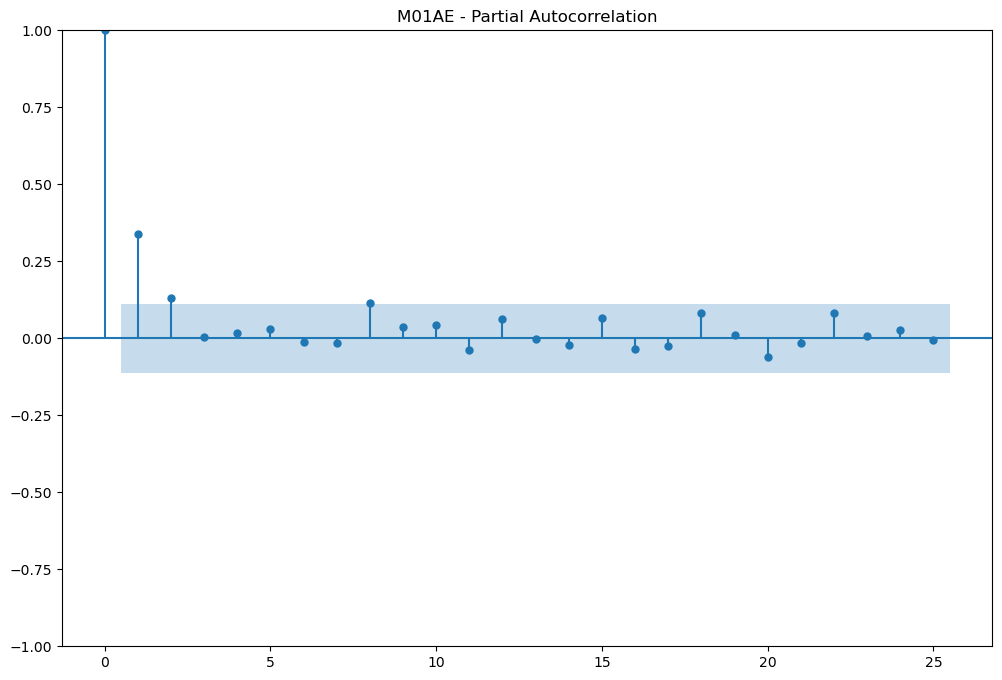

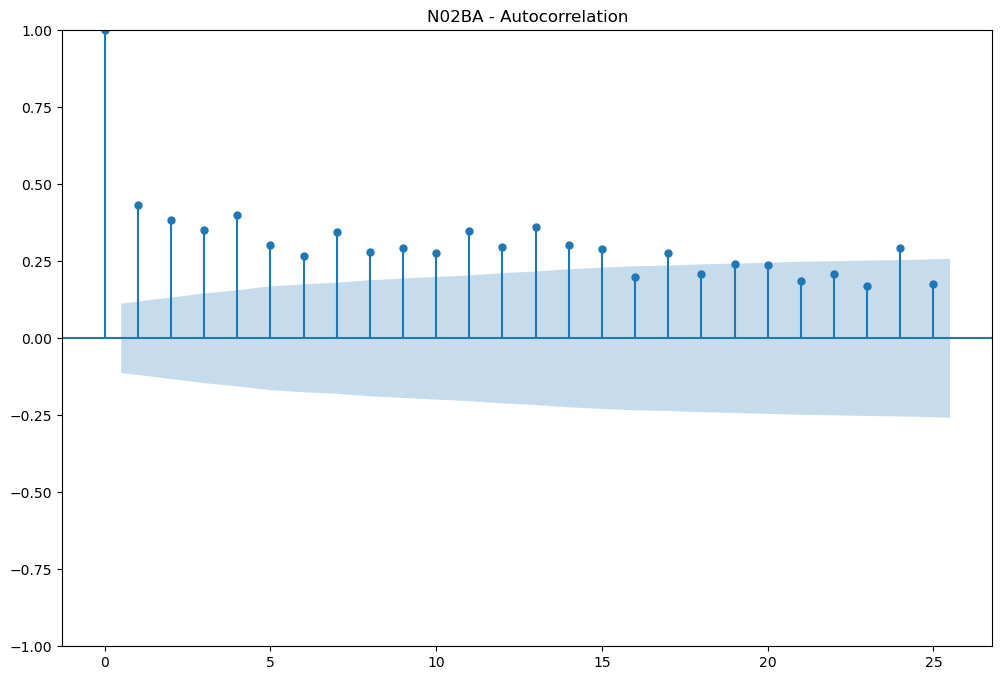

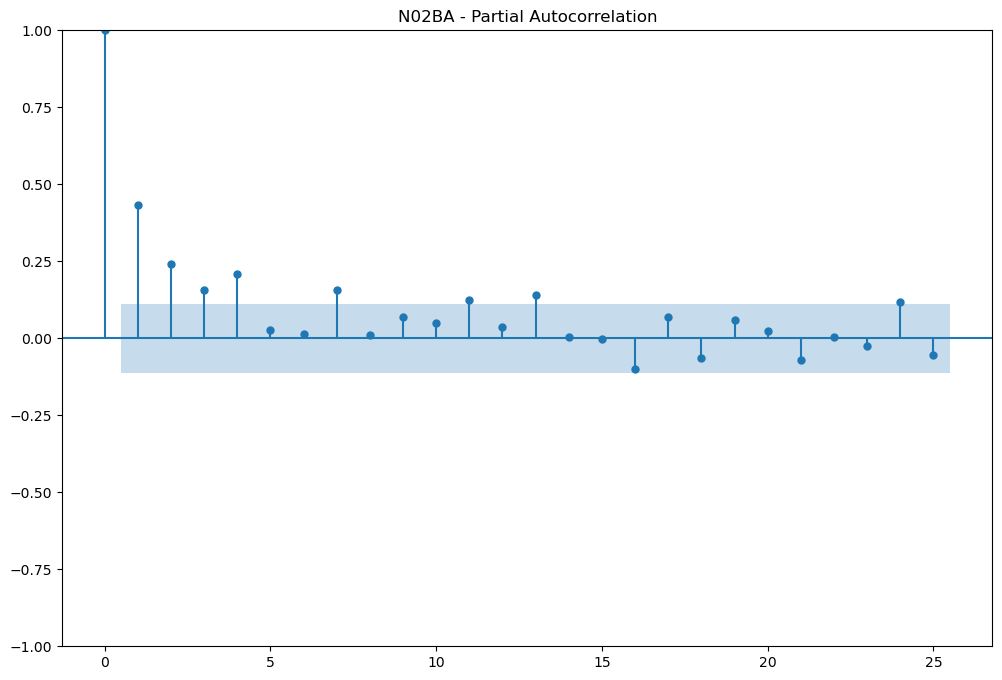

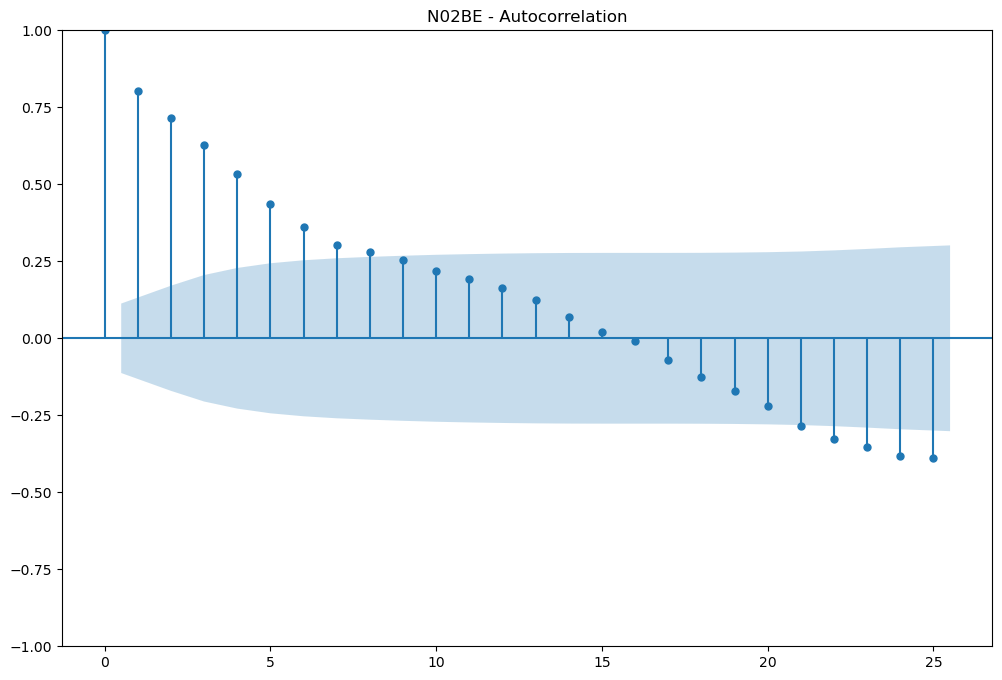

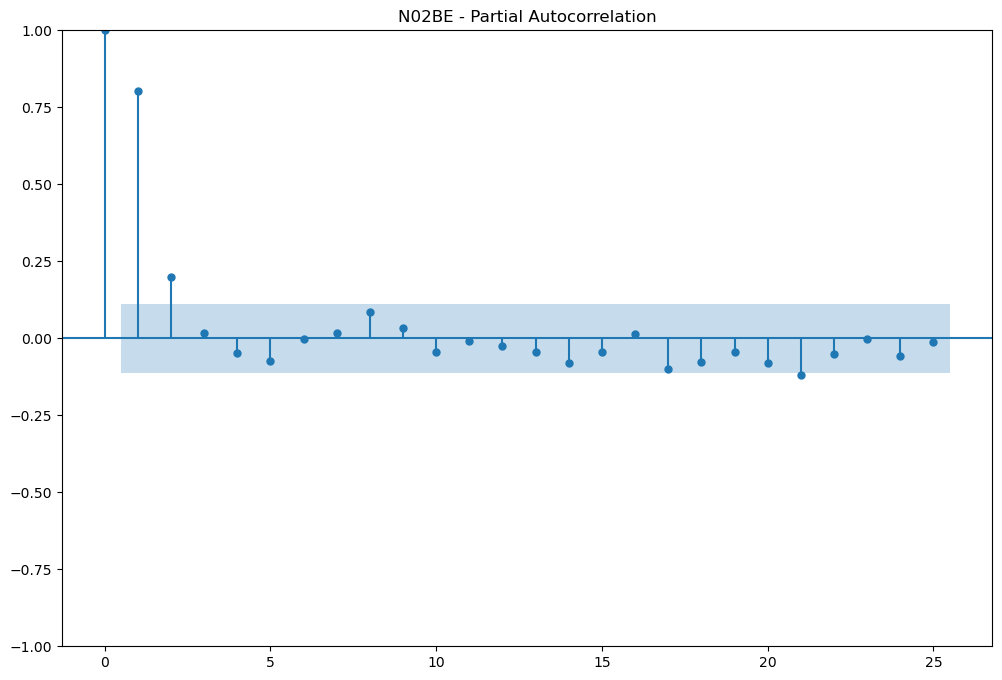

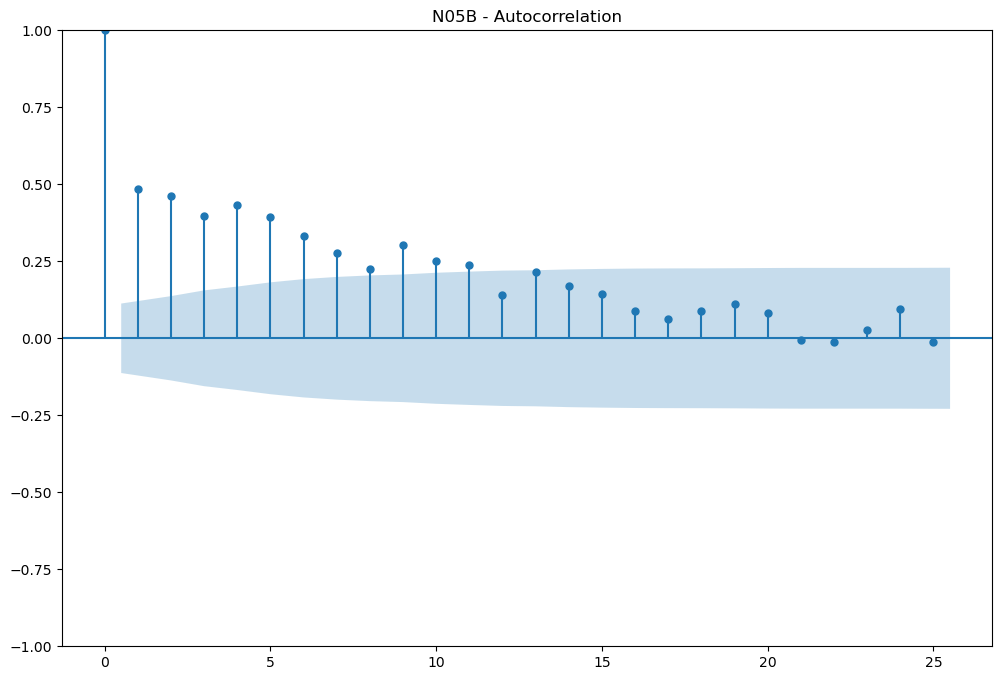

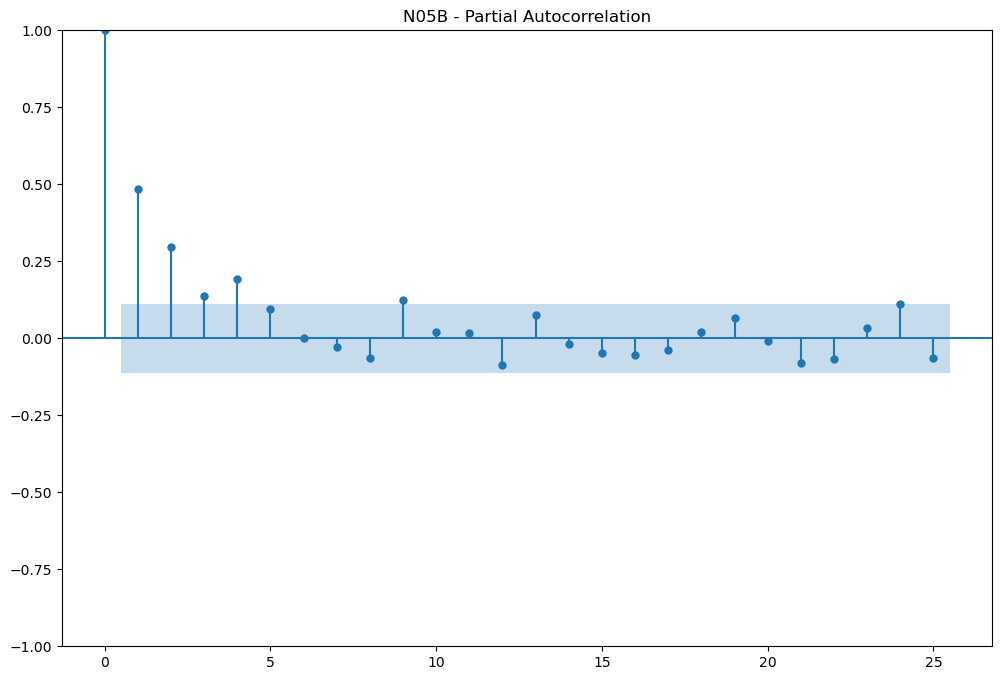

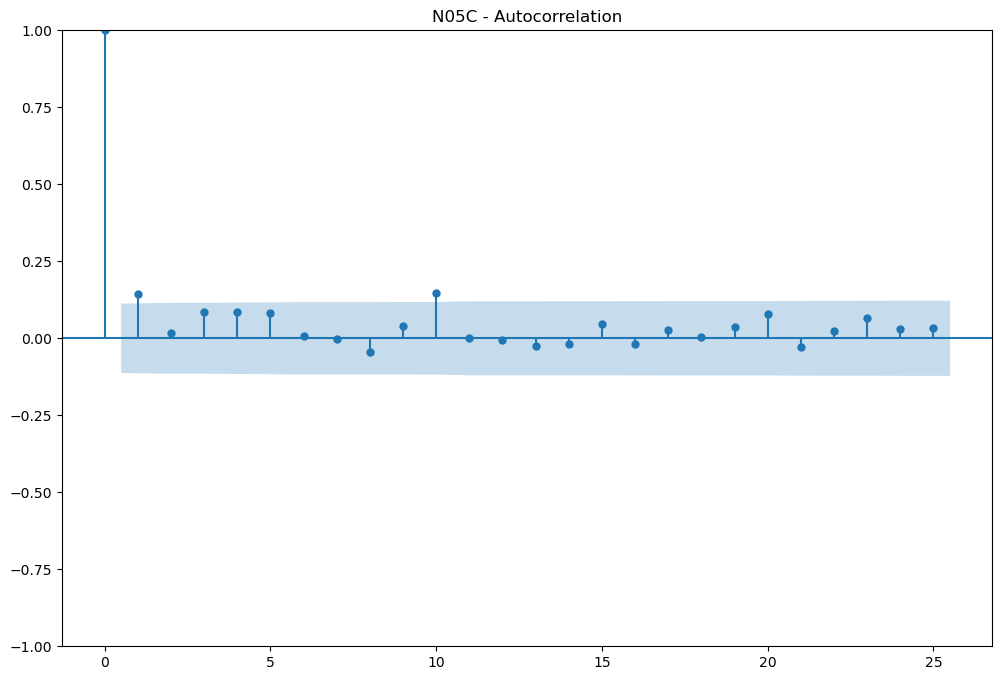

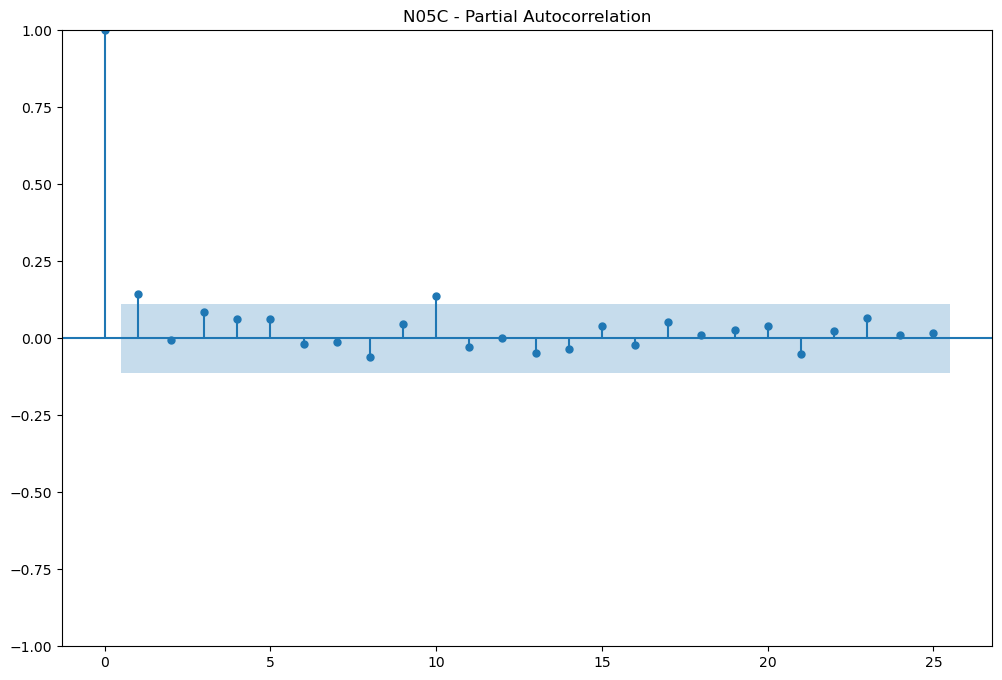

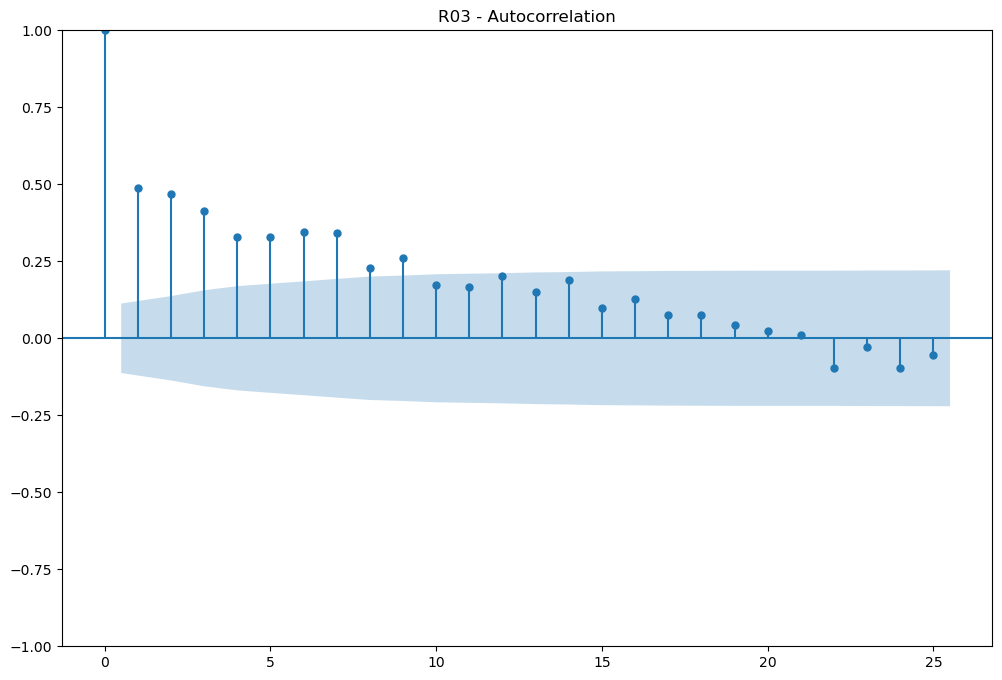

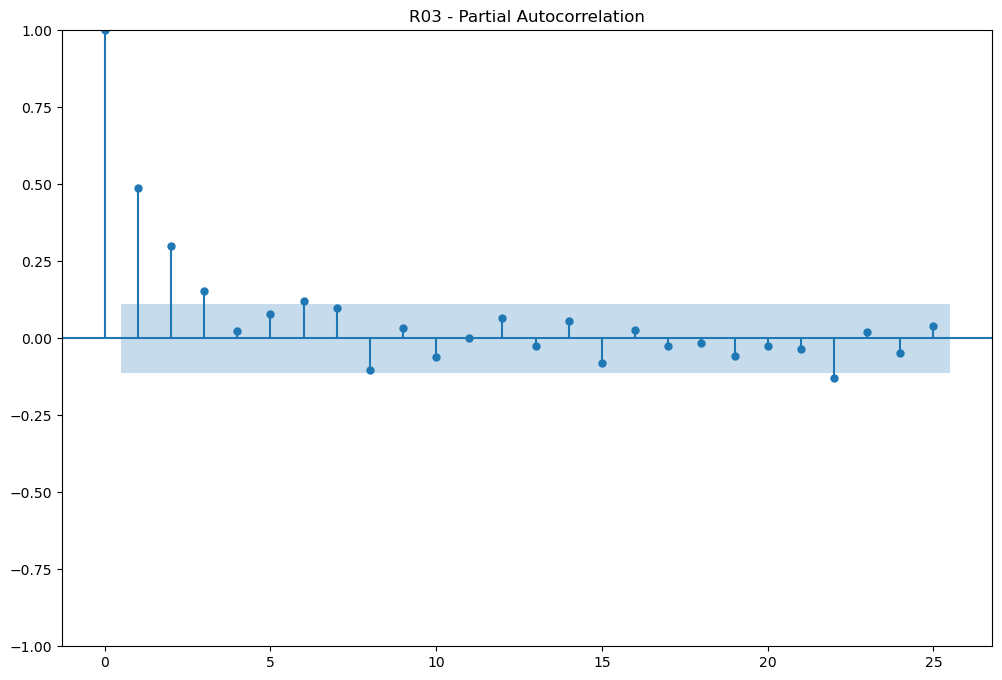

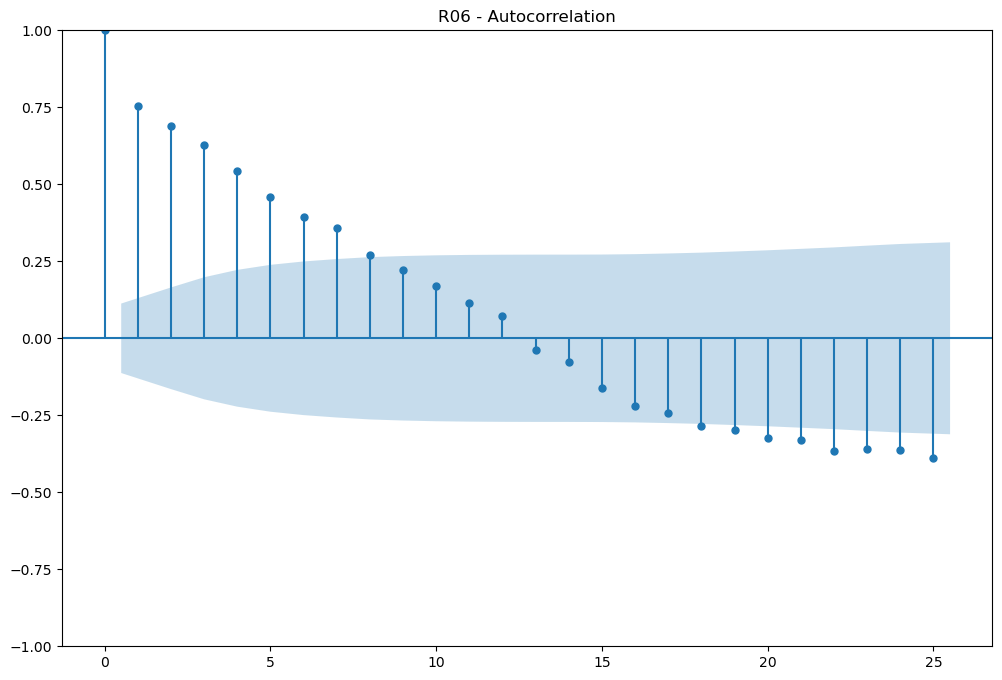

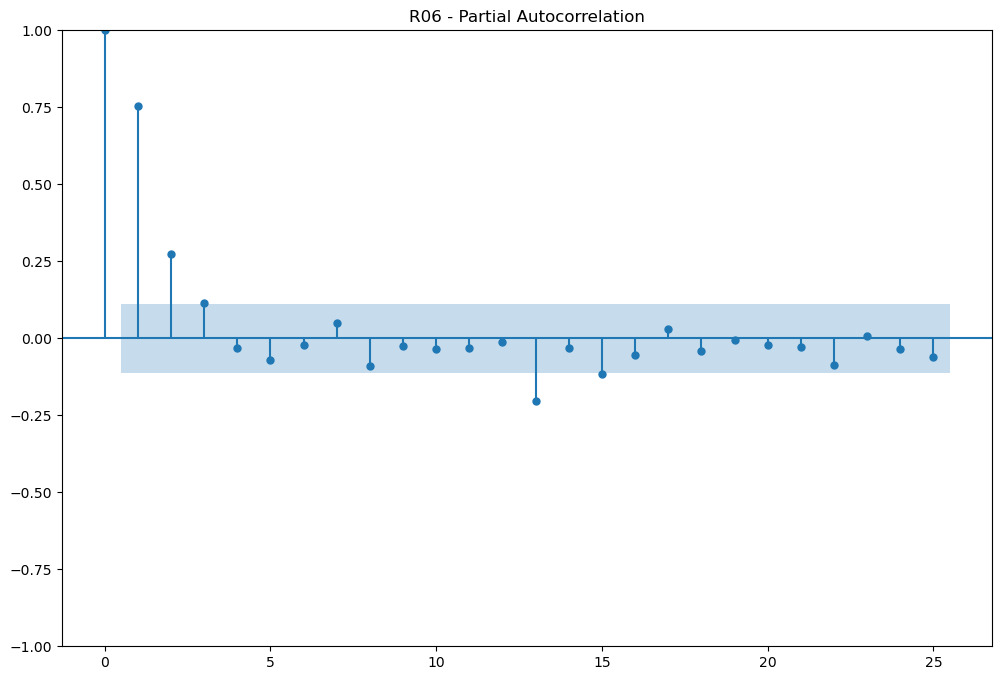

In [28]:
# Plot ACF and PACF

for drug in drugs:
    plt.rcParams["figure.figsize"] = (12,8)
    plot_acf(weekly_df[drug]) 
    plt.title(f"{drug} - Autocorrelation")
    plot_pacf(weekly_df[drug]) 
    plt.title(f"{drug} - Partial Autocorrelation")
    plt.show()

In [29]:
weekly_df['datum'] = pd.to_datetime(weekly_df['datum'])
df = weekly_df.set_index('datum')
df = df.asfreq(pd.infer_freq(df.index))

testing_timeframe = 26

train1 = df[:-testing_timeframe]
test1  = df[-testing_timeframe:]
print('training set (past data): ', len(train1))
print('test set (days to be forecasted ahead): ', len(test1))
train1 = train1[['M01AB']]
test1 = test1[['M01AB']]
train1['M01AB'] = pd.to_numeric(train1['M01AB'], errors='coerce')
train1

training set (past data):  276
test set (days to be forecasted ahead):  26


M01AB
datum            
2014-01-05  14.00
2014-01-12  29.33
2014-01-19  30.67
2014-01-26  34.00
2014-02-02  31.02
...           ...
2019-03-17  43.51
2019-03-24  35.99
2019-03-31  31.17
2019-04-07  36.19
2019-04-14  30.33

[276 rows x 1 columns]

                               SARIMAX Results                                
Dep. Variable:                  M01AB   No. Observations:                  276
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -955.834
Date:                Tue, 15 Oct 2024   AIC                           1919.668
Time:                        10:47:22   BIC                           1934.149
Sample:                    01-05-2014   HQIC                          1925.479
                         - 04-14-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.0063      2.272     14.967      0.000      29.553      38.460
ar.L1          0.9819      0.015     63.671      0.000       0.952       1.012
ma.L1         -0.8896      0.040    -22.137      0.0

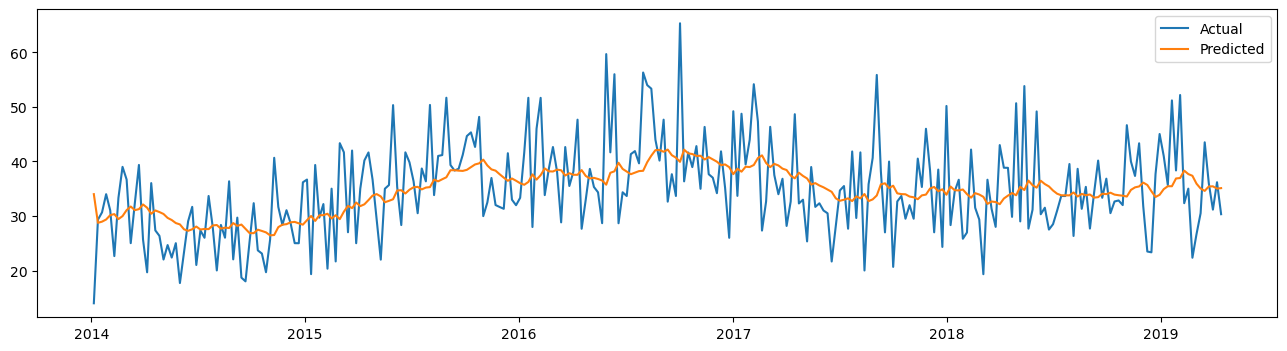

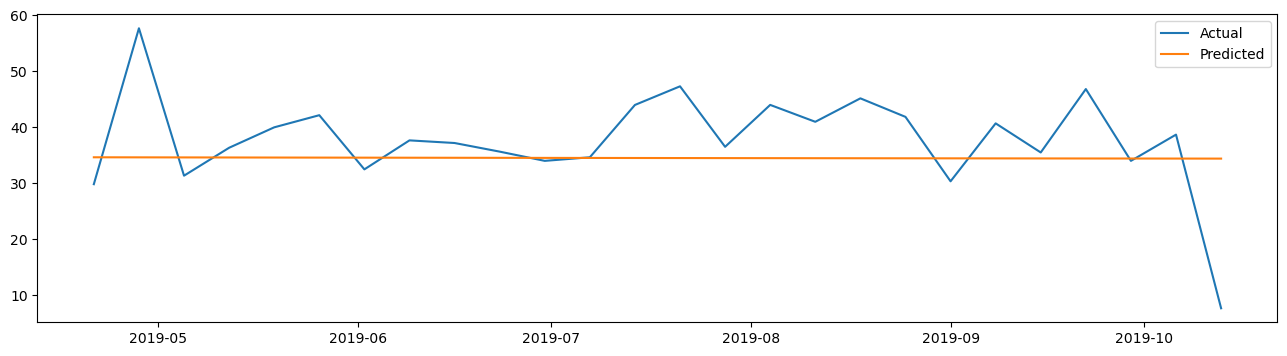

In [30]:
# Create and fit the model

model_fit = ARIMA(train1,  
                  order = (1,0,1)
                ).fit()
print(model_fit.summary())
print('\n')

forecasts_on_train = model_fit.predict()
forecasts_on_test  = model_fit.forecast(len(test1))
RMSE = np.sqrt(mean_squared_error(test1['M01AB'], forecasts_on_test))

print('AIC: ' , model_fit.aic)
print('RMSE: ', RMSE)

# plot the train and test data against their corresponding forecasts

plt.figure(figsize=(16,4))
plt.plot(train1['M01AB'], label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

plt.figure(figsize=(16,4))
plt.plot(test1['M01AB'], label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()

In [31]:
# Determine SARIMA parameters

p_values = range(0, 3)  # Autoregressive order
d_values = range(0, 1)  # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period (monthly)

param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))

best_aic = float("inf")  
best_params = None

# Grid search
for parameters in param_combinations:
    order = parameters[:3]
    seasonal_order = parameters[3:]
    
    try:
        model = sm.tsa.SARIMAX(train1, 
                               order=order, 
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 2761.587568549815
(0, 0, 0) (0, 0, 1, 12) 2524.104174938316
(0, 0, 0) (1, 0, 0, 12) 2107.0293321488844


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 0) (1, 0, 1, 12) 2026.0719931342837
(0, 0, 1) (0, 0, 0, 12) 2528.8461287742603
(0, 0, 1) (0, 0, 1, 12) 2396.777297843081
(0, 0, 1) (1, 0, 0, 12) 2107.206104165519


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 1) (1, 0, 1, 12) 2022.602316801096
(0, 0, 2) (0, 0, 0, 12) 2368.094272454601
(0, 0, 2) (0, 0, 1, 12) 2272.631740079024
(0, 0, 2) (1, 0, 0, 12) 2095.289668973024


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 0, 2) (1, 0, 1, 12) 2011.129874932437
(1, 0, 0) (0, 0, 0, 12) 2085.476624125177
(1, 0, 0) (0, 0, 1, 12) 2085.6106382795115
(1, 0, 0) (1, 0, 0, 12) 2085.4017184924583


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 0) (1, 0, 1, 12) 2019.2432172816352
(1, 0, 1) (0, 0, 0, 12) 1923.7069106856104
(1, 0, 1) (0, 0, 1, 12) 1925.2594100373997
(1, 0, 1) (1, 0, 0, 12) 1925.2225145314958


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(1, 0, 1) (1, 0, 1, 12) 1926.8268746035037
(1, 0, 2) (0, 0, 0, 12) 1925.3976890125682
(1, 0, 2) (0, 0, 1, 12) 1927.0161230609033
(1, 0, 2) (1, 0, 0, 12) 1926.9844501722102


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) (1, 0, 1, 12) 1928.6227040666
(2, 0, 0) (0, 0, 0, 12) 1994.013175244039
(2, 0, 0) (0, 0, 1, 12) 1993.5736742074614
(2, 0, 0) (1, 0, 0, 12) 1993.5292679929207


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 0) (1, 0, 1, 12) 1995.4955520813173
(2, 0, 1) (0, 0, 0, 12) 1925.3469536315304
(2, 0, 1) (0, 0, 1, 12) 1926.9716622299184
(2, 0, 1) (1, 0, 0, 12) 1926.9406279926638


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 1) (1, 0, 1, 12) 1928.8877132950504


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2) (0, 0, 0, 12) 1927.6555053869001


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 0, 2) (0, 0, 1, 12) 1929.1826595898688


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(2, 0, 2) (1, 0, 0, 12) 1929.1417066437389
(2, 0, 2) (1, 0, 1, 12) 1930.6824041538648
Best Parameters: (1, 0, 1, 0, 0, 0, 12)
Best AIC: 1923.7069106856104


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# Define SARIMA parameters 
p, d, q = 1, 0, 1
P, D, Q, s = 0, 0, 0, 12 
  
# Fit the SARIMA model 
model = SARIMAX(daily_df['M01AB'], order=(p, d, q), seasonal_order=(P, D, Q, s)) 
results = model.fit() 
model 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48940D+00    |proj g|=  1.04951D-01

At iterate    5    f=  2.41822D+00    |proj g|=  1.04918D-03

At iterate   10    f=  2.41755D+00    |proj g|=  8.32815D-03

At iterate   15    f=  2.41158D+00    |proj g|=  2.32386D-03

At iterate   20    f=  2.40943D+00    |proj g|=  1.59990D-03

At iterate   25    f=  2.40902D+00    |proj g|=  2.36832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     29      1     0     0   

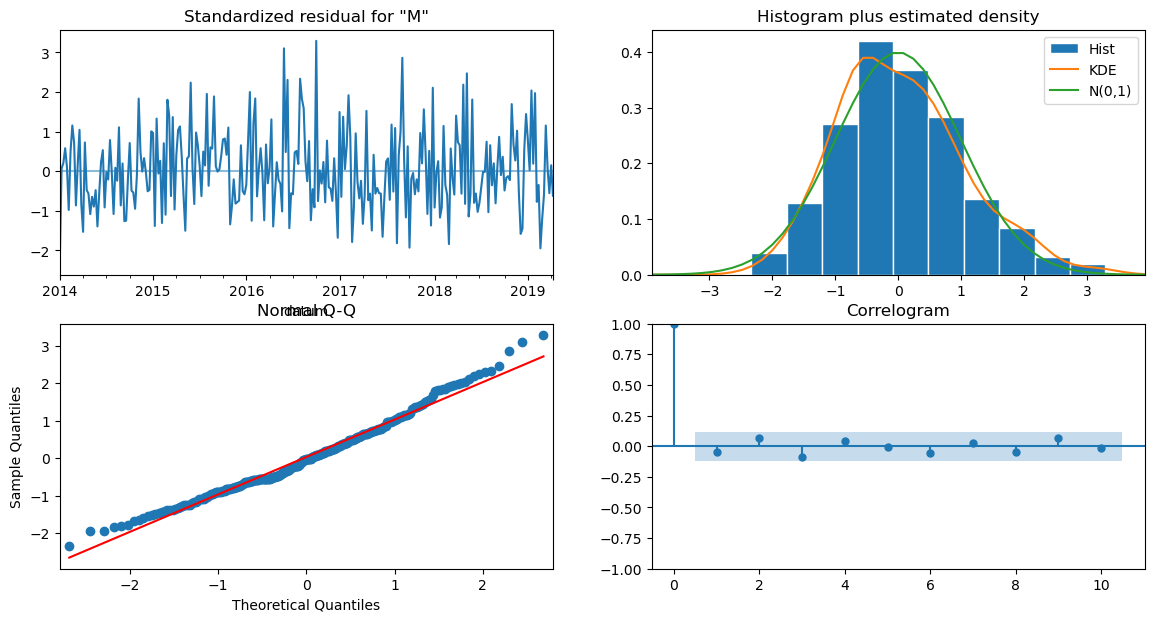

In [33]:
model_fit.plot_diagnostics(figsize=(14,7))
plt.show()

In [34]:
# Forecast future values 
forecast_periods = 12  # Forecast the next 12 months 
forecast = results.get_forecast(steps=forecast_periods) 
forecast_mean = forecast.predicted_mean 
forecast_ci = forecast.conf_int() 
  
# Plot the forecast 
plt.figure(figsize=(12, 6)) 
plt.plot(monthly_sales, label='Observed') 
plt.plot(forecast_mean, label='Forecast', color='red') 
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
plt.title("Sales Forecast") 
plt.xlabel("Date") 
plt.ylabel("Sales") 
plt.legend() 
plt.show()

NameError: name 'monthly_sales' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
observed = monthly_sales[-forecast_periods:] 
mae = mean_absolute_error(observed, forecast_mean) 
mse = mean_squared_error(observed, forecast_mean) 
print(f'MAE: {mae}') 
print(f'MSE: {mse}')

In [ ]:
observed = monthly_sales[-forecast_periods:] 
mae = mean_absolute_error(observed, forecast_mean) 
mse = mean_squared_error(observed, forecast_mean) 
print(f'MAE: {mae}') 
print(f'MSE: {mse}')

In [ ]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

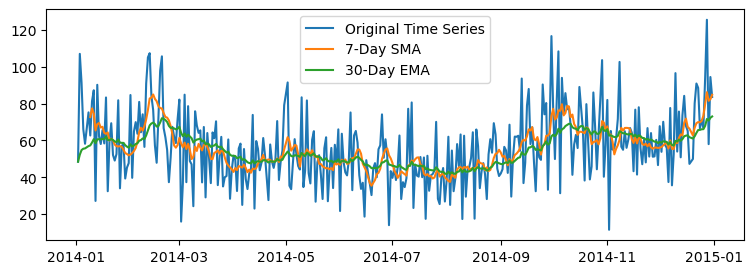

In [66]:
plt.figure(figsize=(9, 3))
plt.plot(ts_2014, label='Original Time Series')
plt.plot(sma, label=f'{sma_window}-Day SMA')
plt.plot(ema, label=f'{ema_window}-Day EMA')
plt.legend()